In [ ]:
DATA_PATH = '../input/common-voice/cv-valid-train/'
CSV_PATH = '../input/common-voice/cv-valid-train.csv'

In [ ]:
import os

chemin_dossier = "../input//common-voice/cv-valid-train/cv-valid-train"  # remplace par le chemin réel
nb_fichiers = sum(os.path.isfile(os.path.join(chemin_dossier, f)) for f in os.listdir(chemin_dossier))

print(f"Nombre de fichiers : {nb_fichiers}")

In [ ]:
train = pd.read_csv(CSV_PATH)

In [ ]:
train

In [ ]:

ds_path = "../input/common-voice/cv-valid-train/"
def feature_extraction(filename, sampling_rate=48000):
    path = f"{ds_path}{filename}"
    features = []
    audio, _ = librosa.load(path, sr=sampling_rate)

    text = data[data['filename'] == filename].text.values[0]
    
    features.append(np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate)))
    features.append(np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate)))
    features.append(np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate)))
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=20)
    features.extend(np.mean(mfcc, axis=1))
    return features

In [ ]:
import pandas as pd
import os
import IPython.display as ipd

# Chemins vers les données
CSV_PATH = '../input/common-voice/cv-valid-train.csv'
AUDIO_FOLDER = '../input/common-voice/cv-valid-train/'

# Charger le CSV
train = pd.read_csv(CSV_PATH)

# Afficher les 10 premiers exemples avec audio + transcription
for i in range(10):
    filename = train.iloc[i]['filename']
    text = train.iloc[i]['text']
    
    audio_path = os.path.join(AUDIO_FOLDER, filename)
    
    print(f"\n🎧 Audio {i+1} : {filename}")
    print(f"📝 Transcription : {text}")
    
    # Lire l'audio dans Kaggle Notebook
    display(ipd.Audio(audio_path))


In [ ]:
train_speech = train.drop(columns=['duration','age','down_votes','up_votes','gender', 'accent'])


In [3]:
test = test.drop(columns=['duration','age','down_votes','up_votes','gender', 'accent'])


In [4]:
test

filename  \
0     cv-valid-test/sample-000000.mp3   
1     cv-valid-test/sample-000001.mp3   
2     cv-valid-test/sample-000002.mp3   
3     cv-valid-test/sample-000003.mp3   
4     cv-valid-test/sample-000004.mp3   
...                               ...   
3990  cv-valid-test/sample-003990.mp3   
3991  cv-valid-test/sample-003991.mp3   
3992  cv-valid-test/sample-003992.mp3   
3993  cv-valid-test/sample-003993.mp3   
3994  cv-valid-test/sample-003994.mp3   

                                                   text  
0            without the dataset the article is useless  
1                                 i've got to go to him  
2                                       and you know it  
3     down below in the darkness were hundreds of pe...  
4     hold your nose to keep the smell from disablin...  
...                                                 ...  
3990  the old man opened his cape and the boy was st...  
3991       in alchemy it's called the soul of the world  
3992  at that point in their lives everything is cle...  
3993                      he told them all to be seated  
3994                 the restaurant was quite expensive  

[3995 rows x 2 columns]

In [5]:
test.to_csv("test_rl.csv", index=False)

In [ ]:
print("Nombre de lignes sans texte :", len(null_or_empty_text_df))


In [ ]:
train.to_csv("speech_train.csv", index=False)

In [ ]:

train_gender= train.drop(columns=['duration','age','down_votes','up_votes','text', 'accent'])


# ***spectrogramm*** 

In [ ]:

import os
import librosa
import numpy as np
import pandas as pd
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def extract_spectrogram(file_path, n_mels=128):
    audio, sr = librosa.load(file_path)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    return spectrogram, sr

In [ ]:
import os

chemin_dossier = "/kaggle/input/cv-valid-train"  # remplace par le chemin réel
nb_fichiers = sum(os.path.isfile(os.path.join(chemin_dossier, f)) for f in os.listdir(chemin_dossier))

print(f"Nombre de fichiers : {nb_fichiers}")


In [ ]:
import gc
import numpy as np
import os

# Function to generate spectrograms in batches
def spectrogram_generator(df, batch_size=32):
    i = 0
    while i < len(df):
        batch = df.iloc[i:i+batch_size]
        spectrogram_batch = []
        for _, row in batch.iterrows():
            file_path = os.path.join(audio_folder_path_original, row['filename'])
            spectrogram, _ = extract_spectrogram(file_path)
            spectrogram_batch.append(spectrogram)
        yield spectrogram_batch
        i += batch_size

# Folder path to the original audio files
audio_folder_path_original = '/kaggle/input/common-voice/cv-valid-train'

# Initialize variables
max_time_frames_spec = 0
all_spectrograms_processed_without_us = []

# Process the spectrograms in batches
for i, spectrogram_batch in enumerate(spectrogram_generator(train_speech)):
    batch_spectrograms_processed_without_us = []
    
    for spectrogram in spectrogram_batch:
        batch_spectrograms_processed_without_us.append(spectrogram)
        max_time_frames_spec = max(max_time_frames_spec, spectrogram.shape[1])

    all_spectrograms_processed_without_us.extend(batch_spectrograms_processed_without_us)
    del batch_spectrograms_processed_without_us
    gc.collect()  # Clear memory after each batch is processed

# Process padding for each spectrogram one by one
all_spectrograms_processed_padded_without_us = []

for spectrogram in all_spectrograms_processed_without_us:
    if spectrogram.shape[1] < max_time_frames_spec:
        pad_width = ((0, 0), (0, max_time_frames_spec - spectrogram.shape[1]))
        spectrogram_processed_without_us = np.pad(spectrogram, pad_width, mode='constant')
    elif spectrogram.shape[1] > max_time_frames_spec:
        spectrogram_processed_without_us = spectrogram[:, :max_time_frames_spec]
    else:
        spectrogram_processed_without_us = spectrogram
    all_spectrograms_processed_padded_without_us.append(spectrogram_processed_without_us)

    del spectrogram  # Free memory after processing each spectrogram

del all_spectrograms_processed_without_us  # Free memory from previous variable

# Concatenate spectrograms once they're all processed and padded
all_spectrograms_concatenated_without_us = np.stack(all_spectrograms_processed_padded_without_us, axis=0)

# Free the memory for the padded spectrogram list
del all_spectrograms_processed_padded_without_us

# Print the shape of the concatenated spectrograms
print("Размер all_spectrograms_concatenated_without_us:", all_spectrograms_concatenated_without_us.shape)


In [ ]:
import os
from pathlib import Path
import torch
import torchaudio
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import numpy as np
import gc  # Importation de la gestion de la mémoire

AUDIO_DIR = Path("/kaggle/input/common-voice/cv-valid-train/cv-valid-train")
OUTPUT_DIR = Path("/kaggle/working/mel_features")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

BATCH_SIZE = 5000  # Réduction de la taille des lots pour économiser la mémoire
SR = 16000
N_MELS = 80 
MAX_WORKERS = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === TRANSFORMATEUR GPU ===
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_mels=N_MELS
).to(device)

db_transform = torchaudio.transforms.AmplitudeToDB().to(device)

# === FONCTION D'EXTRACTION ===
def extract_mel(audio_path):
    try:
        out_path = OUTPUT_DIR / (audio_path.stem + ".npy")
        if out_path.exists():
            return f"skip:{audio_path.name}"

        # Chargement du fichier audio
        waveform, sr = torchaudio.load(audio_path)
        waveform = torchaudio.functional.resample(waveform, sr, SR)
        waveform = waveform.to(device)

        # Calcul du Mel-Spectrogramme
        mel = mel_transform(waveform)
        mel_db = db_transform(mel)
        mel_db = mel_db.squeeze().cpu().numpy()

        # Sauvegarde du Mel-Spectrogramme
        np.save(out_path, mel_db)  # Sauvegarde du fichier numpy
        return f"done:{audio_path.name}"
    except Exception as e:
        return f"error:{audio_path.name}:{str(e)}"

# === LISTE DES FICHIERS À TRAITER ===
all_files = sorted([f for f in AUDIO_DIR.rglob("*.mp3")])
already_done = {f.stem for f in OUTPUT_DIR.glob("*.npy")}
pending_files = [f for f in all_files if f.stem not in already_done]

print(f"Total fichiers à traiter : {len(pending_files)}")

# === TRAITEMENT PAR BATCH ===
for i in range(0, len(pending_files), BATCH_SIZE):
    batch_files = pending_files[i:i+BATCH_SIZE]
    print(f"\nTraitement du batch {i//BATCH_SIZE + 1} : {len(batch_files)} fichiers")

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        results = list(tqdm(executor.map(extract_mel, batch_files), total=len(batch_files)))

    # Résumé
    done = sum(1 for r in results if r.startswith("done"))
    skipped = sum(1 for r in results if r.startswith("skip"))
    errors = [r for r in results if r.startswith("error")]
    print(f"Fichiers traités : {done}, ignorés : {skipped}, erreurs : {len(errors)}")

    # Libération de la mémoire GPU
    torch.cuda.empty_cache() 

    # Libération de la mémoire Python
    gc.collect()

    # Vous pouvez également gérer des logs, mais ici, nous enregistrons directement les Mel-Spectrogrammes dans des fichiers `.npy`.


In [ ]:
import pandas as pd

mel_files = sorted(OUTPUT_DIR.glob("*.npy"))
df = pd.DataFrame({'file': [f.name for f in mel_files]})
df.head()


In [ ]:
from pathlib import Path

mel_dir = Path("/kaggle/working/mel_features")
npy_files = list(mel_dir.glob("*.npy"))
print(f"Nombre total de fichiers .npy : {len(npy_files)}")


In [ ]:
!df -h /kaggle/working


In [ ]:
df = train[train['text'].str.len() > 5] 

In [ ]:
# Diviser aléatoirement en deux moitiés
train_half = train_speech.sample(frac=0.5, random_state=42).reset_index(drop=True)

In [ ]:
train_half 

In [ ]:
# Sauvegarde en fichiers CSV
train_half.to_csv("train_use.csv", index=False)



In [ ]:
import os
from pathlib import Path
import pandas as pd
import torch
import torchaudio
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import numpy as np
import gc  # Gestion mémoire

# === CONFIGURATION ===
CSV_PATH = Path("/kaggle/working/train_rl.csv")  # Ajuste si ton fichier est ailleurs
AUDIO_DIR = Path("/kaggle/input/common-voice/cv-valid-train/cv-valid-train")
OUTPUT_DIR = Path("/kaggle/working/mel_features")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

BATCH_SIZE = 5000  # Taille des lots (tu peux réduire si besoin)
SR = 16000
N_MELS = 80 
MAX_WORKERS = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === TRANSFORMATEURS GPU ===
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_mels=N_MELS
).to(device)

db_transform = torchaudio.transforms.AmplitudeToDB().to(device)

# === FONCTION D'EXTRACTION ===
def extract_mel(audio_path):
    try:
        out_path = OUTPUT_DIR / (audio_path.stem + ".npy")
        if out_path.exists():
            return f"skip:{audio_path.name}"

        # Chargement et resampling
        waveform, sr = torchaudio.load(audio_path)
        waveform = torchaudio.functional.resample(waveform, sr, SR)
        waveform = waveform.to(device)

        # Transformation
        mel = mel_transform(waveform)
        mel_db = db_transform(mel)
        mel_db = mel_db.squeeze().cpu().numpy()

        # Sauvegarde
        np.save(out_path, mel_db)
        return f"done:{audio_path.name}"
    except Exception as e:
        return f"error:{audio_path.name}:{str(e)}"

# === CHARGEMENT DES FICHIERS DEPUIS LE CSV ===
df = pd.read_csv(CSV_PATH)

# Extraire juste le nom du fichier sans extension
file_stems = set(df['filename'].apply(lambda x: Path(x).stem))

# Lister les fichiers audio présents dans le dossier
all_files = sorted([f for f in AUDIO_DIR.rglob("*.mp3") if f.stem in file_stems])

# Filtrer ceux déjà faits
already_done = {f.stem for f in OUTPUT_DIR.glob("*.npy")}
pending_files = [f for f in all_files if f.stem not in already_done]

print(f"Total fichiers à traiter (depuis CSV) : {len(pending_files)}")

# === TRAITEMENT PAR BATCH ===
for i in range(0, len(pending_files), BATCH_SIZE):
    batch_files = pending_files[i:i+BATCH_SIZE]
    print(f"\nTraitement du batch {i//BATCH_SIZE + 1} : {len(batch_files)} fichiers")

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        results = list(tqdm(executor.map(extract_mel, batch_files), total=len(batch_files)))

    # Résumé
    done = sum(1 for r in results if r.startswith("done"))
    skipped = sum(1 for r in results if r.startswith("skip"))
    errors = [r for r in results if r.startswith("error")]
    print(f"Fichiers traités : {done}, ignorés : {skipped}, erreurs : {len(errors)}")


    # Nettoyage mémoire
    torch.cuda.empty_cache()
    gc.collect()
    # === TRAITEMENT PAR BATCH ===

    




In [ ]:
df.to_csv('train_rl.csv', index=False, encoding='utf-8')


In [ ]:
!zip -rq /kaggle/working/mel_features.zip /kaggle/working/mel_features


In [ ]:
import os
import random
from pathlib import Path

# Dossier contenant les mel spectrogrammes
mel_dir = Path("/kaggle/working/mel_features")

# Lister tous les fichiers .npy
mel_files = list(mel_dir.glob("*.npy"))

# Calculer 5 % du total
num_to_delete = int(len(mel_files) * 0.05)

# Sélectionner aléatoirement les fichiers à supprimer
files_to_delete = random.sample(mel_files, num_to_delete)

# Supprimer les fichiers
for file in files_to_delete:
    file.unlink()

print(f"{num_to_delete} fichiers supprimés sur {len(mel_files)}")


In [ ]:
!zip -rq /kaggle/working/mel_features.zip /kaggle/working/mel_features

In [ ]:
import os
import pandas as pd
from pathlib import Path

# Dossier contenant les mel spectrogrammes et transcriptions
mel_dir = Path("/kaggle/working/mel_features")
CSV_OUTPUT_PATH = Path("/kaggle/working/mel_transcriptions.csv")

# Liste de tous les fichiers .npy (Mel spectrogrammes)
mel_files = list(mel_dir.glob("*.npy"))

data = []

for mel_file in mel_files:
    try:
        # Extraire le nom du fichier sans extension (stem)
        filename = mel_file.stem

        # Supposons que le nom du fichier audio est aussi le nom de la transcription
        # Si tu as un fichier séparé pour les transcriptions, il faudrait les charger et les associer
        transcription = filename  # Modifier ici si tu as une autre méthode pour obtenir la transcription
        
        # Ajouter les données à la liste
        data.append([mel_file.name, transcription])

    except Exception as e:
        print(f"Erreur pour {mel_file}: {e}")

# Créer le DataFrame
df = pd.DataFrame(data, columns=["mel_filename", "text"])

# Sauvegarder le DataFrame en CSV
df.to_csv(CSV_OUTPUT_PATH, index=False)

print(f"Fichier CSV créé avec succès : {CSV_OUTPUT_PATH}")


In [1]:
import pandas as pd
import os
import IPython.display as ipd

# Chemins vers les données
CSV_PATH = '../input/common-voice/cv-valid-test.csv'
AUDIO_FOLDER = '../input/common-voice/cv-valid-test/'

# Charger le CSV
test = pd.read_csv(CSV_PATH)

# Afficher les 10 premiers exemples avec audio + transcription
for i in range(10):
    filename = test.iloc[i]['filename']
    text = test.iloc[i]['text']
    
    audio_path = os.path.join(AUDIO_FOLDER, filename)
    
    print(f"\n🎧 Audio {i+1} : {filename}")
    print(f"📝 Transcription : {text}")
    
    # Lire l'audio dans Kaggle Notebook
    display(ipd.Audio(audio_path))



🎧 Audio 1 : cv-valid-test/sample-000000.mp3
📝 Transcription : without the dataset the article is useless



🎧 Audio 2 : cv-valid-test/sample-000001.mp3
📝 Transcription : i've got to go to him



🎧 Audio 3 : cv-valid-test/sample-000002.mp3
📝 Transcription : and you know it



🎧 Audio 4 : cv-valid-test/sample-000003.mp3
📝 Transcription : down below in the darkness were hundreds of people sleeping in peace



🎧 Audio 5 : cv-valid-test/sample-000004.mp3
📝 Transcription : hold your nose to keep the smell from disabling your motor functions



🎧 Audio 6 : cv-valid-test/sample-000005.mp3
📝 Transcription : down below in the darkness were hundreds of people sleeping in peace



🎧 Audio 7 : cv-valid-test/sample-000006.mp3
📝 Transcription : strange images passed through my mind



🎧 Audio 8 : cv-valid-test/sample-000007.mp3
📝 Transcription : the sheep had taught him that



🎧 Audio 9 : cv-valid-test/sample-000008.mp3
📝 Transcription : this was the strangest of all things that ever came to earth from outer space



🎧 Audio 10 : cv-valid-test/sample-000009.mp3
📝 Transcription : it was glaringly hot not a cloud in the sky nor a breath of wind


In [2]:
test

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


filename  \
0     cv-valid-test/sample-000000.mp3   
1     cv-valid-test/sample-000001.mp3   
2     cv-valid-test/sample-000002.mp3   
3     cv-valid-test/sample-000003.mp3   
4     cv-valid-test/sample-000004.mp3   
...                               ...   
3990  cv-valid-test/sample-003990.mp3   
3991  cv-valid-test/sample-003991.mp3   
3992  cv-valid-test/sample-003992.mp3   
3993  cv-valid-test/sample-003993.mp3   
3994  cv-valid-test/sample-003994.mp3   

                                                   text  up_votes  down_votes  \
0            without the dataset the article is useless         1           0   
1                                 i've got to go to him         1           0   
2                                       and you know it         1           0   
3     down below in the darkness were hundreds of pe...         4           0   
4     hold your nose to keep the smell from disablin...         2           0   
...                                                 ...       ...         ...   
3990  the old man opened his cape and the boy was st...         1           0   
3991       in alchemy it's called the soul of the world         2           1   
3992  at that point in their lives everything is cle...         3           0   
3993                      he told them all to be seated         3           0   
3994                 the restaurant was quite expensive         2           0   

           age gender accent  duration  
0          NaN    NaN    NaN       NaN  
1     twenties   male    NaN       NaN  
2          NaN    NaN    NaN       NaN  
3     twenties   male     us       NaN  
4          NaN    NaN    NaN       NaN  
...        ...    ...    ...       ...  
3990       NaN    NaN    NaN       NaN  
3991       NaN    NaN    NaN       NaN  
3992       NaN    NaN    NaN       NaN  
3993       NaN    NaN    NaN       NaN  
3994       NaN    NaN    NaN       NaN  

[3995 rows x 8 columns]

In [6]:
import os
from pathlib import Path
import pandas as pd
import torch
import torchaudio
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import numpy as np
import gc  # Gestion mémoire

# === CONFIGURATION ===
CSV_PATH = Path("/kaggle/working/test_rl.csv")  # Ajuste si ton fichier est ailleurs
AUDIO_DIR = Path("/kaggle/input/common-voice/cv-valid-test/cv-valid-test")
OUTPUT_DIR = Path("/kaggle/working/mel_featuresTEST")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

BATCH_SIZE = 1000 # Taille des lots (tu peux réduire si besoin)
SR = 16000
N_MELS = 80 
MAX_WORKERS = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === TRANSFORMATEURS GPU ===
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_mels=N_MELS
).to(device)

db_transform = torchaudio.transforms.AmplitudeToDB().to(device)

# === FONCTION D'EXTRACTION ===
def extract_mel(audio_path):
    try:
        out_path = OUTPUT_DIR / (audio_path.stem + ".npy")
        if out_path.exists():
            return f"skip:{audio_path.name}"

        # Chargement et resampling
        waveform, sr = torchaudio.load(audio_path)
        waveform = torchaudio.functional.resample(waveform, sr, SR)
        waveform = waveform.to(device)

        # Transformation
        mel = mel_transform(waveform)
        mel_db = db_transform(mel)
        mel_db = mel_db.squeeze().cpu().numpy()

        # Sauvegarde
        np.save(out_path, mel_db)
        return f"done:{audio_path.name}"
    except Exception as e:
        return f"error:{audio_path.name}:{str(e)}"

# === CHARGEMENT DES FICHIERS DEPUIS LE CSV ===
df = pd.read_csv(CSV_PATH)

# Extraire juste le nom du fichier sans extension
file_stems = set(df['filename'].apply(lambda x: Path(x).stem))

# Lister les fichiers audio présents dans le dossier
all_files = sorted([f for f in AUDIO_DIR.rglob("*.mp3") if f.stem in file_stems])

# Filtrer ceux déjà faits
already_done = {f.stem for f in OUTPUT_DIR.glob("*.npy")}
pending_files = [f for f in all_files if f.stem not in already_done]

print(f"Total fichiers à traiter (depuis CSV) : {len(pending_files)}")

# === TRAITEMENT PAR BATCH ===
for i in range(0, len(pending_files), BATCH_SIZE):
    batch_files = pending_files[i:i+BATCH_SIZE]
    print(f"\nTraitement du batch {i//BATCH_SIZE + 1} : {len(batch_files)} fichiers")

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        results = list(tqdm(executor.map(extract_mel, batch_files), total=len(batch_files)))

    # Résumé
    done = sum(1 for r in results if r.startswith("done"))
    skipped = sum(1 for r in results if r.startswith("skip"))
    errors = [r for r in results if r.startswith("error")]
    print(f"Fichiers traités : {done}, ignorés : {skipped}, erreurs : {len(errors)}")


    # Nettoyage mémoire
    torch.cuda.empty_cache()
    gc.collect()
    # === TRAITEMENT PAR BATCH ===

    




Total fichiers à traiter (depuis CSV) : 3995

Traitement du batch 1 : 1000 fichiers


100%|██████████| 1000/1000 [00:15<00:00, 63.21it/s]


Fichiers traités : 1000, ignorés : 0, erreurs : 0

Traitement du batch 2 : 1000 fichiers


100%|██████████| 1000/1000 [00:15<00:00, 62.59it/s]


Fichiers traités : 1000, ignorés : 0, erreurs : 0

Traitement du batch 3 : 1000 fichiers


100%|██████████| 1000/1000 [00:16<00:00, 61.37it/s]


Fichiers traités : 1000, ignorés : 0, erreurs : 0

Traitement du batch 4 : 995 fichiers


100%|██████████| 995/995 [00:15<00:00, 62.75it/s]


Fichiers traités : 995, ignorés : 0, erreurs : 0


In [7]:
!zip -rq /kaggle/working/mel_featuresTEST.zip /kaggle/working/mel_featuresTEST

In [15]:
import os
import pandas as pd
from pathlib import Path

# Dossier contenant les mel spectrogrammes
mel_dir = Path("/kaggle/input/datasetbyme/mel_featuresTEST")
CSV_OUTPUT_PATH = Path("/kaggle/working/mel_transcriptionsTEST.csv")

# Fichier CSV avec les transcriptions
TEST_CSV_PATH = Path("/kaggle/working/test_rl.csv")  # Adapter le chemin

# Charger le fichier de transcription
test_df = pd.read_csv(TEST_CSV_PATH)

# On s'assure que les noms de fichiers n'ont pas d'extensions pour matcher facilement
test_df["filename_stem"] = test_df["filename"].apply(lambda x: Path(x).stem)

# Indexer par le nom du fichier pour un accès rapide
transcription_dict = dict(zip(test_df["filename_stem"], test_df["text"]))

# Récupérer les fichiers .npy
mel_files = list(mel_dir.glob("*.npy"))

data = []

for mel_file in mel_files:
    filename_stem = mel_file.stem
    transcription = transcription_dict.get(filename_stem)

    if transcription is not None:
        data.append([mel_file.name, transcription])
    else:
        print(f"Transcription non trouvée pour {mel_file.name}")

# Créer le DataFrame
df = pd.DataFrame(data, columns=["mel_filename", "text"])

# Sauvegarder le DataFrame en CSV
df.to_csv(CSV_OUTPUT_PATH, index=False)

print(f"Fichier CSV créé avec succès : {CSV_OUTPUT_PATH}")


Fichier CSV créé avec succès : /kaggle/working/mel_transcriptionsTEST.csv


In [16]:
df

mel_filename                                               text
0     sample-001415.npy  the invaders carried the name everywhere the b...
1     sample-002408.npy   but he didn't need to worry about that right now
2     sample-000394.npy  and the girl pointed to the south indicating t...
3     sample-003540.npy             at once he connected the two incidents
4     sample-003914.npy             the burning fire had been extinguished
...                 ...                                                ...
3990  sample-002246.npy  for every ten dead men among our enemies you w...
3991  sample-001644.npy                     what do you know about miranda
3992  sample-000794.npy  he rose and made his way back toward the palm ...
3993  sample-003661.npy  in spite of this i still believed that there w...
3994  sample-002765.npy            carol saved her brother's life that day

[3995 rows x 2 columns]

In [17]:
import os
import pandas as pd
from pathlib import Path

# Dossier contenant les mel spectrogrammes
mel_dir = Path("/kaggle/input/datasetbyme/mel_features/kaggle/working/mel_features")
CSV_OUTPUT_PATH = Path("/kaggle/working/mel_transcriptionstrain.csv")

# Fichier CSV avec les transcriptions
TEST_CSV_PATH = Path("/kaggle/input/datasetbyme/train_rl.csv")  # Adapter le chemin

# Charger le fichier de transcription
test_df = pd.read_csv(TEST_CSV_PATH)

# On s'assure que les noms de fichiers n'ont pas d'extensions pour matcher facilement
test_df["filename_stem"] = test_df["filename"].apply(lambda x: Path(x).stem)

# Indexer par le nom du fichier pour un accès rapide
transcription_dict = dict(zip(test_df["filename_stem"], test_df["text"]))

# Récupérer les fichiers .npy
mel_files = list(mel_dir.glob("*.npy"))

data = []

for mel_file in mel_files:
    filename_stem = mel_file.stem
    transcription = transcription_dict.get(filename_stem)

    if transcription is not None:
        data.append([mel_file.name, transcription])
    else:
        print(f"Transcription non trouvée pour {mel_file.name}")

# Créer le DataFrame
df = pd.DataFrame(data, columns=["mel_filename", "text"])

# Sauvegarder le DataFrame en CSV
df.to_csv(CSV_OUTPUT_PATH, index=False)

print(f"Fichier CSV créé avec succès : {CSV_OUTPUT_PATH}")


Fichier CSV créé avec succès : /kaggle/working/mel_transcriptionstrain.csv


In [18]:
df

mel_filename                                               text
0      sample-185220.npy                   i never even noticed she had one
1      sample-022240.npy            it had a diameter of about thirty yards
2      sample-118732.npy  i think they perceived that nothing was to be ...
3      sample-142939.npy              and one or two persons were returning
4      sample-067298.npy  pedestrians were standing on a sidewalk paved ...
...                  ...                                                ...
92989  sample-083751.npy               and then he perceived it very slowly
92990  sample-025462.npy                           you'd better get dressed
92991  sample-005582.npy            who do you feel is responsible for that
92992  sample-119921.npy  they formed heaps that are visible a mile and ...
92993  sample-066955.npy  he looked like an arab which was not unusual i...

[92994 rows x 2 columns]

In [19]:
import pandas as pd
import os
import IPython.display as ipd

# Chemins vers les données
CSV_PATH = '../input/common-voice/cv-valid-dev.csv'
AUDIO_FOLDER = '../input/common-voice/cv-valid-dev/'

# Charger le CSV
val = pd.read_csv(CSV_PATH)

# Afficher les 10 premiers exemples avec audio + transcription
for i in range(10):
    filename = val.iloc[i]['filename']
    text = val.iloc[i]['text']
    
    audio_path = os.path.join(AUDIO_FOLDER, filename)
    
    print(f"\n🎧 Audio {i+1} : {filename}")
    print(f"📝 Transcription : {text}")
    
    # Lire l'audio dans Kaggle Notebook
    display(ipd.Audio(audio_path))



🎧 Audio 1 : cv-valid-dev/sample-000000.mp3
📝 Transcription : be careful with your prognostications said the stranger



🎧 Audio 2 : cv-valid-dev/sample-000001.mp3
📝 Transcription : then why should they be surprised when they see one



🎧 Audio 3 : cv-valid-dev/sample-000002.mp3
📝 Transcription : a young arab also loaded down with baggage entered and greeted the englishman



🎧 Audio 4 : cv-valid-dev/sample-000003.mp3
📝 Transcription : i thought that everything i owned would be destroyed



🎧 Audio 5 : cv-valid-dev/sample-000004.mp3
📝 Transcription : he moved about invisible but everyone could hear him



🎧 Audio 6 : cv-valid-dev/sample-000005.mp3
📝 Transcription : but everything had changed



🎧 Audio 7 : cv-valid-dev/sample-000006.mp3
📝 Transcription : are you sure this is claire



🎧 Audio 8 : cv-valid-dev/sample-000007.mp3
📝 Transcription : it had told him to dig where his tears fell



🎧 Audio 9 : cv-valid-dev/sample-000008.mp3
📝 Transcription : the shop folks were taking down their shutters and people were opening their bedroom windows



🎧 Audio 10 : cv-valid-dev/sample-000009.mp3
📝 Transcription : the teacher thought that he'd taught himself all he could


In [20]:
val

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


filename  \
0     cv-valid-dev/sample-000000.mp3   
1     cv-valid-dev/sample-000001.mp3   
2     cv-valid-dev/sample-000002.mp3   
3     cv-valid-dev/sample-000003.mp3   
4     cv-valid-dev/sample-000004.mp3   
...                              ...   
4071  cv-valid-dev/sample-004071.mp3   
4072  cv-valid-dev/sample-004072.mp3   
4073  cv-valid-dev/sample-004073.mp3   
4074  cv-valid-dev/sample-004074.mp3   
4075  cv-valid-dev/sample-004075.mp3   

                                                   text  up_votes  down_votes  \
0     be careful with your prognostications said the...         1           0   
1     then why should they be surprised when they se...         2           0   
2     a young arab also loaded down with baggage ent...         2           0   
3     i thought that everything i owned would be des...         3           0   
4     he moved about invisible but everyone could he...         1           0   
...                                                 ...       ...         ...   
4071        but they could never have taught him arabic         2           1   
4072  he decided to concentrate on more practical ma...         1           0   
4073                that's what i'm not supposed to say         2           0   
4074            just handling them made him feel better         3           0   
4075                           the city sealer's office         1           0   

           age  gender   accent  duration  
0          NaN     NaN      NaN       NaN  
1          NaN     NaN      NaN       NaN  
2          NaN     NaN      NaN       NaN  
3          NaN     NaN      NaN       NaN  
4     fourties  female  england       NaN  
...        ...     ...      ...       ...  
4071       NaN     NaN      NaN       NaN  
4072       NaN     NaN      NaN       NaN  
4073  thirties    male       us       NaN  
4074       NaN     NaN      NaN       NaN  
4075       NaN     NaN      NaN       NaN  

[4076 rows x 8 columns]

In [22]:
val = val.drop(columns=['duration','age','down_votes','up_votes','gender', 'accent'])


In [24]:
val.to_csv("val_rl.csv", index=False)

In [25]:
import os
from pathlib import Path
import pandas as pd
import torch
import torchaudio
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import numpy as np
import gc  # Gestion mémoire

# === CONFIGURATION ===
CSV_PATH = Path("/kaggle/working/val_rl.csv")  # Ajuste si ton fichier est ailleurs
AUDIO_DIR = Path("/kaggle/input/common-voice/cv-valid-dev/cv-valid-dev")
OUTPUT_DIR = Path("/kaggle/working/mel_featuresVAL")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

BATCH_SIZE = 1000 # Taille des lots (tu peux réduire si besoin)
SR = 16000
N_MELS = 80 
MAX_WORKERS = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === TRANSFORMATEURS GPU ===
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_mels=N_MELS
).to(device)

db_transform = torchaudio.transforms.AmplitudeToDB().to(device)

# === FONCTION D'EXTRACTION ===
def extract_mel(audio_path):
    try:
        out_path = OUTPUT_DIR / (audio_path.stem + ".npy")
        if out_path.exists():
            return f"skip:{audio_path.name}"

        # Chargement et resampling
        waveform, sr = torchaudio.load(audio_path)
        waveform = torchaudio.functional.resample(waveform, sr, SR)
        waveform = waveform.to(device)

        # Transformation
        mel = mel_transform(waveform)
        mel_db = db_transform(mel)
        mel_db = mel_db.squeeze().cpu().numpy()

        # Sauvegarde
        np.save(out_path, mel_db)
        return f"done:{audio_path.name}"
    except Exception as e:
        return f"error:{audio_path.name}:{str(e)}"

# === CHARGEMENT DES FICHIERS DEPUIS LE CSV ===
df = pd.read_csv(CSV_PATH)

# Extraire juste le nom du fichier sans extension
file_stems = set(df['filename'].apply(lambda x: Path(x).stem))

# Lister les fichiers audio présents dans le dossier
all_files = sorted([f for f in AUDIO_DIR.rglob("*.mp3") if f.stem in file_stems])

# Filtrer ceux déjà faits
already_done = {f.stem for f in OUTPUT_DIR.glob("*.npy")}
pending_files = [f for f in all_files if f.stem not in already_done]

print(f"Total fichiers à traiter (depuis CSV) : {len(pending_files)}")

# === TRAITEMENT PAR BATCH ===
for i in range(0, len(pending_files), BATCH_SIZE):
    batch_files = pending_files[i:i+BATCH_SIZE]
    print(f"\nTraitement du batch {i//BATCH_SIZE + 1} : {len(batch_files)} fichiers")

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        results = list(tqdm(executor.map(extract_mel, batch_files), total=len(batch_files)))

    # Résumé
    done = sum(1 for r in results if r.startswith("done"))
    skipped = sum(1 for r in results if r.startswith("skip"))
    errors = [r for r in results if r.startswith("error")]
    print(f"Fichiers traités : {done}, ignorés : {skipped}, erreurs : {len(errors)}")


    # Nettoyage mémoire
    torch.cuda.empty_cache()
    gc.collect()
    # === TRAITEMENT PAR BATCH ===

    




Total fichiers à traiter (depuis CSV) : 4076

Traitement du batch 1 : 1000 fichiers


100%|██████████| 1000/1000 [00:16<00:00, 59.19it/s]


Fichiers traités : 1000, ignorés : 0, erreurs : 0

Traitement du batch 2 : 1000 fichiers


100%|██████████| 1000/1000 [00:16<00:00, 61.32it/s]


Fichiers traités : 1000, ignorés : 0, erreurs : 0

Traitement du batch 3 : 1000 fichiers


100%|██████████| 1000/1000 [00:15<00:00, 63.78it/s]


Fichiers traités : 1000, ignorés : 0, erreurs : 0

Traitement du batch 4 : 1000 fichiers


100%|██████████| 1000/1000 [00:16<00:00, 62.49it/s]


Fichiers traités : 1000, ignorés : 0, erreurs : 0

Traitement du batch 5 : 76 fichiers


100%|██████████| 76/76 [00:01<00:00, 64.73it/s]


Fichiers traités : 76, ignorés : 0, erreurs : 0


In [26]:
!zip -rq /kaggle/working/mel_featuresVAL.zip /kaggle/working/mel_featuresVAL

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Charger un fichier audio
audio_path = "/kaggle/input/common-voice/audio."  # Chemin vers ton fichier .wav
y, sr = librosa.load(audio_path, sr=None)

# Calculer le mel spectrogramme
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Afficher
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram (dB)")
plt.tight_layout()
plt.show()


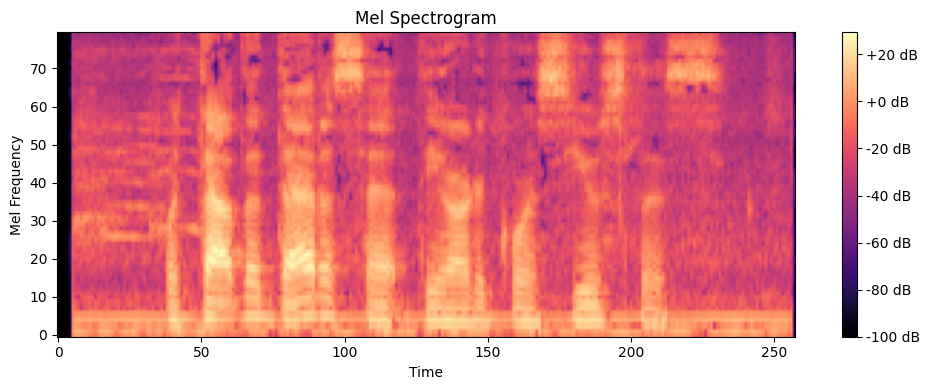

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Charger le mel spectrogramme sauvegardé au format .npy
mel_path = "/kaggle/working/mel_featuresTEST/sample-000000.npy"
mel_spectrogram = np.load(mel_path)

# Affichage avec matplotlib
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram, aspect='auto', origin='lower', cmap='magma')
plt.title("Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()


In [4]:
import torchaudio


In [5]:
import os
from pathlib import Path
import torch
import numpy as np
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import gc  # Gestion mémoire

# Répertoires
INPUT_DIR = Path("/kaggle/input/datasetbyme/mel_features/kaggle/working/mel_features")  # Dossier avec les Mel spectrogrammes existants
OUTPUT_DIR = Path("/kaggle/working/mel_features_normalized")  # Dossier où les fichiers normalisés seront sauvegardés
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

BATCH_SIZE = 5000  # Taille des lots (tu peux réduire si besoin)
SR = 16000
N_MELS = 80 
MAX_WORKERS = 4  # Nombre de workers pour ThreadPoolExecutor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === TRANSFORMATEURS GPU ===
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_mels=N_MELS
).to(device)

db_transform = torchaudio.transforms.AmplitudeToDB().to(device)

# === FONCTION DE NORMALISATION ===
def normalize_minmax_gpu(mel_db_tensor):
    """Normalisation Min-Max sur les Mel spectrogrammes sur GPU."""
    mel_min = mel_db_tensor.min()
    mel_max = mel_db_tensor.max()
    return (mel_db_tensor - mel_min) / (mel_max - mel_min + 1e-6)

# === FONCTION DE NORMALISATION DES FICHIERS ===
def normalize_mel_file_gpu(file_path):
    try:
        # Charger le Mel spectrogramme
        mel_db = np.load(file_path)
        mel_db_tensor = torch.tensor(mel_db, dtype=torch.float32, device=device)

        # Normalisation Min-Max sur GPU
        mel_db_normalized_tensor = normalize_minmax_gpu(mel_db_tensor)

        # Sauvegarder le Mel spectrogramme normalisé
        out_path = OUTPUT_DIR / file_path.name
        np.save(out_path, mel_db_normalized_tensor.cpu().numpy())  # Sauvegarde du fichier numpy normalisé

        return f"done:{file_path.name}"
    except Exception as e:
        return f"error:{file_path.name}:{str(e)}"

# === LISTE DES FICHIERS À TRAITER ===
all_files = sorted([f for f in INPUT_DIR.glob("*.npy")])  # On prend tous les fichiers .npy
print(f"Total fichiers à normaliser : {len(all_files)}")

# === NORMALISATION PAR BATCH AVEC THREADPOOLEXECUTOR ===
BATCH_SIZE = 1000  # Taille de batch optimisée pour le GPU

# Fonction pour traiter un lot de fichiers
def process_batch(batch_files):
    results = []
    for file in batch_files:
        result = normalize_mel_file_gpu(file)
        results.append(result)
    return results

# Traitement par batchs avec ThreadPoolExecutor
for i in range(0, len(all_files), BATCH_SIZE):
    batch_files = all_files[i:i+BATCH_SIZE]
    print(f"\nTraitement du batch {i//BATCH_SIZE + 1} : {len(batch_files)} fichiers")

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # Exécution parallèle des fichiers dans le batch
        batch_results = list(tqdm(executor.map(process_batch, [batch_files]), total=1))

    # Aplatir les résultats du batch
    flat_results = [item for sublist in batch_results for item in sublist]

    # Afficher les résultats
    for result in flat_results:
        print(result)

    # Nettoyage mémoire
    torch.cuda.empty_cache()
    gc.collect()


Total fichiers à normaliser : 92994

Traitement du batch 1 : 1000 fichiers


100%|██████████| 1/1 [00:08<00:00,  8.63s/it]


done:sample-000000.npy
done:sample-000001.npy
done:sample-000004.npy
done:sample-000006.npy
done:sample-000011.npy
done:sample-000020.npy
done:sample-000021.npy
done:sample-000022.npy
done:sample-000023.npy
done:sample-000024.npy
done:sample-000030.npy
done:sample-000031.npy
done:sample-000033.npy
done:sample-000034.npy
done:sample-000035.npy
done:sample-000039.npy
done:sample-000042.npy
done:sample-000044.npy
done:sample-000049.npy
done:sample-000052.npy
done:sample-000053.npy
done:sample-000054.npy
done:sample-000058.npy
done:sample-000061.npy
done:sample-000062.npy
done:sample-000063.npy
done:sample-000065.npy
done:sample-000070.npy
done:sample-000076.npy
done:sample-000077.npy
done:sample-000079.npy
done:sample-000080.npy
done:sample-000086.npy
done:sample-000089.npy
done:sample-000090.npy
done:sample-000091.npy
done:sample-000092.npy
done:sample-000095.npy
done:sample-000096.npy
done:sample-000097.npy
done:sample-000100.npy
done:sample-000101.npy
done:sample-000102.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.92s/it]


done:sample-002053.npy
done:sample-002054.npy
done:sample-002058.npy
done:sample-002060.npy
done:sample-002062.npy
done:sample-002068.npy
done:sample-002071.npy
done:sample-002072.npy
done:sample-002073.npy
done:sample-002076.npy
done:sample-002081.npy
done:sample-002084.npy
done:sample-002085.npy
done:sample-002086.npy
done:sample-002088.npy
done:sample-002091.npy
done:sample-002092.npy
done:sample-002096.npy
done:sample-002097.npy
done:sample-002098.npy
done:sample-002099.npy
done:sample-002103.npy
done:sample-002104.npy
done:sample-002105.npy
done:sample-002107.npy
done:sample-002108.npy
done:sample-002109.npy
done:sample-002110.npy
done:sample-002111.npy
done:sample-002113.npy
done:sample-002114.npy
done:sample-002115.npy
done:sample-002119.npy
done:sample-002122.npy
done:sample-002123.npy
done:sample-002124.npy
done:sample-002125.npy
done:sample-002130.npy
done:sample-002131.npy
done:sample-002132.npy
done:sample-002133.npy
done:sample-002136.npy
done:sample-002138.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.89s/it]


done:sample-004145.npy
done:sample-004147.npy
done:sample-004148.npy
done:sample-004149.npy
done:sample-004151.npy
done:sample-004154.npy
done:sample-004155.npy
done:sample-004157.npy
done:sample-004159.npy
done:sample-004160.npy
done:sample-004162.npy
done:sample-004166.npy
done:sample-004167.npy
done:sample-004168.npy
done:sample-004172.npy
done:sample-004174.npy
done:sample-004175.npy
done:sample-004178.npy
done:sample-004179.npy
done:sample-004181.npy
done:sample-004184.npy
done:sample-004186.npy
done:sample-004189.npy
done:sample-004190.npy
done:sample-004193.npy
done:sample-004194.npy
done:sample-004195.npy
done:sample-004196.npy
done:sample-004197.npy
done:sample-004198.npy
done:sample-004199.npy
done:sample-004202.npy
done:sample-004204.npy
done:sample-004205.npy
done:sample-004207.npy
done:sample-004210.npy
done:sample-004211.npy
done:sample-004212.npy
done:sample-004215.npy
done:sample-004216.npy
done:sample-004217.npy
done:sample-004218.npy
done:sample-004219.npy
done:sample

100%|██████████| 1/1 [00:08<00:00,  8.03s/it]


done:sample-006322.npy
done:sample-006323.npy
done:sample-006324.npy
done:sample-006329.npy
done:sample-006330.npy
done:sample-006332.npy
done:sample-006333.npy
done:sample-006334.npy
done:sample-006335.npy
done:sample-006337.npy
done:sample-006339.npy
done:sample-006340.npy
done:sample-006341.npy
done:sample-006342.npy
done:sample-006344.npy
done:sample-006345.npy
done:sample-006347.npy
done:sample-006348.npy
done:sample-006349.npy
done:sample-006351.npy
done:sample-006353.npy
done:sample-006354.npy
done:sample-006359.npy
done:sample-006360.npy
done:sample-006361.npy
done:sample-006362.npy
done:sample-006363.npy
done:sample-006367.npy
done:sample-006370.npy
done:sample-006372.npy
done:sample-006373.npy
done:sample-006378.npy
done:sample-006379.npy
done:sample-006380.npy
done:sample-006382.npy
done:sample-006383.npy
done:sample-006386.npy
done:sample-006388.npy
done:sample-006389.npy
done:sample-006391.npy
done:sample-006393.npy
done:sample-006394.npy
done:sample-006396.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.73s/it]


done:sample-008420.npy
done:sample-008421.npy
done:sample-008422.npy
done:sample-008423.npy
done:sample-008427.npy
done:sample-008428.npy
done:sample-008435.npy
done:sample-008437.npy
done:sample-008440.npy
done:sample-008442.npy
done:sample-008443.npy
done:sample-008444.npy
done:sample-008447.npy
done:sample-008449.npy
done:sample-008454.npy
done:sample-008457.npy
done:sample-008464.npy
done:sample-008465.npy
done:sample-008467.npy
done:sample-008468.npy
done:sample-008470.npy
done:sample-008472.npy
done:sample-008473.npy
done:sample-008474.npy
done:sample-008476.npy
done:sample-008477.npy
done:sample-008478.npy
done:sample-008479.npy
done:sample-008480.npy
done:sample-008482.npy
done:sample-008483.npy
done:sample-008486.npy
done:sample-008487.npy
done:sample-008488.npy
done:sample-008490.npy
done:sample-008492.npy
done:sample-008497.npy
done:sample-008503.npy
done:sample-008506.npy
done:sample-008509.npy
done:sample-008510.npy
done:sample-008514.npy
done:sample-008517.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.83s/it]


done:sample-010597.npy
done:sample-010605.npy
done:sample-010606.npy
done:sample-010609.npy
done:sample-010611.npy
done:sample-010612.npy
done:sample-010613.npy
done:sample-010615.npy
done:sample-010616.npy
done:sample-010617.npy
done:sample-010624.npy
done:sample-010626.npy
done:sample-010627.npy
done:sample-010628.npy
done:sample-010630.npy
done:sample-010631.npy
done:sample-010635.npy
done:sample-010639.npy
done:sample-010640.npy
done:sample-010641.npy
done:sample-010644.npy
done:sample-010645.npy
done:sample-010648.npy
done:sample-010649.npy
done:sample-010650.npy
done:sample-010653.npy
done:sample-010656.npy
done:sample-010658.npy
done:sample-010659.npy
done:sample-010664.npy
done:sample-010665.npy
done:sample-010666.npy
done:sample-010667.npy
done:sample-010668.npy
done:sample-010670.npy
done:sample-010671.npy
done:sample-010672.npy
done:sample-010673.npy
done:sample-010676.npy
done:sample-010678.npy
done:sample-010679.npy
done:sample-010682.npy
done:sample-010684.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.88s/it]


done:sample-012761.npy
done:sample-012762.npy
done:sample-012764.npy
done:sample-012765.npy
done:sample-012768.npy
done:sample-012769.npy
done:sample-012772.npy
done:sample-012773.npy
done:sample-012775.npy
done:sample-012776.npy
done:sample-012777.npy
done:sample-012781.npy
done:sample-012782.npy
done:sample-012786.npy
done:sample-012789.npy
done:sample-012791.npy
done:sample-012792.npy
done:sample-012794.npy
done:sample-012795.npy
done:sample-012797.npy
done:sample-012800.npy
done:sample-012804.npy
done:sample-012806.npy
done:sample-012807.npy
done:sample-012808.npy
done:sample-012813.npy
done:sample-012814.npy
done:sample-012816.npy
done:sample-012817.npy
done:sample-012821.npy
done:sample-012824.npy
done:sample-012825.npy
done:sample-012826.npy
done:sample-012827.npy
done:sample-012829.npy
done:sample-012831.npy
done:sample-012832.npy
done:sample-012835.npy
done:sample-012836.npy
done:sample-012837.npy
done:sample-012840.npy
done:sample-012844.npy
done:sample-012845.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.50s/it]


done:sample-014820.npy
done:sample-014821.npy
done:sample-014825.npy
done:sample-014826.npy
done:sample-014827.npy
done:sample-014829.npy
done:sample-014830.npy
done:sample-014831.npy
done:sample-014832.npy
done:sample-014839.npy
done:sample-014843.npy
done:sample-014844.npy
done:sample-014845.npy
done:sample-014846.npy
done:sample-014848.npy
done:sample-014851.npy
done:sample-014854.npy
done:sample-014856.npy
done:sample-014857.npy
done:sample-014861.npy
done:sample-014862.npy
done:sample-014863.npy
done:sample-014867.npy
done:sample-014868.npy
done:sample-014869.npy
done:sample-014870.npy
done:sample-014872.npy
done:sample-014873.npy
done:sample-014874.npy
done:sample-014876.npy
done:sample-014881.npy
done:sample-014882.npy
done:sample-014883.npy
done:sample-014887.npy
done:sample-014888.npy
done:sample-014889.npy
done:sample-014893.npy
done:sample-014894.npy
done:sample-014897.npy
done:sample-014899.npy
done:sample-014900.npy
done:sample-014902.npy
done:sample-014906.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.16s/it]


done:sample-016992.npy
done:sample-016993.npy
done:sample-016995.npy
done:sample-016998.npy
done:sample-017000.npy
done:sample-017001.npy
done:sample-017002.npy
done:sample-017003.npy
done:sample-017006.npy
done:sample-017007.npy
done:sample-017008.npy
done:sample-017009.npy
done:sample-017012.npy
done:sample-017018.npy
done:sample-017023.npy
done:sample-017024.npy
done:sample-017027.npy
done:sample-017029.npy
done:sample-017033.npy
done:sample-017037.npy
done:sample-017042.npy
done:sample-017043.npy
done:sample-017045.npy
done:sample-017049.npy
done:sample-017053.npy
done:sample-017054.npy
done:sample-017055.npy
done:sample-017056.npy
done:sample-017064.npy
done:sample-017065.npy
done:sample-017068.npy
done:sample-017070.npy
done:sample-017074.npy
done:sample-017075.npy
done:sample-017078.npy
done:sample-017081.npy
done:sample-017086.npy
done:sample-017088.npy
done:sample-017089.npy
done:sample-017090.npy
done:sample-017091.npy
done:sample-017094.npy
done:sample-017095.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.10s/it]


done:sample-019150.npy
done:sample-019151.npy
done:sample-019152.npy
done:sample-019155.npy
done:sample-019161.npy
done:sample-019165.npy
done:sample-019174.npy
done:sample-019175.npy
done:sample-019179.npy
done:sample-019181.npy
done:sample-019182.npy
done:sample-019183.npy
done:sample-019185.npy
done:sample-019186.npy
done:sample-019187.npy
done:sample-019194.npy
done:sample-019195.npy
done:sample-019200.npy
done:sample-019202.npy
done:sample-019203.npy
done:sample-019204.npy
done:sample-019205.npy
done:sample-019211.npy
done:sample-019212.npy
done:sample-019214.npy
done:sample-019216.npy
done:sample-019217.npy
done:sample-019218.npy
done:sample-019221.npy
done:sample-019233.npy
done:sample-019237.npy
done:sample-019240.npy
done:sample-019241.npy
done:sample-019242.npy
done:sample-019243.npy
done:sample-019244.npy
done:sample-019245.npy
done:sample-019248.npy
done:sample-019250.npy
done:sample-019254.npy
done:sample-019257.npy
done:sample-019260.npy
done:sample-019261.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.35s/it]


done:sample-021291.npy
done:sample-021295.npy
done:sample-021297.npy
done:sample-021298.npy
done:sample-021303.npy
done:sample-021304.npy
done:sample-021307.npy
done:sample-021308.npy
done:sample-021311.npy
done:sample-021313.npy
done:sample-021314.npy
done:sample-021317.npy
done:sample-021320.npy
done:sample-021321.npy
done:sample-021324.npy
done:sample-021326.npy
done:sample-021330.npy
done:sample-021332.npy
done:sample-021334.npy
done:sample-021336.npy
done:sample-021337.npy
done:sample-021343.npy
done:sample-021346.npy
done:sample-021349.npy
done:sample-021350.npy
done:sample-021351.npy
done:sample-021353.npy
done:sample-021355.npy
done:sample-021356.npy
done:sample-021358.npy
done:sample-021359.npy
done:sample-021361.npy
done:sample-021362.npy
done:sample-021363.npy
done:sample-021367.npy
done:sample-021368.npy
done:sample-021369.npy
done:sample-021370.npy
done:sample-021371.npy
done:sample-021372.npy
done:sample-021373.npy
done:sample-021375.npy
done:sample-021379.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.46s/it]


done:sample-023418.npy
done:sample-023420.npy
done:sample-023421.npy
done:sample-023425.npy
done:sample-023427.npy
done:sample-023433.npy
done:sample-023436.npy
done:sample-023440.npy
done:sample-023441.npy
done:sample-023442.npy
done:sample-023443.npy
done:sample-023444.npy
done:sample-023445.npy
done:sample-023447.npy
done:sample-023450.npy
done:sample-023451.npy
done:sample-023453.npy
done:sample-023455.npy
done:sample-023456.npy
done:sample-023458.npy
done:sample-023459.npy
done:sample-023460.npy
done:sample-023462.npy
done:sample-023463.npy
done:sample-023464.npy
done:sample-023465.npy
done:sample-023467.npy
done:sample-023469.npy
done:sample-023470.npy
done:sample-023474.npy
done:sample-023475.npy
done:sample-023476.npy
done:sample-023479.npy
done:sample-023480.npy
done:sample-023484.npy
done:sample-023485.npy
done:sample-023486.npy
done:sample-023487.npy
done:sample-023488.npy
done:sample-023489.npy
done:sample-023491.npy
done:sample-023492.npy
done:sample-023493.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.68s/it]


done:sample-025521.npy
done:sample-025522.npy
done:sample-025527.npy
done:sample-025529.npy
done:sample-025535.npy
done:sample-025536.npy
done:sample-025538.npy
done:sample-025539.npy
done:sample-025540.npy
done:sample-025541.npy
done:sample-025543.npy
done:sample-025546.npy
done:sample-025548.npy
done:sample-025553.npy
done:sample-025554.npy
done:sample-025555.npy
done:sample-025560.npy
done:sample-025564.npy
done:sample-025567.npy
done:sample-025568.npy
done:sample-025572.npy
done:sample-025573.npy
done:sample-025574.npy
done:sample-025575.npy
done:sample-025578.npy
done:sample-025580.npy
done:sample-025582.npy
done:sample-025584.npy
done:sample-025585.npy
done:sample-025586.npy
done:sample-025587.npy
done:sample-025589.npy
done:sample-025590.npy
done:sample-025591.npy
done:sample-025593.npy
done:sample-025599.npy
done:sample-025601.npy
done:sample-025603.npy
done:sample-025606.npy
done:sample-025610.npy
done:sample-025611.npy
done:sample-025614.npy
done:sample-025616.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.68s/it]


done:sample-027674.npy
done:sample-027680.npy
done:sample-027681.npy
done:sample-027686.npy
done:sample-027687.npy
done:sample-027688.npy
done:sample-027691.npy
done:sample-027693.npy
done:sample-027695.npy
done:sample-027697.npy
done:sample-027698.npy
done:sample-027700.npy
done:sample-027703.npy
done:sample-027707.npy
done:sample-027709.npy
done:sample-027713.npy
done:sample-027717.npy
done:sample-027718.npy
done:sample-027719.npy
done:sample-027720.npy
done:sample-027721.npy
done:sample-027724.npy
done:sample-027725.npy
done:sample-027726.npy
done:sample-027727.npy
done:sample-027731.npy
done:sample-027733.npy
done:sample-027735.npy
done:sample-027741.npy
done:sample-027742.npy
done:sample-027743.npy
done:sample-027744.npy
done:sample-027745.npy
done:sample-027748.npy
done:sample-027750.npy
done:sample-027751.npy
done:sample-027756.npy
done:sample-027758.npy
done:sample-027759.npy
done:sample-027760.npy
done:sample-027761.npy
done:sample-027767.npy
done:sample-027768.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.38s/it]


done:sample-029746.npy
done:sample-029747.npy
done:sample-029748.npy
done:sample-029749.npy
done:sample-029750.npy
done:sample-029751.npy
done:sample-029752.npy
done:sample-029753.npy
done:sample-029754.npy
done:sample-029755.npy
done:sample-029758.npy
done:sample-029759.npy
done:sample-029760.npy
done:sample-029761.npy
done:sample-029762.npy
done:sample-029763.npy
done:sample-029766.npy
done:sample-029769.npy
done:sample-029771.npy
done:sample-029772.npy
done:sample-029773.npy
done:sample-029774.npy
done:sample-029776.npy
done:sample-029781.npy
done:sample-029783.npy
done:sample-029786.npy
done:sample-029787.npy
done:sample-029788.npy
done:sample-029789.npy
done:sample-029798.npy
done:sample-029801.npy
done:sample-029803.npy
done:sample-029807.npy
done:sample-029809.npy
done:sample-029814.npy
done:sample-029815.npy
done:sample-029816.npy
done:sample-029820.npy
done:sample-029823.npy
done:sample-029824.npy
done:sample-029826.npy
done:sample-029827.npy
done:sample-029828.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.10s/it]


done:sample-031691.npy
done:sample-031692.npy
done:sample-031702.npy
done:sample-031708.npy
done:sample-031710.npy
done:sample-031714.npy
done:sample-031719.npy
done:sample-031721.npy
done:sample-031724.npy
done:sample-031726.npy
done:sample-031729.npy
done:sample-031730.npy
done:sample-031731.npy
done:sample-031732.npy
done:sample-031734.npy
done:sample-031735.npy
done:sample-031737.npy
done:sample-031738.npy
done:sample-031739.npy
done:sample-031742.npy
done:sample-031743.npy
done:sample-031744.npy
done:sample-031746.npy
done:sample-031747.npy
done:sample-031749.npy
done:sample-031754.npy
done:sample-031755.npy
done:sample-031758.npy
done:sample-031759.npy
done:sample-031761.npy
done:sample-031762.npy
done:sample-031763.npy
done:sample-031767.npy
done:sample-031768.npy
done:sample-031769.npy
done:sample-031773.npy
done:sample-031774.npy
done:sample-031776.npy
done:sample-031777.npy
done:sample-031782.npy
done:sample-031784.npy
done:sample-031787.npy
done:sample-031788.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.01s/it]


done:sample-033781.npy
done:sample-033784.npy
done:sample-033788.npy
done:sample-033789.npy
done:sample-033791.npy
done:sample-033801.npy
done:sample-033802.npy
done:sample-033803.npy
done:sample-033804.npy
done:sample-033805.npy
done:sample-033806.npy
done:sample-033810.npy
done:sample-033811.npy
done:sample-033813.npy
done:sample-033817.npy
done:sample-033819.npy
done:sample-033820.npy
done:sample-033824.npy
done:sample-033825.npy
done:sample-033827.npy
done:sample-033831.npy
done:sample-033833.npy
done:sample-033834.npy
done:sample-033836.npy
done:sample-033838.npy
done:sample-033840.npy
done:sample-033844.npy
done:sample-033847.npy
done:sample-033852.npy
done:sample-033854.npy
done:sample-033855.npy
done:sample-033858.npy
done:sample-033860.npy
done:sample-033861.npy
done:sample-033863.npy
done:sample-033865.npy
done:sample-033869.npy
done:sample-033873.npy
done:sample-033874.npy
done:sample-033877.npy
done:sample-033878.npy
done:sample-033879.npy
done:sample-033880.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.73s/it]


done:sample-035839.npy
done:sample-035843.npy
done:sample-035844.npy
done:sample-035846.npy
done:sample-035849.npy
done:sample-035853.npy
done:sample-035854.npy
done:sample-035855.npy
done:sample-035856.npy
done:sample-035857.npy
done:sample-035858.npy
done:sample-035859.npy
done:sample-035861.npy
done:sample-035866.npy
done:sample-035870.npy
done:sample-035871.npy
done:sample-035872.npy
done:sample-035873.npy
done:sample-035875.npy
done:sample-035879.npy
done:sample-035880.npy
done:sample-035881.npy
done:sample-035882.npy
done:sample-035888.npy
done:sample-035889.npy
done:sample-035893.npy
done:sample-035895.npy
done:sample-035898.npy
done:sample-035900.npy
done:sample-035901.npy
done:sample-035905.npy
done:sample-035906.npy
done:sample-035907.npy
done:sample-035908.npy
done:sample-035909.npy
done:sample-035910.npy
done:sample-035912.npy
done:sample-035914.npy
done:sample-035918.npy
done:sample-035923.npy
done:sample-035924.npy
done:sample-035926.npy
done:sample-035928.npy
done:sample

100%|██████████| 1/1 [00:09<00:00,  9.14s/it]


done:sample-037882.npy
done:sample-037883.npy
done:sample-037884.npy
done:sample-037885.npy
done:sample-037886.npy
done:sample-037887.npy
done:sample-037889.npy
done:sample-037892.npy
done:sample-037894.npy
done:sample-037895.npy
done:sample-037897.npy
done:sample-037898.npy
done:sample-037899.npy
done:sample-037900.npy
done:sample-037902.npy
done:sample-037904.npy
done:sample-037906.npy
done:sample-037908.npy
done:sample-037910.npy
done:sample-037911.npy
done:sample-037913.npy
done:sample-037914.npy
done:sample-037915.npy
done:sample-037918.npy
done:sample-037920.npy
done:sample-037922.npy
done:sample-037925.npy
done:sample-037926.npy
done:sample-037927.npy
done:sample-037931.npy
done:sample-037933.npy
done:sample-037935.npy
done:sample-037936.npy
done:sample-037937.npy
done:sample-037938.npy
done:sample-037940.npy
done:sample-037942.npy
done:sample-037943.npy
done:sample-037944.npy
done:sample-037946.npy
done:sample-037949.npy
done:sample-037951.npy
done:sample-037952.npy
done:sample

100%|██████████| 1/1 [00:09<00:00,  9.27s/it]


done:sample-040011.npy
done:sample-040012.npy
done:sample-040013.npy
done:sample-040014.npy
done:sample-040015.npy
done:sample-040016.npy
done:sample-040019.npy
done:sample-040026.npy
done:sample-040029.npy
done:sample-040031.npy
done:sample-040032.npy
done:sample-040034.npy
done:sample-040038.npy
done:sample-040040.npy
done:sample-040041.npy
done:sample-040044.npy
done:sample-040045.npy
done:sample-040047.npy
done:sample-040048.npy
done:sample-040049.npy
done:sample-040050.npy
done:sample-040051.npy
done:sample-040052.npy
done:sample-040053.npy
done:sample-040054.npy
done:sample-040055.npy
done:sample-040056.npy
done:sample-040057.npy
done:sample-040060.npy
done:sample-040061.npy
done:sample-040062.npy
done:sample-040065.npy
done:sample-040066.npy
done:sample-040067.npy
done:sample-040069.npy
done:sample-040075.npy
done:sample-040076.npy
done:sample-040081.npy
done:sample-040082.npy
done:sample-040083.npy
done:sample-040084.npy
done:sample-040087.npy
done:sample-040090.npy
done:sample

100%|██████████| 1/1 [00:08<00:00,  8.36s/it]


done:sample-042112.npy
done:sample-042114.npy
done:sample-042116.npy
done:sample-042117.npy
done:sample-042118.npy
done:sample-042119.npy
done:sample-042121.npy
done:sample-042122.npy
done:sample-042123.npy
done:sample-042126.npy
done:sample-042127.npy
done:sample-042128.npy
done:sample-042130.npy
done:sample-042138.npy
done:sample-042139.npy
done:sample-042141.npy
done:sample-042142.npy
done:sample-042143.npy
done:sample-042149.npy
done:sample-042151.npy
done:sample-042152.npy
done:sample-042153.npy
done:sample-042156.npy
done:sample-042157.npy
done:sample-042159.npy
done:sample-042160.npy
done:sample-042161.npy
done:sample-042162.npy
done:sample-042163.npy
done:sample-042165.npy
done:sample-042166.npy
done:sample-042167.npy
done:sample-042168.npy
done:sample-042172.npy
done:sample-042173.npy
done:sample-042181.npy
done:sample-042182.npy
done:sample-042185.npy
done:sample-042188.npy
done:sample-042194.npy
done:sample-042196.npy
done:sample-042197.npy
done:sample-042198.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.99s/it]


done:sample-044198.npy
done:sample-044201.npy
done:sample-044203.npy
done:sample-044205.npy
done:sample-044206.npy
done:sample-044207.npy
done:sample-044208.npy
done:sample-044212.npy
done:sample-044218.npy
done:sample-044219.npy
done:sample-044223.npy
done:sample-044224.npy
done:sample-044226.npy
done:sample-044229.npy
done:sample-044230.npy
done:sample-044231.npy
done:sample-044232.npy
done:sample-044234.npy
done:sample-044236.npy
done:sample-044240.npy
done:sample-044242.npy
done:sample-044243.npy
done:sample-044244.npy
done:sample-044245.npy
done:sample-044249.npy
done:sample-044251.npy
done:sample-044255.npy
done:sample-044256.npy
done:sample-044257.npy
done:sample-044260.npy
done:sample-044266.npy
done:sample-044267.npy
done:sample-044270.npy
done:sample-044271.npy
done:sample-044272.npy
done:sample-044274.npy
done:sample-044277.npy
done:sample-044283.npy
done:sample-044284.npy
done:sample-044287.npy
done:sample-044288.npy
done:sample-044289.npy
done:sample-044290.npy
done:sample

100%|██████████| 1/1 [00:08<00:00,  8.02s/it]


done:sample-046341.npy
done:sample-046342.npy
done:sample-046345.npy
done:sample-046346.npy
done:sample-046347.npy
done:sample-046348.npy
done:sample-046349.npy
done:sample-046351.npy
done:sample-046353.npy
done:sample-046354.npy
done:sample-046355.npy
done:sample-046357.npy
done:sample-046359.npy
done:sample-046362.npy
done:sample-046363.npy
done:sample-046367.npy
done:sample-046368.npy
done:sample-046370.npy
done:sample-046372.npy
done:sample-046373.npy
done:sample-046374.npy
done:sample-046377.npy
done:sample-046380.npy
done:sample-046382.npy
done:sample-046383.npy
done:sample-046384.npy
done:sample-046385.npy
done:sample-046387.npy
done:sample-046391.npy
done:sample-046392.npy
done:sample-046393.npy
done:sample-046394.npy
done:sample-046395.npy
done:sample-046396.npy
done:sample-046397.npy
done:sample-046398.npy
done:sample-046399.npy
done:sample-046400.npy
done:sample-046401.npy
done:sample-046405.npy
done:sample-046407.npy
done:sample-046409.npy
done:sample-046410.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.50s/it]


done:sample-048471.npy
done:sample-048472.npy
done:sample-048474.npy
done:sample-048476.npy
done:sample-048477.npy
done:sample-048479.npy
done:sample-048480.npy
done:sample-048482.npy
done:sample-048487.npy
done:sample-048490.npy
done:sample-048491.npy
done:sample-048494.npy
done:sample-048496.npy
done:sample-048497.npy
done:sample-048501.npy
done:sample-048502.npy
done:sample-048508.npy
done:sample-048509.npy
done:sample-048510.npy
done:sample-048514.npy
done:sample-048516.npy
done:sample-048518.npy
done:sample-048520.npy
done:sample-048521.npy
done:sample-048522.npy
done:sample-048523.npy
done:sample-048524.npy
done:sample-048525.npy
done:sample-048540.npy
done:sample-048541.npy
done:sample-048543.npy
done:sample-048546.npy
done:sample-048549.npy
done:sample-048550.npy
done:sample-048551.npy
done:sample-048552.npy
done:sample-048557.npy
done:sample-048558.npy
done:sample-048559.npy
done:sample-048563.npy
done:sample-048565.npy
done:sample-048567.npy
done:sample-048568.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.68s/it]


done:sample-050628.npy
done:sample-050630.npy
done:sample-050631.npy
done:sample-050632.npy
done:sample-050633.npy
done:sample-050634.npy
done:sample-050635.npy
done:sample-050638.npy
done:sample-050639.npy
done:sample-050640.npy
done:sample-050642.npy
done:sample-050643.npy
done:sample-050644.npy
done:sample-050645.npy
done:sample-050646.npy
done:sample-050649.npy
done:sample-050651.npy
done:sample-050655.npy
done:sample-050656.npy
done:sample-050660.npy
done:sample-050661.npy
done:sample-050662.npy
done:sample-050663.npy
done:sample-050666.npy
done:sample-050667.npy
done:sample-050668.npy
done:sample-050671.npy
done:sample-050672.npy
done:sample-050673.npy
done:sample-050674.npy
done:sample-050675.npy
done:sample-050679.npy
done:sample-050680.npy
done:sample-050681.npy
done:sample-050685.npy
done:sample-050688.npy
done:sample-050689.npy
done:sample-050690.npy
done:sample-050691.npy
done:sample-050692.npy
done:sample-050696.npy
done:sample-050698.npy
done:sample-050699.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.50s/it]


done:sample-052787.npy
done:sample-052789.npy
done:sample-052792.npy
done:sample-052795.npy
done:sample-052796.npy
done:sample-052805.npy
done:sample-052806.npy
done:sample-052808.npy
done:sample-052809.npy
done:sample-052811.npy
done:sample-052815.npy
done:sample-052816.npy
done:sample-052820.npy
done:sample-052821.npy
done:sample-052826.npy
done:sample-052831.npy
done:sample-052833.npy
done:sample-052834.npy
done:sample-052836.npy
done:sample-052840.npy
done:sample-052841.npy
done:sample-052845.npy
done:sample-052846.npy
done:sample-052849.npy
done:sample-052850.npy
done:sample-052851.npy
done:sample-052852.npy
done:sample-052854.npy
done:sample-052855.npy
done:sample-052856.npy
done:sample-052859.npy
done:sample-052863.npy
done:sample-052865.npy
done:sample-052866.npy
done:sample-052867.npy
done:sample-052868.npy
done:sample-052869.npy
done:sample-052871.npy
done:sample-052873.npy
done:sample-052875.npy
done:sample-052878.npy
done:sample-052880.npy
done:sample-052881.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.74s/it]


done:sample-054873.npy
done:sample-054874.npy
done:sample-054876.npy
done:sample-054878.npy
done:sample-054880.npy
done:sample-054884.npy
done:sample-054889.npy
done:sample-054893.npy
done:sample-054894.npy
done:sample-054897.npy
done:sample-054899.npy
done:sample-054903.npy
done:sample-054908.npy
done:sample-054910.npy
done:sample-054916.npy
done:sample-054919.npy
done:sample-054921.npy
done:sample-054923.npy
done:sample-054931.npy
done:sample-054937.npy
done:sample-054942.npy
done:sample-054944.npy
done:sample-054945.npy
done:sample-054948.npy
done:sample-054950.npy
done:sample-054951.npy
done:sample-054953.npy
done:sample-054955.npy
done:sample-054957.npy
done:sample-054958.npy
done:sample-054959.npy
done:sample-054960.npy
done:sample-054961.npy
done:sample-054963.npy
done:sample-054965.npy
done:sample-054972.npy
done:sample-054976.npy
done:sample-054982.npy
done:sample-054983.npy
done:sample-054984.npy
done:sample-054988.npy
done:sample-054989.npy
done:sample-054990.npy
done:sample

100%|██████████| 1/1 [00:08<00:00,  8.31s/it]


done:sample-057093.npy
done:sample-057094.npy
done:sample-057096.npy
done:sample-057097.npy
done:sample-057098.npy
done:sample-057100.npy
done:sample-057101.npy
done:sample-057102.npy
done:sample-057105.npy
done:sample-057106.npy
done:sample-057107.npy
done:sample-057111.npy
done:sample-057112.npy
done:sample-057114.npy
done:sample-057116.npy
done:sample-057122.npy
done:sample-057123.npy
done:sample-057126.npy
done:sample-057127.npy
done:sample-057129.npy
done:sample-057130.npy
done:sample-057131.npy
done:sample-057136.npy
done:sample-057137.npy
done:sample-057138.npy
done:sample-057140.npy
done:sample-057142.npy
done:sample-057144.npy
done:sample-057145.npy
done:sample-057150.npy
done:sample-057156.npy
done:sample-057159.npy
done:sample-057160.npy
done:sample-057161.npy
done:sample-057162.npy
done:sample-057164.npy
done:sample-057165.npy
done:sample-057166.npy
done:sample-057171.npy
done:sample-057177.npy
done:sample-057178.npy
done:sample-057180.npy
done:sample-057181.npy
done:sample

100%|██████████| 1/1 [00:08<00:00,  8.21s/it]


done:sample-059245.npy
done:sample-059249.npy
done:sample-059250.npy
done:sample-059254.npy
done:sample-059255.npy
done:sample-059259.npy
done:sample-059260.npy
done:sample-059262.npy
done:sample-059266.npy
done:sample-059268.npy
done:sample-059271.npy
done:sample-059272.npy
done:sample-059276.npy
done:sample-059277.npy
done:sample-059279.npy
done:sample-059280.npy
done:sample-059281.npy
done:sample-059282.npy
done:sample-059283.npy
done:sample-059284.npy
done:sample-059285.npy
done:sample-059286.npy
done:sample-059288.npy
done:sample-059292.npy
done:sample-059294.npy
done:sample-059296.npy
done:sample-059297.npy
done:sample-059298.npy
done:sample-059300.npy
done:sample-059301.npy
done:sample-059304.npy
done:sample-059306.npy
done:sample-059307.npy
done:sample-059308.npy
done:sample-059310.npy
done:sample-059315.npy
done:sample-059316.npy
done:sample-059318.npy
done:sample-059324.npy
done:sample-059326.npy
done:sample-059329.npy
done:sample-059333.npy
done:sample-059334.npy
done:sample

100%|██████████| 1/1 [00:08<00:00,  8.06s/it]


done:sample-061306.npy
done:sample-061307.npy
done:sample-061310.npy
done:sample-061313.npy
done:sample-061315.npy
done:sample-061325.npy
done:sample-061328.npy
done:sample-061333.npy
done:sample-061335.npy
done:sample-061339.npy
done:sample-061341.npy
done:sample-061342.npy
done:sample-061343.npy
done:sample-061344.npy
done:sample-061345.npy
done:sample-061349.npy
done:sample-061352.npy
done:sample-061355.npy
done:sample-061359.npy
done:sample-061361.npy
done:sample-061364.npy
done:sample-061365.npy
done:sample-061366.npy
done:sample-061369.npy
done:sample-061370.npy
done:sample-061371.npy
done:sample-061372.npy
done:sample-061375.npy
done:sample-061376.npy
done:sample-061379.npy
done:sample-061380.npy
done:sample-061381.npy
done:sample-061382.npy
done:sample-061383.npy
done:sample-061384.npy
done:sample-061385.npy
done:sample-061386.npy
done:sample-061387.npy
done:sample-061389.npy
done:sample-061390.npy
done:sample-061391.npy
done:sample-061392.npy
done:sample-061395.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.63s/it]


done:sample-063432.npy
done:sample-063433.npy
done:sample-063434.npy
done:sample-063437.npy
done:sample-063439.npy
done:sample-063440.npy
done:sample-063441.npy
done:sample-063443.npy
done:sample-063445.npy
done:sample-063450.npy
done:sample-063451.npy
done:sample-063453.npy
done:sample-063454.npy
done:sample-063457.npy
done:sample-063458.npy
done:sample-063459.npy
done:sample-063460.npy
done:sample-063461.npy
done:sample-063462.npy
done:sample-063466.npy
done:sample-063467.npy
done:sample-063473.npy
done:sample-063476.npy
done:sample-063480.npy
done:sample-063481.npy
done:sample-063482.npy
done:sample-063483.npy
done:sample-063484.npy
done:sample-063485.npy
done:sample-063487.npy
done:sample-063488.npy
done:sample-063489.npy
done:sample-063490.npy
done:sample-063494.npy
done:sample-063495.npy
done:sample-063498.npy
done:sample-063500.npy
done:sample-063501.npy
done:sample-063502.npy
done:sample-063504.npy
done:sample-063508.npy
done:sample-063509.npy
done:sample-063513.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.68s/it]


done:sample-065505.npy
done:sample-065507.npy
done:sample-065513.npy
done:sample-065515.npy
done:sample-065518.npy
done:sample-065519.npy
done:sample-065520.npy
done:sample-065521.npy
done:sample-065522.npy
done:sample-065523.npy
done:sample-065525.npy
done:sample-065528.npy
done:sample-065529.npy
done:sample-065530.npy
done:sample-065534.npy
done:sample-065538.npy
done:sample-065539.npy
done:sample-065541.npy
done:sample-065543.npy
done:sample-065544.npy
done:sample-065546.npy
done:sample-065551.npy
done:sample-065556.npy
done:sample-065557.npy
done:sample-065558.npy
done:sample-065559.npy
done:sample-065561.npy
done:sample-065562.npy
done:sample-065569.npy
done:sample-065571.npy
done:sample-065574.npy
done:sample-065575.npy
done:sample-065576.npy
done:sample-065577.npy
done:sample-065578.npy
done:sample-065579.npy
done:sample-065582.npy
done:sample-065586.npy
done:sample-065593.npy
done:sample-065594.npy
done:sample-065595.npy
done:sample-065596.npy
done:sample-065598.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.45s/it]


done:sample-067622.npy
done:sample-067623.npy
done:sample-067624.npy
done:sample-067625.npy
done:sample-067630.npy
done:sample-067631.npy
done:sample-067633.npy
done:sample-067634.npy
done:sample-067636.npy
done:sample-067640.npy
done:sample-067641.npy
done:sample-067643.npy
done:sample-067646.npy
done:sample-067651.npy
done:sample-067665.npy
done:sample-067668.npy
done:sample-067671.npy
done:sample-067672.npy
done:sample-067674.npy
done:sample-067675.npy
done:sample-067676.npy
done:sample-067678.npy
done:sample-067679.npy
done:sample-067680.npy
done:sample-067681.npy
done:sample-067682.npy
done:sample-067684.npy
done:sample-067686.npy
done:sample-067688.npy
done:sample-067689.npy
done:sample-067691.npy
done:sample-067693.npy
done:sample-067694.npy
done:sample-067697.npy
done:sample-067699.npy
done:sample-067700.npy
done:sample-067701.npy
done:sample-067702.npy
done:sample-067704.npy
done:sample-067706.npy
done:sample-067707.npy
done:sample-067709.npy
done:sample-067710.npy
done:sample

100%|██████████| 1/1 [00:08<00:00,  8.59s/it]


done:sample-069711.npy
done:sample-069712.npy
done:sample-069714.npy
done:sample-069716.npy
done:sample-069718.npy
done:sample-069722.npy
done:sample-069723.npy
done:sample-069725.npy
done:sample-069729.npy
done:sample-069731.npy
done:sample-069732.npy
done:sample-069733.npy
done:sample-069738.npy
done:sample-069740.npy
done:sample-069742.npy
done:sample-069746.npy
done:sample-069749.npy
done:sample-069750.npy
done:sample-069751.npy
done:sample-069754.npy
done:sample-069757.npy
done:sample-069758.npy
done:sample-069759.npy
done:sample-069761.npy
done:sample-069762.npy
done:sample-069763.npy
done:sample-069766.npy
done:sample-069768.npy
done:sample-069772.npy
done:sample-069773.npy
done:sample-069774.npy
done:sample-069775.npy
done:sample-069777.npy
done:sample-069779.npy
done:sample-069780.npy
done:sample-069782.npy
done:sample-069786.npy
done:sample-069789.npy
done:sample-069790.npy
done:sample-069791.npy
done:sample-069795.npy
done:sample-069796.npy
done:sample-069801.npy
done:sample

100%|██████████| 1/1 [00:09<00:00,  9.20s/it]


done:sample-071757.npy
done:sample-071759.npy
done:sample-071760.npy
done:sample-071761.npy
done:sample-071763.npy
done:sample-071764.npy
done:sample-071765.npy
done:sample-071766.npy
done:sample-071767.npy
done:sample-071768.npy
done:sample-071769.npy
done:sample-071770.npy
done:sample-071771.npy
done:sample-071774.npy
done:sample-071777.npy
done:sample-071781.npy
done:sample-071783.npy
done:sample-071784.npy
done:sample-071785.npy
done:sample-071787.npy
done:sample-071788.npy
done:sample-071794.npy
done:sample-071795.npy
done:sample-071797.npy
done:sample-071798.npy
done:sample-071801.npy
done:sample-071802.npy
done:sample-071803.npy
done:sample-071804.npy
done:sample-071806.npy
done:sample-071808.npy
done:sample-071809.npy
done:sample-071814.npy
done:sample-071821.npy
done:sample-071822.npy
done:sample-071823.npy
done:sample-071824.npy
done:sample-071826.npy
done:sample-071828.npy
done:sample-071830.npy
done:sample-071832.npy
done:sample-071837.npy
done:sample-071838.npy
done:sample

100%|██████████| 1/1 [00:08<00:00,  8.13s/it]


done:sample-073789.npy
done:sample-073792.npy
done:sample-073793.npy
done:sample-073799.npy
done:sample-073800.npy
done:sample-073802.npy
done:sample-073804.npy
done:sample-073806.npy
done:sample-073808.npy
done:sample-073811.npy
done:sample-073812.npy
done:sample-073813.npy
done:sample-073814.npy
done:sample-073816.npy
done:sample-073817.npy
done:sample-073818.npy
done:sample-073819.npy
done:sample-073821.npy
done:sample-073822.npy
done:sample-073823.npy
done:sample-073824.npy
done:sample-073825.npy
done:sample-073826.npy
done:sample-073828.npy
done:sample-073831.npy
done:sample-073832.npy
done:sample-073833.npy
done:sample-073835.npy
done:sample-073838.npy
done:sample-073840.npy
done:sample-073842.npy
done:sample-073843.npy
done:sample-073846.npy
done:sample-073854.npy
done:sample-073857.npy
done:sample-073858.npy
done:sample-073862.npy
done:sample-073864.npy
done:sample-073871.npy
done:sample-073875.npy
done:sample-073877.npy
done:sample-073878.npy
done:sample-073880.npy
done:sample

100%|██████████| 1/1 [00:08<00:00,  8.02s/it]


done:sample-075902.npy
done:sample-075903.npy
done:sample-075904.npy
done:sample-075905.npy
done:sample-075906.npy
done:sample-075908.npy
done:sample-075915.npy
done:sample-075916.npy
done:sample-075918.npy
done:sample-075929.npy
done:sample-075935.npy
done:sample-075936.npy
done:sample-075938.npy
done:sample-075941.npy
done:sample-075942.npy
done:sample-075943.npy
done:sample-075944.npy
done:sample-075953.npy
done:sample-075954.npy
done:sample-075958.npy
done:sample-075959.npy
done:sample-075960.npy
done:sample-075963.npy
done:sample-075967.npy
done:sample-075968.npy
done:sample-075970.npy
done:sample-075971.npy
done:sample-075972.npy
done:sample-075977.npy
done:sample-075979.npy
done:sample-075983.npy
done:sample-075987.npy
done:sample-075988.npy
done:sample-075989.npy
done:sample-075991.npy
done:sample-075994.npy
done:sample-075996.npy
done:sample-075998.npy
done:sample-075999.npy
done:sample-076001.npy
done:sample-076002.npy
done:sample-076006.npy
done:sample-076007.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.52s/it]


done:sample-078061.npy
done:sample-078064.npy
done:sample-078065.npy
done:sample-078067.npy
done:sample-078069.npy
done:sample-078072.npy
done:sample-078073.npy
done:sample-078075.npy
done:sample-078078.npy
done:sample-078081.npy
done:sample-078083.npy
done:sample-078084.npy
done:sample-078086.npy
done:sample-078087.npy
done:sample-078089.npy
done:sample-078090.npy
done:sample-078091.npy
done:sample-078092.npy
done:sample-078093.npy
done:sample-078094.npy
done:sample-078095.npy
done:sample-078096.npy
done:sample-078099.npy
done:sample-078100.npy
done:sample-078103.npy
done:sample-078104.npy
done:sample-078108.npy
done:sample-078109.npy
done:sample-078112.npy
done:sample-078114.npy
done:sample-078115.npy
done:sample-078120.npy
done:sample-078122.npy
done:sample-078123.npy
done:sample-078124.npy
done:sample-078125.npy
done:sample-078127.npy
done:sample-078135.npy
done:sample-078136.npy
done:sample-078139.npy
done:sample-078141.npy
done:sample-078143.npy
done:sample-078144.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.26s/it]


done:sample-080122.npy
done:sample-080124.npy
done:sample-080127.npy
done:sample-080130.npy
done:sample-080132.npy
done:sample-080133.npy
done:sample-080134.npy
done:sample-080137.npy
done:sample-080138.npy
done:sample-080139.npy
done:sample-080142.npy
done:sample-080143.npy
done:sample-080144.npy
done:sample-080147.npy
done:sample-080148.npy
done:sample-080149.npy
done:sample-080150.npy
done:sample-080151.npy
done:sample-080153.npy
done:sample-080157.npy
done:sample-080158.npy
done:sample-080160.npy
done:sample-080167.npy
done:sample-080170.npy
done:sample-080172.npy
done:sample-080176.npy
done:sample-080178.npy
done:sample-080180.npy
done:sample-080185.npy
done:sample-080186.npy
done:sample-080187.npy
done:sample-080189.npy
done:sample-080191.npy
done:sample-080193.npy
done:sample-080194.npy
done:sample-080200.npy
done:sample-080204.npy
done:sample-080205.npy
done:sample-080207.npy
done:sample-080208.npy
done:sample-080210.npy
done:sample-080213.npy
done:sample-080216.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.58s/it]


done:sample-082247.npy
done:sample-082249.npy
done:sample-082250.npy
done:sample-082251.npy
done:sample-082252.npy
done:sample-082254.npy
done:sample-082255.npy
done:sample-082258.npy
done:sample-082259.npy
done:sample-082261.npy
done:sample-082262.npy
done:sample-082264.npy
done:sample-082269.npy
done:sample-082270.npy
done:sample-082271.npy
done:sample-082274.npy
done:sample-082275.npy
done:sample-082280.npy
done:sample-082281.npy
done:sample-082283.npy
done:sample-082284.npy
done:sample-082286.npy
done:sample-082290.npy
done:sample-082291.npy
done:sample-082292.npy
done:sample-082294.npy
done:sample-082296.npy
done:sample-082301.npy
done:sample-082305.npy
done:sample-082308.npy
done:sample-082310.npy
done:sample-082311.npy
done:sample-082313.npy
done:sample-082314.npy
done:sample-082316.npy
done:sample-082319.npy
done:sample-082320.npy
done:sample-082321.npy
done:sample-082323.npy
done:sample-082324.npy
done:sample-082326.npy
done:sample-082329.npy
done:sample-082330.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.81s/it]


done:sample-084320.npy
done:sample-084323.npy
done:sample-084324.npy
done:sample-084326.npy
done:sample-084327.npy
done:sample-084328.npy
done:sample-084331.npy
done:sample-084332.npy
done:sample-084333.npy
done:sample-084334.npy
done:sample-084341.npy
done:sample-084342.npy
done:sample-084343.npy
done:sample-084344.npy
done:sample-084345.npy
done:sample-084347.npy
done:sample-084348.npy
done:sample-084349.npy
done:sample-084350.npy
done:sample-084352.npy
done:sample-084354.npy
done:sample-084356.npy
done:sample-084359.npy
done:sample-084362.npy
done:sample-084364.npy
done:sample-084365.npy
done:sample-084367.npy
done:sample-084368.npy
done:sample-084370.npy
done:sample-084372.npy
done:sample-084374.npy
done:sample-084375.npy
done:sample-084376.npy
done:sample-084378.npy
done:sample-084379.npy
done:sample-084380.npy
done:sample-084382.npy
done:sample-084385.npy
done:sample-084386.npy
done:sample-084387.npy
done:sample-084397.npy
done:sample-084398.npy
done:sample-084400.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.95s/it]


done:sample-086435.npy
done:sample-086438.npy
done:sample-086440.npy
done:sample-086443.npy
done:sample-086444.npy
done:sample-086445.npy
done:sample-086446.npy
done:sample-086451.npy
done:sample-086452.npy
done:sample-086455.npy
done:sample-086456.npy
done:sample-086457.npy
done:sample-086459.npy
done:sample-086460.npy
done:sample-086461.npy
done:sample-086464.npy
done:sample-086466.npy
done:sample-086469.npy
done:sample-086470.npy
done:sample-086471.npy
done:sample-086480.npy
done:sample-086482.npy
done:sample-086485.npy
done:sample-086493.npy
done:sample-086494.npy
done:sample-086495.npy
done:sample-086498.npy
done:sample-086500.npy
done:sample-086503.npy
done:sample-086505.npy
done:sample-086506.npy
done:sample-086507.npy
done:sample-086508.npy
done:sample-086512.npy
done:sample-086514.npy
done:sample-086517.npy
done:sample-086519.npy
done:sample-086520.npy
done:sample-086521.npy
done:sample-086522.npy
done:sample-086523.npy
done:sample-086524.npy
done:sample-086525.npy
done:sample

100%|██████████| 1/1 [00:08<00:00,  8.02s/it]


done:sample-088657.npy
done:sample-088658.npy
done:sample-088659.npy
done:sample-088669.npy
done:sample-088674.npy
done:sample-088678.npy
done:sample-088679.npy
done:sample-088681.npy
done:sample-088682.npy
done:sample-088685.npy
done:sample-088687.npy
done:sample-088689.npy
done:sample-088691.npy
done:sample-088692.npy
done:sample-088693.npy
done:sample-088694.npy
done:sample-088695.npy
done:sample-088696.npy
done:sample-088698.npy
done:sample-088700.npy
done:sample-088701.npy
done:sample-088703.npy
done:sample-088704.npy
done:sample-088707.npy
done:sample-088708.npy
done:sample-088710.npy
done:sample-088711.npy
done:sample-088712.npy
done:sample-088714.npy
done:sample-088721.npy
done:sample-088723.npy
done:sample-088725.npy
done:sample-088726.npy
done:sample-088727.npy
done:sample-088729.npy
done:sample-088730.npy
done:sample-088731.npy
done:sample-088732.npy
done:sample-088734.npy
done:sample-088735.npy
done:sample-088736.npy
done:sample-088739.npy
done:sample-088745.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.93s/it]


done:sample-090804.npy
done:sample-090806.npy
done:sample-090807.npy
done:sample-090809.npy
done:sample-090812.npy
done:sample-090813.npy
done:sample-090819.npy
done:sample-090820.npy
done:sample-090821.npy
done:sample-090822.npy
done:sample-090824.npy
done:sample-090829.npy
done:sample-090831.npy
done:sample-090832.npy
done:sample-090833.npy
done:sample-090834.npy
done:sample-090835.npy
done:sample-090836.npy
done:sample-090837.npy
done:sample-090838.npy
done:sample-090842.npy
done:sample-090843.npy
done:sample-090846.npy
done:sample-090850.npy
done:sample-090851.npy
done:sample-090855.npy
done:sample-090856.npy
done:sample-090857.npy
done:sample-090858.npy
done:sample-090861.npy
done:sample-090862.npy
done:sample-090865.npy
done:sample-090867.npy
done:sample-090869.npy
done:sample-090872.npy
done:sample-090877.npy
done:sample-090878.npy
done:sample-090881.npy
done:sample-090884.npy
done:sample-090886.npy
done:sample-090891.npy
done:sample-090893.npy
done:sample-090897.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.36s/it]


done:sample-092853.npy
done:sample-092854.npy
done:sample-092857.npy
done:sample-092858.npy
done:sample-092860.npy
done:sample-092861.npy
done:sample-092863.npy
done:sample-092866.npy
done:sample-092869.npy
done:sample-092870.npy
done:sample-092872.npy
done:sample-092873.npy
done:sample-092875.npy
done:sample-092877.npy
done:sample-092878.npy
done:sample-092880.npy
done:sample-092882.npy
done:sample-092883.npy
done:sample-092886.npy
done:sample-092891.npy
done:sample-092894.npy
done:sample-092895.npy
done:sample-092898.npy
done:sample-092899.npy
done:sample-092900.npy
done:sample-092908.npy
done:sample-092911.npy
done:sample-092912.npy
done:sample-092913.npy
done:sample-092914.npy
done:sample-092915.npy
done:sample-092917.npy
done:sample-092919.npy
done:sample-092922.npy
done:sample-092925.npy
done:sample-092927.npy
done:sample-092929.npy
done:sample-092932.npy
done:sample-092937.npy
done:sample-092938.npy
done:sample-092939.npy
done:sample-092940.npy
done:sample-092941.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.22s/it]


done:sample-095000.npy
done:sample-095001.npy
done:sample-095002.npy
done:sample-095006.npy
done:sample-095008.npy
done:sample-095010.npy
done:sample-095012.npy
done:sample-095014.npy
done:sample-095015.npy
done:sample-095016.npy
done:sample-095019.npy
done:sample-095020.npy
done:sample-095025.npy
done:sample-095026.npy
done:sample-095030.npy
done:sample-095031.npy
done:sample-095033.npy
done:sample-095034.npy
done:sample-095036.npy
done:sample-095037.npy
done:sample-095041.npy
done:sample-095043.npy
done:sample-095048.npy
done:sample-095051.npy
done:sample-095052.npy
done:sample-095054.npy
done:sample-095056.npy
done:sample-095058.npy
done:sample-095059.npy
done:sample-095061.npy
done:sample-095063.npy
done:sample-095067.npy
done:sample-095069.npy
done:sample-095072.npy
done:sample-095073.npy
done:sample-095075.npy
done:sample-095076.npy
done:sample-095083.npy
done:sample-095084.npy
done:sample-095086.npy
done:sample-095088.npy
done:sample-095089.npy
done:sample-095092.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.51s/it]


done:sample-097121.npy
done:sample-097124.npy
done:sample-097126.npy
done:sample-097128.npy
done:sample-097133.npy
done:sample-097134.npy
done:sample-097135.npy
done:sample-097140.npy
done:sample-097141.npy
done:sample-097142.npy
done:sample-097144.npy
done:sample-097145.npy
done:sample-097146.npy
done:sample-097147.npy
done:sample-097149.npy
done:sample-097152.npy
done:sample-097153.npy
done:sample-097159.npy
done:sample-097161.npy
done:sample-097162.npy
done:sample-097163.npy
done:sample-097165.npy
done:sample-097168.npy
done:sample-097171.npy
done:sample-097172.npy
done:sample-097174.npy
done:sample-097176.npy
done:sample-097177.npy
done:sample-097182.npy
done:sample-097187.npy
done:sample-097189.npy
done:sample-097191.npy
done:sample-097197.npy
done:sample-097198.npy
done:sample-097200.npy
done:sample-097201.npy
done:sample-097205.npy
done:sample-097207.npy
done:sample-097209.npy
done:sample-097213.npy
done:sample-097215.npy
done:sample-097217.npy
done:sample-097221.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.74s/it]


done:sample-099241.npy
done:sample-099243.npy
done:sample-099253.npy
done:sample-099255.npy
done:sample-099263.npy
done:sample-099264.npy
done:sample-099267.npy
done:sample-099269.npy
done:sample-099271.npy
done:sample-099274.npy
done:sample-099276.npy
done:sample-099285.npy
done:sample-099286.npy
done:sample-099287.npy
done:sample-099288.npy
done:sample-099289.npy
done:sample-099295.npy
done:sample-099296.npy
done:sample-099297.npy
done:sample-099300.npy
done:sample-099302.npy
done:sample-099305.npy
done:sample-099307.npy
done:sample-099311.npy
done:sample-099312.npy
done:sample-099314.npy
done:sample-099321.npy
done:sample-099322.npy
done:sample-099323.npy
done:sample-099325.npy
done:sample-099328.npy
done:sample-099330.npy
done:sample-099331.npy
done:sample-099335.npy
done:sample-099337.npy
done:sample-099342.npy
done:sample-099343.npy
done:sample-099344.npy
done:sample-099346.npy
done:sample-099347.npy
done:sample-099348.npy
done:sample-099349.npy
done:sample-099355.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.48s/it]


done:sample-101355.npy
done:sample-101356.npy
done:sample-101357.npy
done:sample-101360.npy
done:sample-101362.npy
done:sample-101365.npy
done:sample-101366.npy
done:sample-101370.npy
done:sample-101372.npy
done:sample-101373.npy
done:sample-101377.npy
done:sample-101378.npy
done:sample-101379.npy
done:sample-101382.npy
done:sample-101384.npy
done:sample-101385.npy
done:sample-101386.npy
done:sample-101388.npy
done:sample-101389.npy
done:sample-101392.npy
done:sample-101394.npy
done:sample-101396.npy
done:sample-101397.npy
done:sample-101399.npy
done:sample-101403.npy
done:sample-101405.npy
done:sample-101406.npy
done:sample-101410.npy
done:sample-101411.npy
done:sample-101412.npy
done:sample-101414.npy
done:sample-101419.npy
done:sample-101421.npy
done:sample-101423.npy
done:sample-101424.npy
done:sample-101425.npy
done:sample-101430.npy
done:sample-101432.npy
done:sample-101433.npy
done:sample-101434.npy
done:sample-101435.npy
done:sample-101441.npy
done:sample-101442.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.91s/it]


done:sample-103525.npy
done:sample-103527.npy
done:sample-103530.npy
done:sample-103537.npy
done:sample-103540.npy
done:sample-103544.npy
done:sample-103545.npy
done:sample-103546.npy
done:sample-103548.npy
done:sample-103549.npy
done:sample-103551.npy
done:sample-103552.npy
done:sample-103554.npy
done:sample-103555.npy
done:sample-103562.npy
done:sample-103564.npy
done:sample-103566.npy
done:sample-103567.npy
done:sample-103570.npy
done:sample-103572.npy
done:sample-103573.npy
done:sample-103574.npy
done:sample-103575.npy
done:sample-103576.npy
done:sample-103580.npy
done:sample-103582.npy
done:sample-103583.npy
done:sample-103584.npy
done:sample-103586.npy
done:sample-103587.npy
done:sample-103588.npy
done:sample-103592.npy
done:sample-103593.npy
done:sample-103594.npy
done:sample-103595.npy
done:sample-103597.npy
done:sample-103598.npy
done:sample-103599.npy
done:sample-103607.npy
done:sample-103608.npy
done:sample-103609.npy
done:sample-103610.npy
done:sample-103614.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.86s/it]


done:sample-105612.npy
done:sample-105613.npy
done:sample-105615.npy
done:sample-105621.npy
done:sample-105624.npy
done:sample-105625.npy
done:sample-105627.npy
done:sample-105628.npy
done:sample-105630.npy
done:sample-105631.npy
done:sample-105637.npy
done:sample-105638.npy
done:sample-105639.npy
done:sample-105640.npy
done:sample-105641.npy
done:sample-105643.npy
done:sample-105644.npy
done:sample-105645.npy
done:sample-105650.npy
done:sample-105651.npy
done:sample-105655.npy
done:sample-105658.npy
done:sample-105660.npy
done:sample-105661.npy
done:sample-105662.npy
done:sample-105663.npy
done:sample-105667.npy
done:sample-105670.npy
done:sample-105671.npy
done:sample-105673.npy
done:sample-105674.npy
done:sample-105677.npy
done:sample-105679.npy
done:sample-105681.npy
done:sample-105685.npy
done:sample-105692.npy
done:sample-105693.npy
done:sample-105697.npy
done:sample-105698.npy
done:sample-105702.npy
done:sample-105707.npy
done:sample-105708.npy
done:sample-105710.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.78s/it]


done:sample-107682.npy
done:sample-107683.npy
done:sample-107685.npy
done:sample-107687.npy
done:sample-107690.npy
done:sample-107694.npy
done:sample-107695.npy
done:sample-107699.npy
done:sample-107700.npy
done:sample-107701.npy
done:sample-107703.npy
done:sample-107704.npy
done:sample-107706.npy
done:sample-107708.npy
done:sample-107709.npy
done:sample-107710.npy
done:sample-107713.npy
done:sample-107714.npy
done:sample-107715.npy
done:sample-107717.npy
done:sample-107719.npy
done:sample-107720.npy
done:sample-107722.npy
done:sample-107723.npy
done:sample-107726.npy
done:sample-107728.npy
done:sample-107733.npy
done:sample-107734.npy
done:sample-107737.npy
done:sample-107743.npy
done:sample-107744.npy
done:sample-107751.npy
done:sample-107755.npy
done:sample-107756.npy
done:sample-107757.npy
done:sample-107758.npy
done:sample-107759.npy
done:sample-107760.npy
done:sample-107762.npy
done:sample-107763.npy
done:sample-107765.npy
done:sample-107766.npy
done:sample-107768.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.18s/it]


done:sample-109829.npy
done:sample-109831.npy
done:sample-109835.npy
done:sample-109836.npy
done:sample-109840.npy
done:sample-109842.npy
done:sample-109843.npy
done:sample-109845.npy
done:sample-109848.npy
done:sample-109849.npy
done:sample-109851.npy
done:sample-109852.npy
done:sample-109853.npy
done:sample-109854.npy
done:sample-109856.npy
done:sample-109857.npy
done:sample-109858.npy
done:sample-109859.npy
done:sample-109866.npy
done:sample-109867.npy
done:sample-109871.npy
done:sample-109872.npy
done:sample-109878.npy
done:sample-109879.npy
done:sample-109881.npy
done:sample-109882.npy
done:sample-109884.npy
done:sample-109886.npy
done:sample-109887.npy
done:sample-109890.npy
done:sample-109892.npy
done:sample-109893.npy
done:sample-109895.npy
done:sample-109896.npy
done:sample-109897.npy
done:sample-109898.npy
done:sample-109900.npy
done:sample-109901.npy
done:sample-109902.npy
done:sample-109904.npy
done:sample-109908.npy
done:sample-109909.npy
done:sample-109911.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.42s/it]


done:sample-111987.npy
done:sample-111989.npy
done:sample-111990.npy
done:sample-111991.npy
done:sample-111995.npy
done:sample-111996.npy
done:sample-111997.npy
done:sample-111998.npy
done:sample-111999.npy
done:sample-112002.npy
done:sample-112005.npy
done:sample-112009.npy
done:sample-112011.npy
done:sample-112015.npy
done:sample-112018.npy
done:sample-112023.npy
done:sample-112027.npy
done:sample-112028.npy
done:sample-112029.npy
done:sample-112030.npy
done:sample-112032.npy
done:sample-112034.npy
done:sample-112040.npy
done:sample-112041.npy
done:sample-112049.npy
done:sample-112050.npy
done:sample-112052.npy
done:sample-112057.npy
done:sample-112060.npy
done:sample-112061.npy
done:sample-112062.npy
done:sample-112063.npy
done:sample-112064.npy
done:sample-112065.npy
done:sample-112066.npy
done:sample-112069.npy
done:sample-112071.npy
done:sample-112072.npy
done:sample-112073.npy
done:sample-112074.npy
done:sample-112077.npy
done:sample-112078.npy
done:sample-112080.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.82s/it]


done:sample-114142.npy
done:sample-114143.npy
done:sample-114144.npy
done:sample-114146.npy
done:sample-114148.npy
done:sample-114152.npy
done:sample-114154.npy
done:sample-114156.npy
done:sample-114168.npy
done:sample-114170.npy
done:sample-114171.npy
done:sample-114179.npy
done:sample-114181.npy
done:sample-114182.npy
done:sample-114184.npy
done:sample-114185.npy
done:sample-114189.npy
done:sample-114191.npy
done:sample-114192.npy
done:sample-114193.npy
done:sample-114195.npy
done:sample-114196.npy
done:sample-114197.npy
done:sample-114198.npy
done:sample-114199.npy
done:sample-114201.npy
done:sample-114202.npy
done:sample-114203.npy
done:sample-114204.npy
done:sample-114207.npy
done:sample-114208.npy
done:sample-114211.npy
done:sample-114216.npy
done:sample-114218.npy
done:sample-114219.npy
done:sample-114220.npy
done:sample-114221.npy
done:sample-114223.npy
done:sample-114229.npy
done:sample-114230.npy
done:sample-114231.npy
done:sample-114232.npy
done:sample-114234.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.93s/it]


done:sample-116207.npy
done:sample-116208.npy
done:sample-116212.npy
done:sample-116213.npy
done:sample-116215.npy
done:sample-116222.npy
done:sample-116223.npy
done:sample-116226.npy
done:sample-116229.npy
done:sample-116232.npy
done:sample-116233.npy
done:sample-116234.npy
done:sample-116235.npy
done:sample-116238.npy
done:sample-116244.npy
done:sample-116248.npy
done:sample-116252.npy
done:sample-116253.npy
done:sample-116256.npy
done:sample-116257.npy
done:sample-116261.npy
done:sample-116262.npy
done:sample-116266.npy
done:sample-116267.npy
done:sample-116268.npy
done:sample-116269.npy
done:sample-116271.npy
done:sample-116272.npy
done:sample-116275.npy
done:sample-116277.npy
done:sample-116279.npy
done:sample-116282.npy
done:sample-116283.npy
done:sample-116286.npy
done:sample-116287.npy
done:sample-116288.npy
done:sample-116289.npy
done:sample-116290.npy
done:sample-116291.npy
done:sample-116297.npy
done:sample-116300.npy
done:sample-116303.npy
done:sample-116306.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.91s/it]


done:sample-118344.npy
done:sample-118345.npy
done:sample-118346.npy
done:sample-118348.npy
done:sample-118349.npy
done:sample-118350.npy
done:sample-118354.npy
done:sample-118355.npy
done:sample-118358.npy
done:sample-118359.npy
done:sample-118361.npy
done:sample-118365.npy
done:sample-118367.npy
done:sample-118370.npy
done:sample-118373.npy
done:sample-118375.npy
done:sample-118376.npy
done:sample-118378.npy
done:sample-118379.npy
done:sample-118380.npy
done:sample-118381.npy
done:sample-118382.npy
done:sample-118383.npy
done:sample-118385.npy
done:sample-118386.npy
done:sample-118388.npy
done:sample-118391.npy
done:sample-118393.npy
done:sample-118395.npy
done:sample-118396.npy
done:sample-118397.npy
done:sample-118398.npy
done:sample-118402.npy
done:sample-118403.npy
done:sample-118405.npy
done:sample-118407.npy
done:sample-118412.npy
done:sample-118415.npy
done:sample-118417.npy
done:sample-118419.npy
done:sample-118420.npy
done:sample-118421.npy
done:sample-118424.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.82s/it]


done:sample-120349.npy
done:sample-120350.npy
done:sample-120351.npy
done:sample-120352.npy
done:sample-120353.npy
done:sample-120358.npy
done:sample-120361.npy
done:sample-120362.npy
done:sample-120363.npy
done:sample-120364.npy
done:sample-120365.npy
done:sample-120366.npy
done:sample-120367.npy
done:sample-120368.npy
done:sample-120369.npy
done:sample-120372.npy
done:sample-120374.npy
done:sample-120375.npy
done:sample-120376.npy
done:sample-120377.npy
done:sample-120378.npy
done:sample-120380.npy
done:sample-120386.npy
done:sample-120387.npy
done:sample-120389.npy
done:sample-120390.npy
done:sample-120391.npy
done:sample-120393.npy
done:sample-120394.npy
done:sample-120396.npy
done:sample-120399.npy
done:sample-120401.npy
done:sample-120402.npy
done:sample-120406.npy
done:sample-120407.npy
done:sample-120410.npy
done:sample-120415.npy
done:sample-120418.npy
done:sample-120421.npy
done:sample-120422.npy
done:sample-120427.npy
done:sample-120428.npy
done:sample-120429.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.82s/it]


done:sample-122477.npy
done:sample-122479.npy
done:sample-122481.npy
done:sample-122482.npy
done:sample-122483.npy
done:sample-122485.npy
done:sample-122489.npy
done:sample-122490.npy
done:sample-122492.npy
done:sample-122493.npy
done:sample-122497.npy
done:sample-122498.npy
done:sample-122503.npy
done:sample-122504.npy
done:sample-122518.npy
done:sample-122522.npy
done:sample-122523.npy
done:sample-122525.npy
done:sample-122526.npy
done:sample-122527.npy
done:sample-122529.npy
done:sample-122530.npy
done:sample-122531.npy
done:sample-122532.npy
done:sample-122533.npy
done:sample-122534.npy
done:sample-122541.npy
done:sample-122542.npy
done:sample-122543.npy
done:sample-122545.npy
done:sample-122546.npy
done:sample-122552.npy
done:sample-122553.npy
done:sample-122554.npy
done:sample-122555.npy
done:sample-122557.npy
done:sample-122558.npy
done:sample-122559.npy
done:sample-122560.npy
done:sample-122562.npy
done:sample-122563.npy
done:sample-122565.npy
done:sample-122567.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.44s/it]


done:sample-124633.npy
done:sample-124635.npy
done:sample-124636.npy
done:sample-124637.npy
done:sample-124638.npy
done:sample-124640.npy
done:sample-124642.npy
done:sample-124643.npy
done:sample-124644.npy
done:sample-124645.npy
done:sample-124646.npy
done:sample-124649.npy
done:sample-124652.npy
done:sample-124653.npy
done:sample-124654.npy
done:sample-124655.npy
done:sample-124659.npy
done:sample-124662.npy
done:sample-124663.npy
done:sample-124665.npy
done:sample-124666.npy
done:sample-124667.npy
done:sample-124670.npy
done:sample-124672.npy
done:sample-124673.npy
done:sample-124674.npy
done:sample-124676.npy
done:sample-124680.npy
done:sample-124682.npy
done:sample-124684.npy
done:sample-124685.npy
done:sample-124688.npy
done:sample-124689.npy
done:sample-124690.npy
done:sample-124692.npy
done:sample-124694.npy
done:sample-124699.npy
done:sample-124701.npy
done:sample-124702.npy
done:sample-124706.npy
done:sample-124708.npy
done:sample-124709.npy
done:sample-124710.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.01s/it]


done:sample-126815.npy
done:sample-126816.npy
done:sample-126817.npy
done:sample-126819.npy
done:sample-126820.npy
done:sample-126824.npy
done:sample-126826.npy
done:sample-126828.npy
done:sample-126831.npy
done:sample-126835.npy
done:sample-126836.npy
done:sample-126837.npy
done:sample-126838.npy
done:sample-126840.npy
done:sample-126841.npy
done:sample-126842.npy
done:sample-126844.npy
done:sample-126847.npy
done:sample-126848.npy
done:sample-126851.npy
done:sample-126855.npy
done:sample-126856.npy
done:sample-126857.npy
done:sample-126858.npy
done:sample-126859.npy
done:sample-126860.npy
done:sample-126862.npy
done:sample-126864.npy
done:sample-126867.npy
done:sample-126868.npy
done:sample-126869.npy
done:sample-126870.npy
done:sample-126871.npy
done:sample-126872.npy
done:sample-126873.npy
done:sample-126876.npy
done:sample-126877.npy
done:sample-126879.npy
done:sample-126880.npy
done:sample-126884.npy
done:sample-126886.npy
done:sample-126891.npy
done:sample-126893.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.23s/it]


done:sample-128862.npy
done:sample-128864.npy
done:sample-128866.npy
done:sample-128868.npy
done:sample-128870.npy
done:sample-128873.npy
done:sample-128874.npy
done:sample-128875.npy
done:sample-128880.npy
done:sample-128882.npy
done:sample-128884.npy
done:sample-128887.npy
done:sample-128888.npy
done:sample-128891.npy
done:sample-128892.npy
done:sample-128893.npy
done:sample-128897.npy
done:sample-128898.npy
done:sample-128900.npy
done:sample-128903.npy
done:sample-128904.npy
done:sample-128906.npy
done:sample-128907.npy
done:sample-128910.npy
done:sample-128912.npy
done:sample-128913.npy
done:sample-128915.npy
done:sample-128916.npy
done:sample-128917.npy
done:sample-128918.npy
done:sample-128926.npy
done:sample-128927.npy
done:sample-128931.npy
done:sample-128933.npy
done:sample-128935.npy
done:sample-128936.npy
done:sample-128937.npy
done:sample-128940.npy
done:sample-128942.npy
done:sample-128943.npy
done:sample-128944.npy
done:sample-128947.npy
done:sample-128950.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.54s/it]


done:sample-130974.npy
done:sample-130975.npy
done:sample-130977.npy
done:sample-130979.npy
done:sample-130980.npy
done:sample-130983.npy
done:sample-130984.npy
done:sample-130986.npy
done:sample-130987.npy
done:sample-130989.npy
done:sample-130991.npy
done:sample-130994.npy
done:sample-130995.npy
done:sample-130997.npy
done:sample-130999.npy
done:sample-131006.npy
done:sample-131013.npy
done:sample-131014.npy
done:sample-131017.npy
done:sample-131019.npy
done:sample-131021.npy
done:sample-131033.npy
done:sample-131035.npy
done:sample-131037.npy
done:sample-131038.npy
done:sample-131043.npy
done:sample-131044.npy
done:sample-131045.npy
done:sample-131048.npy
done:sample-131051.npy
done:sample-131054.npy
done:sample-131058.npy
done:sample-131061.npy
done:sample-131063.npy
done:sample-131071.npy
done:sample-131075.npy
done:sample-131077.npy
done:sample-131080.npy
done:sample-131081.npy
done:sample-131085.npy
done:sample-131088.npy
done:sample-131089.npy
done:sample-131096.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.51s/it]


done:sample-133171.npy
done:sample-133173.npy
done:sample-133174.npy
done:sample-133176.npy
done:sample-133178.npy
done:sample-133184.npy
done:sample-133186.npy
done:sample-133187.npy
done:sample-133188.npy
done:sample-133191.npy
done:sample-133193.npy
done:sample-133198.npy
done:sample-133199.npy
done:sample-133200.npy
done:sample-133202.npy
done:sample-133204.npy
done:sample-133205.npy
done:sample-133208.npy
done:sample-133209.npy
done:sample-133210.npy
done:sample-133213.npy
done:sample-133214.npy
done:sample-133215.npy
done:sample-133217.npy
done:sample-133220.npy
done:sample-133222.npy
done:sample-133224.npy
done:sample-133226.npy
done:sample-133231.npy
done:sample-133233.npy
done:sample-133239.npy
done:sample-133240.npy
done:sample-133243.npy
done:sample-133244.npy
done:sample-133245.npy
done:sample-133253.npy
done:sample-133254.npy
done:sample-133255.npy
done:sample-133256.npy
done:sample-133257.npy
done:sample-133258.npy
done:sample-133259.npy
done:sample-133261.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.85s/it]


done:sample-135260.npy
done:sample-135261.npy
done:sample-135262.npy
done:sample-135264.npy
done:sample-135267.npy
done:sample-135268.npy
done:sample-135270.npy
done:sample-135271.npy
done:sample-135275.npy
done:sample-135276.npy
done:sample-135277.npy
done:sample-135279.npy
done:sample-135280.npy
done:sample-135281.npy
done:sample-135284.npy
done:sample-135286.npy
done:sample-135287.npy
done:sample-135289.npy
done:sample-135290.npy
done:sample-135291.npy
done:sample-135292.npy
done:sample-135293.npy
done:sample-135296.npy
done:sample-135297.npy
done:sample-135299.npy
done:sample-135301.npy
done:sample-135304.npy
done:sample-135305.npy
done:sample-135307.npy
done:sample-135308.npy
done:sample-135312.npy
done:sample-135314.npy
done:sample-135315.npy
done:sample-135316.npy
done:sample-135317.npy
done:sample-135318.npy
done:sample-135320.npy
done:sample-135321.npy
done:sample-135323.npy
done:sample-135324.npy
done:sample-135331.npy
done:sample-135334.npy
done:sample-135336.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.78s/it]


done:sample-137364.npy
done:sample-137367.npy
done:sample-137369.npy
done:sample-137370.npy
done:sample-137372.npy
done:sample-137373.npy
done:sample-137374.npy
done:sample-137375.npy
done:sample-137379.npy
done:sample-137380.npy
done:sample-137381.npy
done:sample-137382.npy
done:sample-137383.npy
done:sample-137384.npy
done:sample-137385.npy
done:sample-137386.npy
done:sample-137387.npy
done:sample-137388.npy
done:sample-137390.npy
done:sample-137391.npy
done:sample-137394.npy
done:sample-137396.npy
done:sample-137398.npy
done:sample-137399.npy
done:sample-137402.npy
done:sample-137406.npy
done:sample-137408.npy
done:sample-137409.npy
done:sample-137412.npy
done:sample-137413.npy
done:sample-137419.npy
done:sample-137420.npy
done:sample-137422.npy
done:sample-137425.npy
done:sample-137430.npy
done:sample-137431.npy
done:sample-137433.npy
done:sample-137435.npy
done:sample-137437.npy
done:sample-137438.npy
done:sample-137439.npy
done:sample-137441.npy
done:sample-137442.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.73s/it]


done:sample-139434.npy
done:sample-139435.npy
done:sample-139436.npy
done:sample-139437.npy
done:sample-139442.npy
done:sample-139445.npy
done:sample-139447.npy
done:sample-139448.npy
done:sample-139449.npy
done:sample-139452.npy
done:sample-139453.npy
done:sample-139456.npy
done:sample-139458.npy
done:sample-139464.npy
done:sample-139466.npy
done:sample-139468.npy
done:sample-139470.npy
done:sample-139472.npy
done:sample-139473.npy
done:sample-139474.npy
done:sample-139475.npy
done:sample-139476.npy
done:sample-139478.npy
done:sample-139480.npy
done:sample-139481.npy
done:sample-139482.npy
done:sample-139484.npy
done:sample-139488.npy
done:sample-139495.npy
done:sample-139496.npy
done:sample-139497.npy
done:sample-139498.npy
done:sample-139499.npy
done:sample-139503.npy
done:sample-139507.npy
done:sample-139508.npy
done:sample-139509.npy
done:sample-139510.npy
done:sample-139512.npy
done:sample-139514.npy
done:sample-139515.npy
done:sample-139517.npy
done:sample-139520.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.20s/it]


done:sample-141497.npy
done:sample-141499.npy
done:sample-141500.npy
done:sample-141502.npy
done:sample-141504.npy
done:sample-141505.npy
done:sample-141507.npy
done:sample-141508.npy
done:sample-141509.npy
done:sample-141512.npy
done:sample-141513.npy
done:sample-141514.npy
done:sample-141517.npy
done:sample-141520.npy
done:sample-141524.npy
done:sample-141526.npy
done:sample-141528.npy
done:sample-141529.npy
done:sample-141530.npy
done:sample-141531.npy
done:sample-141532.npy
done:sample-141534.npy
done:sample-141535.npy
done:sample-141541.npy
done:sample-141542.npy
done:sample-141546.npy
done:sample-141548.npy
done:sample-141551.npy
done:sample-141555.npy
done:sample-141557.npy
done:sample-141562.npy
done:sample-141563.npy
done:sample-141565.npy
done:sample-141570.npy
done:sample-141572.npy
done:sample-141573.npy
done:sample-141574.npy
done:sample-141575.npy
done:sample-141578.npy
done:sample-141579.npy
done:sample-141581.npy
done:sample-141582.npy
done:sample-141584.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.02s/it]


done:sample-143575.npy
done:sample-143576.npy
done:sample-143582.npy
done:sample-143583.npy
done:sample-143586.npy
done:sample-143591.npy
done:sample-143592.npy
done:sample-143594.npy
done:sample-143599.npy
done:sample-143600.npy
done:sample-143601.npy
done:sample-143602.npy
done:sample-143604.npy
done:sample-143605.npy
done:sample-143610.npy
done:sample-143611.npy
done:sample-143613.npy
done:sample-143614.npy
done:sample-143615.npy
done:sample-143616.npy
done:sample-143617.npy
done:sample-143619.npy
done:sample-143621.npy
done:sample-143623.npy
done:sample-143625.npy
done:sample-143629.npy
done:sample-143630.npy
done:sample-143631.npy
done:sample-143633.npy
done:sample-143634.npy
done:sample-143637.npy
done:sample-143640.npy
done:sample-143642.npy
done:sample-143643.npy
done:sample-143645.npy
done:sample-143646.npy
done:sample-143647.npy
done:sample-143648.npy
done:sample-143651.npy
done:sample-143653.npy
done:sample-143655.npy
done:sample-143665.npy
done:sample-143666.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.16s/it]


done:sample-145740.npy
done:sample-145742.npy
done:sample-145745.npy
done:sample-145746.npy
done:sample-145747.npy
done:sample-145751.npy
done:sample-145753.npy
done:sample-145754.npy
done:sample-145755.npy
done:sample-145756.npy
done:sample-145757.npy
done:sample-145758.npy
done:sample-145760.npy
done:sample-145761.npy
done:sample-145766.npy
done:sample-145767.npy
done:sample-145768.npy
done:sample-145769.npy
done:sample-145774.npy
done:sample-145775.npy
done:sample-145779.npy
done:sample-145782.npy
done:sample-145783.npy
done:sample-145784.npy
done:sample-145786.npy
done:sample-145791.npy
done:sample-145792.npy
done:sample-145794.npy
done:sample-145795.npy
done:sample-145798.npy
done:sample-145799.npy
done:sample-145801.npy
done:sample-145803.npy
done:sample-145805.npy
done:sample-145806.npy
done:sample-145808.npy
done:sample-145809.npy
done:sample-145811.npy
done:sample-145812.npy
done:sample-145813.npy
done:sample-145814.npy
done:sample-145815.npy
done:sample-145816.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.37s/it]


done:sample-147841.npy
done:sample-147842.npy
done:sample-147843.npy
done:sample-147845.npy
done:sample-147846.npy
done:sample-147848.npy
done:sample-147850.npy
done:sample-147852.npy
done:sample-147855.npy
done:sample-147858.npy
done:sample-147859.npy
done:sample-147860.npy
done:sample-147862.npy
done:sample-147864.npy
done:sample-147866.npy
done:sample-147867.npy
done:sample-147868.npy
done:sample-147869.npy
done:sample-147871.npy
done:sample-147872.npy
done:sample-147873.npy
done:sample-147875.npy
done:sample-147876.npy
done:sample-147877.npy
done:sample-147884.npy
done:sample-147886.npy
done:sample-147887.npy
done:sample-147889.npy
done:sample-147891.npy
done:sample-147894.npy
done:sample-147895.npy
done:sample-147898.npy
done:sample-147900.npy
done:sample-147903.npy
done:sample-147905.npy
done:sample-147908.npy
done:sample-147909.npy
done:sample-147910.npy
done:sample-147911.npy
done:sample-147912.npy
done:sample-147913.npy
done:sample-147916.npy
done:sample-147917.npy
done:sample

100%|██████████| 1/1 [00:08<00:00,  8.15s/it]


done:sample-149993.npy
done:sample-149994.npy
done:sample-149995.npy
done:sample-149996.npy
done:sample-149997.npy
done:sample-150001.npy
done:sample-150005.npy
done:sample-150007.npy
done:sample-150009.npy
done:sample-150014.npy
done:sample-150015.npy
done:sample-150016.npy
done:sample-150017.npy
done:sample-150019.npy
done:sample-150020.npy
done:sample-150021.npy
done:sample-150022.npy
done:sample-150024.npy
done:sample-150026.npy
done:sample-150029.npy
done:sample-150031.npy
done:sample-150032.npy
done:sample-150034.npy
done:sample-150036.npy
done:sample-150040.npy
done:sample-150041.npy
done:sample-150045.npy
done:sample-150046.npy
done:sample-150049.npy
done:sample-150052.npy
done:sample-150053.npy
done:sample-150057.npy
done:sample-150058.npy
done:sample-150059.npy
done:sample-150060.npy
done:sample-150062.npy
done:sample-150064.npy
done:sample-150071.npy
done:sample-150072.npy
done:sample-150076.npy
done:sample-150077.npy
done:sample-150078.npy
done:sample-150083.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.82s/it]


done:sample-152011.npy
done:sample-152013.npy
done:sample-152014.npy
done:sample-152016.npy
done:sample-152017.npy
done:sample-152019.npy
done:sample-152022.npy
done:sample-152023.npy
done:sample-152025.npy
done:sample-152028.npy
done:sample-152031.npy
done:sample-152033.npy
done:sample-152034.npy
done:sample-152041.npy
done:sample-152042.npy
done:sample-152048.npy
done:sample-152051.npy
done:sample-152056.npy
done:sample-152058.npy
done:sample-152061.npy
done:sample-152062.npy
done:sample-152063.npy
done:sample-152064.npy
done:sample-152066.npy
done:sample-152069.npy
done:sample-152071.npy
done:sample-152072.npy
done:sample-152075.npy
done:sample-152077.npy
done:sample-152078.npy
done:sample-152085.npy
done:sample-152086.npy
done:sample-152087.npy
done:sample-152090.npy
done:sample-152091.npy
done:sample-152094.npy
done:sample-152098.npy
done:sample-152099.npy
done:sample-152100.npy
done:sample-152101.npy
done:sample-152102.npy
done:sample-152103.npy
done:sample-152105.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.79s/it]


done:sample-154127.npy
done:sample-154129.npy
done:sample-154130.npy
done:sample-154131.npy
done:sample-154133.npy
done:sample-154137.npy
done:sample-154140.npy
done:sample-154143.npy
done:sample-154145.npy
done:sample-154148.npy
done:sample-154149.npy
done:sample-154151.npy
done:sample-154152.npy
done:sample-154156.npy
done:sample-154158.npy
done:sample-154159.npy
done:sample-154163.npy
done:sample-154164.npy
done:sample-154171.npy
done:sample-154172.npy
done:sample-154173.npy
done:sample-154177.npy
done:sample-154178.npy
done:sample-154184.npy
done:sample-154185.npy
done:sample-154187.npy
done:sample-154188.npy
done:sample-154196.npy
done:sample-154197.npy
done:sample-154200.npy
done:sample-154203.npy
done:sample-154204.npy
done:sample-154206.npy
done:sample-154208.npy
done:sample-154211.npy
done:sample-154213.npy
done:sample-154215.npy
done:sample-154217.npy
done:sample-154223.npy
done:sample-154224.npy
done:sample-154228.npy
done:sample-154230.npy
done:sample-154232.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.66s/it]


done:sample-156208.npy
done:sample-156209.npy
done:sample-156212.npy
done:sample-156216.npy
done:sample-156219.npy
done:sample-156220.npy
done:sample-156224.npy
done:sample-156234.npy
done:sample-156235.npy
done:sample-156238.npy
done:sample-156239.npy
done:sample-156241.npy
done:sample-156243.npy
done:sample-156244.npy
done:sample-156245.npy
done:sample-156246.npy
done:sample-156247.npy
done:sample-156251.npy
done:sample-156254.npy
done:sample-156260.npy
done:sample-156262.npy
done:sample-156265.npy
done:sample-156267.npy
done:sample-156271.npy
done:sample-156272.npy
done:sample-156276.npy
done:sample-156278.npy
done:sample-156279.npy
done:sample-156282.npy
done:sample-156283.npy
done:sample-156286.npy
done:sample-156288.npy
done:sample-156289.npy
done:sample-156292.npy
done:sample-156294.npy
done:sample-156296.npy
done:sample-156298.npy
done:sample-156300.npy
done:sample-156301.npy
done:sample-156303.npy
done:sample-156304.npy
done:sample-156305.npy
done:sample-156307.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.07s/it]


done:sample-158247.npy
done:sample-158249.npy
done:sample-158250.npy
done:sample-158251.npy
done:sample-158252.npy
done:sample-158255.npy
done:sample-158256.npy
done:sample-158258.npy
done:sample-158260.npy
done:sample-158261.npy
done:sample-158263.npy
done:sample-158265.npy
done:sample-158266.npy
done:sample-158268.npy
done:sample-158269.npy
done:sample-158274.npy
done:sample-158277.npy
done:sample-158283.npy
done:sample-158288.npy
done:sample-158289.npy
done:sample-158290.npy
done:sample-158291.npy
done:sample-158292.npy
done:sample-158293.npy
done:sample-158296.npy
done:sample-158297.npy
done:sample-158299.npy
done:sample-158300.npy
done:sample-158301.npy
done:sample-158304.npy
done:sample-158305.npy
done:sample-158306.npy
done:sample-158307.npy
done:sample-158309.npy
done:sample-158310.npy
done:sample-158311.npy
done:sample-158312.npy
done:sample-158313.npy
done:sample-158318.npy
done:sample-158319.npy
done:sample-158321.npy
done:sample-158323.npy
done:sample-158324.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.08s/it]


done:sample-160404.npy
done:sample-160405.npy
done:sample-160407.npy
done:sample-160410.npy
done:sample-160411.npy
done:sample-160415.npy
done:sample-160418.npy
done:sample-160419.npy
done:sample-160420.npy
done:sample-160421.npy
done:sample-160425.npy
done:sample-160426.npy
done:sample-160429.npy
done:sample-160430.npy
done:sample-160434.npy
done:sample-160435.npy
done:sample-160436.npy
done:sample-160437.npy
done:sample-160438.npy
done:sample-160439.npy
done:sample-160440.npy
done:sample-160447.npy
done:sample-160452.npy
done:sample-160456.npy
done:sample-160457.npy
done:sample-160458.npy
done:sample-160459.npy
done:sample-160460.npy
done:sample-160462.npy
done:sample-160464.npy
done:sample-160465.npy
done:sample-160468.npy
done:sample-160473.npy
done:sample-160475.npy
done:sample-160479.npy
done:sample-160481.npy
done:sample-160484.npy
done:sample-160488.npy
done:sample-160489.npy
done:sample-160494.npy
done:sample-160495.npy
done:sample-160496.npy
done:sample-160498.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.21s/it]


done:sample-162485.npy
done:sample-162487.npy
done:sample-162490.npy
done:sample-162492.npy
done:sample-162493.npy
done:sample-162497.npy
done:sample-162501.npy
done:sample-162502.npy
done:sample-162505.npy
done:sample-162506.npy
done:sample-162510.npy
done:sample-162511.npy
done:sample-162512.npy
done:sample-162513.npy
done:sample-162514.npy
done:sample-162516.npy
done:sample-162517.npy
done:sample-162518.npy
done:sample-162519.npy
done:sample-162521.npy
done:sample-162522.npy
done:sample-162523.npy
done:sample-162525.npy
done:sample-162529.npy
done:sample-162531.npy
done:sample-162532.npy
done:sample-162533.npy
done:sample-162534.npy
done:sample-162538.npy
done:sample-162540.npy
done:sample-162542.npy
done:sample-162544.npy
done:sample-162545.npy
done:sample-162547.npy
done:sample-162548.npy
done:sample-162549.npy
done:sample-162551.npy
done:sample-162554.npy
done:sample-162555.npy
done:sample-162556.npy
done:sample-162564.npy
done:sample-162565.npy
done:sample-162566.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.36s/it]


done:sample-164542.npy
done:sample-164545.npy
done:sample-164546.npy
done:sample-164547.npy
done:sample-164548.npy
done:sample-164549.npy
done:sample-164552.npy
done:sample-164553.npy
done:sample-164555.npy
done:sample-164556.npy
done:sample-164558.npy
done:sample-164560.npy
done:sample-164561.npy
done:sample-164563.npy
done:sample-164565.npy
done:sample-164566.npy
done:sample-164567.npy
done:sample-164569.npy
done:sample-164570.npy
done:sample-164571.npy
done:sample-164572.npy
done:sample-164577.npy
done:sample-164578.npy
done:sample-164579.npy
done:sample-164582.npy
done:sample-164587.npy
done:sample-164588.npy
done:sample-164590.npy
done:sample-164591.npy
done:sample-164593.npy
done:sample-164594.npy
done:sample-164595.npy
done:sample-164596.npy
done:sample-164597.npy
done:sample-164598.npy
done:sample-164600.npy
done:sample-164601.npy
done:sample-164604.npy
done:sample-164606.npy
done:sample-164607.npy
done:sample-164610.npy
done:sample-164611.npy
done:sample-164614.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.87s/it]


done:sample-166620.npy
done:sample-166621.npy
done:sample-166622.npy
done:sample-166623.npy
done:sample-166625.npy
done:sample-166626.npy
done:sample-166627.npy
done:sample-166630.npy
done:sample-166631.npy
done:sample-166632.npy
done:sample-166633.npy
done:sample-166634.npy
done:sample-166636.npy
done:sample-166637.npy
done:sample-166641.npy
done:sample-166642.npy
done:sample-166646.npy
done:sample-166647.npy
done:sample-166648.npy
done:sample-166649.npy
done:sample-166650.npy
done:sample-166654.npy
done:sample-166660.npy
done:sample-166662.npy
done:sample-166663.npy
done:sample-166670.npy
done:sample-166673.npy
done:sample-166674.npy
done:sample-166675.npy
done:sample-166676.npy
done:sample-166679.npy
done:sample-166682.npy
done:sample-166683.npy
done:sample-166686.npy
done:sample-166688.npy
done:sample-166689.npy
done:sample-166691.npy
done:sample-166693.npy
done:sample-166694.npy
done:sample-166698.npy
done:sample-166699.npy
done:sample-166700.npy
done:sample-166701.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.71s/it]


done:sample-168689.npy
done:sample-168691.npy
done:sample-168692.npy
done:sample-168693.npy
done:sample-168695.npy
done:sample-168697.npy
done:sample-168699.npy
done:sample-168703.npy
done:sample-168709.npy
done:sample-168713.npy
done:sample-168719.npy
done:sample-168723.npy
done:sample-168724.npy
done:sample-168726.npy
done:sample-168727.npy
done:sample-168729.npy
done:sample-168730.npy
done:sample-168731.npy
done:sample-168732.npy
done:sample-168736.npy
done:sample-168737.npy
done:sample-168738.npy
done:sample-168739.npy
done:sample-168740.npy
done:sample-168741.npy
done:sample-168743.npy
done:sample-168750.npy
done:sample-168753.npy
done:sample-168755.npy
done:sample-168763.npy
done:sample-168766.npy
done:sample-168770.npy
done:sample-168771.npy
done:sample-168772.npy
done:sample-168776.npy
done:sample-168777.npy
done:sample-168782.npy
done:sample-168783.npy
done:sample-168784.npy
done:sample-168788.npy
done:sample-168790.npy
done:sample-168792.npy
done:sample-168794.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.34s/it]


done:sample-170758.npy
done:sample-170760.npy
done:sample-170761.npy
done:sample-170762.npy
done:sample-170764.npy
done:sample-170768.npy
done:sample-170769.npy
done:sample-170770.npy
done:sample-170773.npy
done:sample-170774.npy
done:sample-170777.npy
done:sample-170778.npy
done:sample-170779.npy
done:sample-170783.npy
done:sample-170784.npy
done:sample-170794.npy
done:sample-170795.npy
done:sample-170800.npy
done:sample-170804.npy
done:sample-170805.npy
done:sample-170809.npy
done:sample-170811.npy
done:sample-170813.npy
done:sample-170814.npy
done:sample-170817.npy
done:sample-170820.npy
done:sample-170822.npy
done:sample-170825.npy
done:sample-170826.npy
done:sample-170827.npy
done:sample-170828.npy
done:sample-170829.npy
done:sample-170831.npy
done:sample-170834.npy
done:sample-170836.npy
done:sample-170837.npy
done:sample-170839.npy
done:sample-170841.npy
done:sample-170843.npy
done:sample-170844.npy
done:sample-170845.npy
done:sample-170846.npy
done:sample-170847.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.34s/it]


done:sample-172783.npy
done:sample-172784.npy
done:sample-172785.npy
done:sample-172787.npy
done:sample-172788.npy
done:sample-172789.npy
done:sample-172790.npy
done:sample-172793.npy
done:sample-172794.npy
done:sample-172795.npy
done:sample-172796.npy
done:sample-172797.npy
done:sample-172798.npy
done:sample-172799.npy
done:sample-172800.npy
done:sample-172801.npy
done:sample-172803.npy
done:sample-172804.npy
done:sample-172806.npy
done:sample-172808.npy
done:sample-172809.npy
done:sample-172810.npy
done:sample-172811.npy
done:sample-172812.npy
done:sample-172813.npy
done:sample-172814.npy
done:sample-172816.npy
done:sample-172818.npy
done:sample-172819.npy
done:sample-172821.npy
done:sample-172823.npy
done:sample-172824.npy
done:sample-172827.npy
done:sample-172828.npy
done:sample-172829.npy
done:sample-172830.npy
done:sample-172832.npy
done:sample-172833.npy
done:sample-172835.npy
done:sample-172841.npy
done:sample-172847.npy
done:sample-172849.npy
done:sample-172850.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.05s/it]


done:sample-174831.npy
done:sample-174835.npy
done:sample-174836.npy
done:sample-174837.npy
done:sample-174838.npy
done:sample-174840.npy
done:sample-174845.npy
done:sample-174847.npy
done:sample-174848.npy
done:sample-174849.npy
done:sample-174851.npy
done:sample-174853.npy
done:sample-174854.npy
done:sample-174857.npy
done:sample-174858.npy
done:sample-174861.npy
done:sample-174862.npy
done:sample-174868.npy
done:sample-174869.npy
done:sample-174871.npy
done:sample-174874.npy
done:sample-174878.npy
done:sample-174881.npy
done:sample-174884.npy
done:sample-174885.npy
done:sample-174886.npy
done:sample-174888.npy
done:sample-174891.npy
done:sample-174893.npy
done:sample-174894.npy
done:sample-174895.npy
done:sample-174897.npy
done:sample-174903.npy
done:sample-174905.npy
done:sample-174906.npy
done:sample-174910.npy
done:sample-174911.npy
done:sample-174913.npy
done:sample-174914.npy
done:sample-174915.npy
done:sample-174916.npy
done:sample-174918.npy
done:sample-174919.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.16s/it]


done:sample-176909.npy
done:sample-176911.npy
done:sample-176914.npy
done:sample-176915.npy
done:sample-176916.npy
done:sample-176917.npy
done:sample-176919.npy
done:sample-176920.npy
done:sample-176921.npy
done:sample-176922.npy
done:sample-176923.npy
done:sample-176925.npy
done:sample-176926.npy
done:sample-176927.npy
done:sample-176928.npy
done:sample-176932.npy
done:sample-176934.npy
done:sample-176936.npy
done:sample-176937.npy
done:sample-176939.npy
done:sample-176940.npy
done:sample-176941.npy
done:sample-176942.npy
done:sample-176944.npy
done:sample-176946.npy
done:sample-176955.npy
done:sample-176957.npy
done:sample-176958.npy
done:sample-176959.npy
done:sample-176960.npy
done:sample-176961.npy
done:sample-176962.npy
done:sample-176965.npy
done:sample-176966.npy
done:sample-176967.npy
done:sample-176973.npy
done:sample-176974.npy
done:sample-176976.npy
done:sample-176977.npy
done:sample-176982.npy
done:sample-176984.npy
done:sample-176985.npy
done:sample-176987.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.28s/it]


done:sample-179020.npy
done:sample-179021.npy
done:sample-179025.npy
done:sample-179026.npy
done:sample-179029.npy
done:sample-179035.npy
done:sample-179036.npy
done:sample-179037.npy
done:sample-179038.npy
done:sample-179039.npy
done:sample-179044.npy
done:sample-179045.npy
done:sample-179048.npy
done:sample-179049.npy
done:sample-179054.npy
done:sample-179055.npy
done:sample-179059.npy
done:sample-179061.npy
done:sample-179062.npy
done:sample-179063.npy
done:sample-179064.npy
done:sample-179069.npy
done:sample-179072.npy
done:sample-179074.npy
done:sample-179076.npy
done:sample-179077.npy
done:sample-179079.npy
done:sample-179080.npy
done:sample-179081.npy
done:sample-179082.npy
done:sample-179085.npy
done:sample-179086.npy
done:sample-179087.npy
done:sample-179088.npy
done:sample-179091.npy
done:sample-179092.npy
done:sample-179093.npy
done:sample-179094.npy
done:sample-179095.npy
done:sample-179096.npy
done:sample-179098.npy
done:sample-179100.npy
done:sample-179101.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.24s/it]


done:sample-181149.npy
done:sample-181153.npy
done:sample-181154.npy
done:sample-181155.npy
done:sample-181157.npy
done:sample-181159.npy
done:sample-181161.npy
done:sample-181162.npy
done:sample-181163.npy
done:sample-181164.npy
done:sample-181165.npy
done:sample-181168.npy
done:sample-181169.npy
done:sample-181170.npy
done:sample-181174.npy
done:sample-181175.npy
done:sample-181176.npy
done:sample-181178.npy
done:sample-181179.npy
done:sample-181182.npy
done:sample-181183.npy
done:sample-181184.npy
done:sample-181188.npy
done:sample-181190.npy
done:sample-181191.npy
done:sample-181193.npy
done:sample-181198.npy
done:sample-181199.npy
done:sample-181201.npy
done:sample-181202.npy
done:sample-181205.npy
done:sample-181206.npy
done:sample-181207.npy
done:sample-181209.npy
done:sample-181210.npy
done:sample-181212.npy
done:sample-181213.npy
done:sample-181215.npy
done:sample-181218.npy
done:sample-181219.npy
done:sample-181220.npy
done:sample-181221.npy
done:sample-181222.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.71s/it]


done:sample-183219.npy
done:sample-183222.npy
done:sample-183225.npy
done:sample-183226.npy
done:sample-183227.npy
done:sample-183228.npy
done:sample-183229.npy
done:sample-183230.npy
done:sample-183231.npy
done:sample-183244.npy
done:sample-183247.npy
done:sample-183248.npy
done:sample-183250.npy
done:sample-183251.npy
done:sample-183256.npy
done:sample-183259.npy
done:sample-183261.npy
done:sample-183262.npy
done:sample-183265.npy
done:sample-183267.npy
done:sample-183268.npy
done:sample-183272.npy
done:sample-183273.npy
done:sample-183274.npy
done:sample-183281.npy
done:sample-183282.npy
done:sample-183288.npy
done:sample-183294.npy
done:sample-183297.npy
done:sample-183300.npy
done:sample-183302.npy
done:sample-183304.npy
done:sample-183307.npy
done:sample-183308.npy
done:sample-183311.npy
done:sample-183312.npy
done:sample-183313.npy
done:sample-183314.npy
done:sample-183315.npy
done:sample-183316.npy
done:sample-183318.npy
done:sample-183325.npy
done:sample-183327.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.79s/it]


done:sample-185266.npy
done:sample-185268.npy
done:sample-185269.npy
done:sample-185273.npy
done:sample-185275.npy
done:sample-185276.npy
done:sample-185278.npy
done:sample-185280.npy
done:sample-185281.npy
done:sample-185282.npy
done:sample-185284.npy
done:sample-185286.npy
done:sample-185287.npy
done:sample-185292.npy
done:sample-185293.npy
done:sample-185294.npy
done:sample-185298.npy
done:sample-185300.npy
done:sample-185301.npy
done:sample-185303.npy
done:sample-185304.npy
done:sample-185306.npy
done:sample-185307.npy
done:sample-185308.npy
done:sample-185321.npy
done:sample-185325.npy
done:sample-185327.npy
done:sample-185328.npy
done:sample-185329.npy
done:sample-185335.npy
done:sample-185336.npy
done:sample-185337.npy
done:sample-185339.npy
done:sample-185345.npy
done:sample-185347.npy
done:sample-185348.npy
done:sample-185349.npy
done:sample-185351.npy
done:sample-185353.npy
done:sample-185354.npy
done:sample-185355.npy
done:sample-185356.npy
done:sample-185357.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.47s/it]


done:sample-187391.npy
done:sample-187393.npy
done:sample-187394.npy
done:sample-187396.npy
done:sample-187399.npy
done:sample-187401.npy
done:sample-187403.npy
done:sample-187405.npy
done:sample-187406.npy
done:sample-187408.npy
done:sample-187410.npy
done:sample-187414.npy
done:sample-187415.npy
done:sample-187417.npy
done:sample-187418.npy
done:sample-187420.npy
done:sample-187422.npy
done:sample-187423.npy
done:sample-187426.npy
done:sample-187427.npy
done:sample-187430.npy
done:sample-187431.npy
done:sample-187433.npy
done:sample-187434.npy
done:sample-187435.npy
done:sample-187437.npy
done:sample-187442.npy
done:sample-187446.npy
done:sample-187447.npy
done:sample-187448.npy
done:sample-187453.npy
done:sample-187454.npy
done:sample-187456.npy
done:sample-187459.npy
done:sample-187461.npy
done:sample-187465.npy
done:sample-187467.npy
done:sample-187472.npy
done:sample-187473.npy
done:sample-187475.npy
done:sample-187480.npy
done:sample-187483.npy
done:sample-187484.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.06s/it]


done:sample-189500.npy
done:sample-189503.npy
done:sample-189506.npy
done:sample-189507.npy
done:sample-189510.npy
done:sample-189511.npy
done:sample-189512.npy
done:sample-189514.npy
done:sample-189515.npy
done:sample-189516.npy
done:sample-189519.npy
done:sample-189523.npy
done:sample-189524.npy
done:sample-189529.npy
done:sample-189530.npy
done:sample-189531.npy
done:sample-189532.npy
done:sample-189533.npy
done:sample-189536.npy
done:sample-189537.npy
done:sample-189539.npy
done:sample-189540.npy
done:sample-189544.npy
done:sample-189545.npy
done:sample-189546.npy
done:sample-189547.npy
done:sample-189548.npy
done:sample-189549.npy
done:sample-189551.npy
done:sample-189553.npy
done:sample-189555.npy
done:sample-189556.npy
done:sample-189557.npy
done:sample-189558.npy
done:sample-189559.npy
done:sample-189563.npy
done:sample-189567.npy
done:sample-189569.npy
done:sample-189571.npy
done:sample-189572.npy
done:sample-189573.npy
done:sample-189574.npy
done:sample-189575.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.05s/it]


done:sample-191522.npy
done:sample-191523.npy
done:sample-191525.npy
done:sample-191526.npy
done:sample-191527.npy
done:sample-191528.npy
done:sample-191534.npy
done:sample-191535.npy
done:sample-191537.npy
done:sample-191538.npy
done:sample-191539.npy
done:sample-191540.npy
done:sample-191541.npy
done:sample-191542.npy
done:sample-191543.npy
done:sample-191545.npy
done:sample-191547.npy
done:sample-191548.npy
done:sample-191549.npy
done:sample-191550.npy
done:sample-191552.npy
done:sample-191554.npy
done:sample-191555.npy
done:sample-191557.npy
done:sample-191558.npy
done:sample-191559.npy
done:sample-191563.npy
done:sample-191564.npy
done:sample-191566.npy
done:sample-191567.npy
done:sample-191568.npy
done:sample-191569.npy
done:sample-191573.npy
done:sample-191576.npy
done:sample-191577.npy
done:sample-191578.npy
done:sample-191579.npy
done:sample-191583.npy
done:sample-191584.npy
done:sample-191587.npy
done:sample-191588.npy
done:sample-191589.npy
done:sample-191590.npy
done:sample

100%|██████████| 1/1 [00:07<00:00,  7.23s/it]


done:sample-193659.npy
done:sample-193663.npy
done:sample-193666.npy
done:sample-193671.npy
done:sample-193672.npy
done:sample-193675.npy
done:sample-193676.npy
done:sample-193678.npy
done:sample-193680.npy
done:sample-193684.npy
done:sample-193685.npy
done:sample-193686.npy
done:sample-193687.npy
done:sample-193688.npy
done:sample-193691.npy
done:sample-193692.npy
done:sample-193694.npy
done:sample-193695.npy
done:sample-193696.npy
done:sample-193697.npy
done:sample-193698.npy
done:sample-193699.npy
done:sample-193700.npy
done:sample-193701.npy
done:sample-193702.npy
done:sample-193703.npy
done:sample-193704.npy
done:sample-193705.npy
done:sample-193708.npy
done:sample-193716.npy
done:sample-193718.npy
done:sample-193721.npy
done:sample-193725.npy
done:sample-193726.npy
done:sample-193727.npy
done:sample-193728.npy
done:sample-193729.npy
done:sample-193730.npy
done:sample-193731.npy
done:sample-193733.npy
done:sample-193734.npy
done:sample-193735.npy
done:sample-193737.npy
done:sample

In [6]:
!zip -rq /kaggle/working/mel_features_normalized.zip /kaggle/working/mel_features_normalized


In [7]:
import os
from pathlib import Path
import torch
import numpy as np
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import gc  # Gestion mémoire

# Répertoires
INPUT_DIR = Path("/kaggle/input/dataset-test-val/mel_featuresTEST/kaggle/working/mel_featuresTEST")  # Dossier avec les Mel spectrogrammes existants
OUTPUT_DIR = Path("/kaggle/working/mel_features_normalizedTEST")  # Dossier où les fichiers normalisés seront sauvegardés
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

BATCH_SIZE = 1000  # Taille des lots (tu peux réduire si besoin)
SR = 16000
N_MELS = 80 
MAX_WORKERS = 4  # Nombre de workers pour ThreadPoolExecutor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === TRANSFORMATEURS GPU ===
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_mels=N_MELS
).to(device)

db_transform = torchaudio.transforms.AmplitudeToDB().to(device)

# === FONCTION DE NORMALISATION ===
def normalize_minmax_gpu(mel_db_tensor):
    """Normalisation Min-Max sur les Mel spectrogrammes sur GPU."""
    mel_min = mel_db_tensor.min()
    mel_max = mel_db_tensor.max()
    return (mel_db_tensor - mel_min) / (mel_max - mel_min + 1e-6)

# === FONCTION DE NORMALISATION DES FICHIERS ===
def normalize_mel_file_gpu(file_path):
    try:
        # Charger le Mel spectrogramme
        mel_db = np.load(file_path)
        mel_db_tensor = torch.tensor(mel_db, dtype=torch.float32, device=device)

        # Normalisation Min-Max sur GPU
        mel_db_normalized_tensor = normalize_minmax_gpu(mel_db_tensor)

        # Sauvegarder le Mel spectrogramme normalisé
        out_path = OUTPUT_DIR / file_path.name
        np.save(out_path, mel_db_normalized_tensor.cpu().numpy())  # Sauvegarde du fichier numpy normalisé

        return f"done:{file_path.name}"
    except Exception as e:
        return f"error:{file_path.name}:{str(e)}"

# === LISTE DES FICHIERS À TRAITER ===
all_files = sorted([f for f in INPUT_DIR.glob("*.npy")])  # On prend tous les fichiers .npy
print(f"Total fichiers à normaliser : {len(all_files)}")

# === NORMALISATION PAR BATCH AVEC THREADPOOLEXECUTOR ===
BATCH_SIZE = 1000  # Taille de batch optimisée pour le GPU

# Fonction pour traiter un lot de fichiers
def process_batch(batch_files):
    results = []
    for file in batch_files:
        result = normalize_mel_file_gpu(file)
        results.append(result)
    return results

# Traitement par batchs avec ThreadPoolExecutor
for i in range(0, len(all_files), BATCH_SIZE):
    batch_files = all_files[i:i+BATCH_SIZE]
    print(f"\nTraitement du batch {i//BATCH_SIZE + 1} : {len(batch_files)} fichiers")

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # Exécution parallèle des fichiers dans le batch
        batch_results = list(tqdm(executor.map(process_batch, [batch_files]), total=1))

    # Aplatir les résultats du batch
    flat_results = [item for sublist in batch_results for item in sublist]

    # Afficher les résultats
 

    # Nettoyage mémoire
    torch.cuda.empty_cache()
    gc.collect()


Total fichiers à normaliser : 3995

Traitement du batch 1 : 1000 fichiers


100%|██████████| 1/1 [00:09<00:00,  9.19s/it]



Traitement du batch 2 : 1000 fichiers


100%|██████████| 1/1 [00:09<00:00,  9.28s/it]



Traitement du batch 3 : 1000 fichiers


100%|██████████| 1/1 [00:09<00:00,  9.32s/it]



Traitement du batch 4 : 995 fichiers


100%|██████████| 1/1 [00:09<00:00,  9.54s/it]


In [10]:
!zip -rq /kaggle/working/mel_features_normalizedTEST.zip /kaggle/working/mel_features_normalizedTEST


In [15]:
import os
from pathlib import Path
import torch
import numpy as np
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import gc  # Gestion mémoire

# Répertoires
INPUT_DIR = Path("/kaggle/input/dataset-test-val/mel_featuresVAL/kaggle/working/mel_featuresVAL")  # Dossier avec les Mel spectrogrammes existants
OUTPUT_DIR = Path("/kaggle/working/mel_features_normalizedVAL")  # Dossier où les fichiers normalisés seront sauvegardés
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

BATCH_SIZE = 1000  # Taille des lots (tu peux réduire si besoin)
SR = 16000
N_MELS = 80 
MAX_WORKERS = 4  # Nombre de workers pour ThreadPoolExecutor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === TRANSFORMATEURS GPU ===
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_mels=N_MELS
).to(device)

db_transform = torchaudio.transforms.AmplitudeToDB().to(device)

# === FONCTION DE NORMALISATION ===
def normalize_minmax_gpu(mel_db_tensor):
    """Normalisation Min-Max sur les Mel spectrogrammes sur GPU."""
    mel_min = mel_db_tensor.min()
    mel_max = mel_db_tensor.max()
    return (mel_db_tensor - mel_min) / (mel_max - mel_min + 1e-6)

# === FONCTION DE NORMALISATION DES FICHIERS ===
def normalize_mel_file_gpu(file_path):
    try:
        # Charger le Mel spectrogramme
        mel_db = np.load(file_path)
        mel_db_tensor = torch.tensor(mel_db, dtype=torch.float32, device=device)

        # Normalisation Min-Max sur GPU
        mel_db_normalized_tensor = normalize_minmax_gpu(mel_db_tensor)

        # Sauvegarder le Mel spectrogramme normalisé
        out_path = OUTPUT_DIR / file_path.name
        np.save(out_path, mel_db_normalized_tensor.cpu().numpy())  # Sauvegarde du fichier numpy normalisé

        return f"done:{file_path.name}"
    except Exception as e:
        return f"error:{file_path.name}:{str(e)}"

# === LISTE DES FICHIERS À TRAITER ===
all_files = sorted([f for f in INPUT_DIR.glob("*.npy")])  # On prend tous les fichiers .npy
print(f"Total fichiers à normaliser : {len(all_files)}")

# === NORMALISATION PAR BATCH AVEC THREADPOOLEXECUTOR ===
BATCH_SIZE = 1000  # Taille de batch optimisée pour le GPU

# Fonction pour traiter un lot de fichiers
def process_batch(batch_files):
    results = []
    for file in batch_files:
        result = normalize_mel_file_gpu(file)
        results.append(result)
    return results

# Traitement par batchs avec ThreadPoolExecutor
for i in range(0, len(all_files), BATCH_SIZE):
    batch_files = all_files[i:i+BATCH_SIZE]
    print(f"\nTraitement du batch {i//BATCH_SIZE + 1} : {len(batch_files)} fichiers")

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # Exécution parallèle des fichiers dans le batch
        batch_results = list(tqdm(executor.map(process_batch, [batch_files]), total=1))

    # Aplatir les résultats du batch
    flat_results = [item for sublist in batch_results for item in sublist]

    # Afficher les résultats
 

    # Nettoyage mémoire
    torch.cuda.empty_cache()
    gc.collect()


Total fichiers à normaliser : 4076

Traitement du batch 1 : 1000 fichiers


100%|██████████| 1/1 [00:10<00:00, 10.33s/it]



Traitement du batch 2 : 1000 fichiers


100%|██████████| 1/1 [00:09<00:00,  9.79s/it]



Traitement du batch 3 : 1000 fichiers


100%|██████████| 1/1 [00:09<00:00,  9.65s/it]



Traitement du batch 4 : 1000 fichiers


100%|██████████| 1/1 [00:09<00:00,  9.87s/it]



Traitement du batch 5 : 76 fichiers


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


In [16]:
!zip -rq /kaggle/working/mel_features_normalizedVAL.zip /kaggle/working/mel_features_normalizedVAL


In [28]:
import os
import pandas as pd
from pathlib import Path

# Dossier contenant les mel spectrogrammes
mel_dir = Path("/kaggle/input/normalizeddata/mel_features_normalizedVAL/kaggle/working/mel_features_normalizedVAL")
CSV_OUTPUT_PATH = Path("/kaggle/working/valid_finale.csv")
# Fichier CSV avec les transcriptions
TEST_CSV_PATH = Path("/kaggle/input/dataset-test-val/val_rl.csv")  # Adapter le chemin

# Charger le fichier de transcription
test_df = pd.read_csv(TEST_CSV_PATH)

# On s'assure que les noms de fichiers n'ont pas d'extensions pour matcher facilement
test_df["filename_stem"] = test_df["filename"].apply(lambda x: Path(x).stem)

# Indexer par le nom du fichier pour un accès rapide
transcription_dict = dict(zip(test_df["filename_stem"], test_df["text"]))

# Récupérer les fichiers .npy
mel_files = list(mel_dir.glob("*.npy"))

data = []

for mel_file in mel_files:
    filename_stem = mel_file.stem
    transcription = transcription_dict.get(filename_stem)

    if transcription is not None:
        data.append([mel_file.name, transcription])
    else:
        print(f"Transcription non trouvée pour {mel_file.name}")

# Créer le DataFrame
df = pd.DataFrame(data, columns=["mel_filename", "text"])

# Sauvegarder le DataFrame en CSV
df.to_csv(CSV_OUTPUT_PATH, index=False)

print(f"Fichier CSV créé avec succès : {CSV_OUTPUT_PATH}")


Fichier CSV créé avec succès : /kaggle/working/valid_finale.csv


In [29]:
df

mel_filename                                               text
0     sample-002090.npy  i'm trying to think of something before those ...
1     sample-001848.npy                        but he's on the right track
2     sample-003357.npy     the crow tilted its head as if it was thinking
3     sample-002460.npy                  he's insane or drunk or something
4     sample-001034.npy                          no that's not what i mean
...                 ...                                                ...
4071  sample-003858.npy  he saw the boy appear from the other side of t...
4072  sample-001481.npy  the old man knew how to read and had already r...
4073  sample-001006.npy  you point to a trail of ants leading into the ...
4074  sample-001012.npy                                  don't you know me
4075  sample-001109.npy                       you're the hope of the world

[4076 rows x 2 columns]

In [27]:
df

mel_filename                                               text
0     sample-002090.npy  you don't happen to have eight thousand bucks ...
1     sample-001848.npy                        i do the best i can to help
2     sample-003357.npy   on the third day the chief met with his officers
3     sample-002460.npy                               help me the boy said
4     sample-001034.npy                              you said it to me too
...                 ...                                                ...
3990  sample-003858.npy                                 come here a minute
3991  sample-001481.npy                then i've only got an hour to dress
3992  sample-001006.npy                                       is it a deal
3993  sample-001012.npy                    the boy wanted to take her hand
3994  sample-001109.npy                  they both spoke the same language

[3995 rows x 2 columns]

Le dossier '/kaggle/working/mel_features_normalizedVAL' n'existe pas.


models

In [2]:
import pandas as pd
from pathlib import Path

trainS = pd.read_csv("/kaggle/input/finaleset/train_finale.csv")
testS = pd.read_csv("/kaggle/input/finaleset/test_finale.csv")
valS = pd.read_csv("/kaggle/input/finaleset/valid_finale.csv")
y_train = trainS['text']
y_test = testS['text']
y_val = valS['text']

In [3]:
y_val 

0       i'm trying to think of something before those ...
1                             but he's on the right track
2          the crow tilted its head as if it was thinking
3                       he's insane or drunk or something
4                               no that's not what i mean
                              ...                        
4071    he saw the boy appear from the other side of t...
4072    the old man knew how to read and had already r...
4073    you point to a trail of ants leading into the ...
4074                                    don't you know me
4075                         you're the hope of the world
Name: text, Length: 4076, dtype: object

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
import pandas as pd
from pathlib import Path

# Création du tokenizer (niveau caractère)
tokenizer = Tokenizer(char_level=True, lower=True, filters='')



2025-05-11 19:41:59.975481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746992520.218965      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746992520.285831      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
y_train = [str(y) for y in y_train]
y_val = [str(y) for y in y_val]
y_test = [str(y) for y in y_test]

# Puis entraîner le tokenizer
tokenizer.fit_on_texts(y_train + y_val + y_test)


In [6]:
# Encode les textes en séquences d'indices de caractères
y_train_seq = tokenizer.texts_to_sequences(y_train)
y_val_seq = tokenizer.texts_to_sequences(y_val)
y_test_seq = tokenizer.texts_to_sequences(y_test)


In [6]:
vocab_size = len(tokenizer.word_index) + 1  # +1 car le tokenizer ajoute un index pour le padding
print(f"Vocab size: {vocab_size}")

Vocab size: 29


In [ ]:
# Trouver la longueur maximale d'une séquence dans l'ensemble
max_len = max(max(len(seq) for seq in y_train_seq),
              max(len(seq) for seq in y_val_seq),
              max(len(seq) for seq in y_test_seq))

# Padding post
y_train_pad = pad_sequences(y_train_seq, maxlen=max_len, padding='post')
y_val_pad = pad_sequences(y_val_seq, maxlen=max_len, padding='post')
y_test_pad = pad_sequences(y_test_seq, maxlen=max_len, padding='post')


In [8]:
y_train_pad

array([[ 7,  1,  8, ...,  0,  0,  0],
       [ 7,  3,  1, ...,  0,  0,  0],
       [ 7,  1,  3, ...,  0,  0,  0],
       ...,
       [15,  6,  5, ...,  0,  0,  0],
       [ 3,  6,  2, ...,  0,  0,  0],
       [ 6,  2,  1, ...,  0,  0,  0]], dtype=int32)

In [21]:
_train = pd.read_csv("/kaggle/input/finaleset/train_finale.csv")
x_train = _train['mel_filename']
_val = pd.read_csv("/kaggle/input/finaleset/valid_finale.csv")
x_val = _val['mel_filename']
_test = pd.read_csv("/kaggle/input/finaleset/test_finale.csv")
x_test = _test['mel_filename']

In [1]:
import numpy as np
import os

# Dossier des spectrogrammes
mel_spectrogram_dir = '/kaggle/input/normalizeddata/mel_features_normalized/kaggle/working/mel_features_normalized'

spectrogram_files = [os.path.join(mel_spectrogram_dir, f) for f in os.listdir(mel_spectrogram_dir) if f.endswith('.npy')]
target_width = 700
output_file = '/kaggle/working/x_train_padded.npy'
batch_size = 5000

# Taille fixe pour chaque entrée (par exemple 80x1250)
sample_shape = (80, target_width)
total_samples = len(spectrogram_files)

# Créer un fichier memmap vide
x_train = np.lib.format.open_memmap(
    output_file, dtype='float32', mode='w+', shape=(total_samples, *sample_shape)
)

# Padding
def pad_mel_file(mel, target_width=1250):
    if mel.shape[1] < target_width:
        padding = np.zeros((mel.shape[0], target_width - mel.shape[1]))
        mel = np.hstack((mel, padding))
    elif mel.shape[1] > target_width:
        mel = mel[:, :target_width]
    return mel

# Traitement par batch et écriture directe
for i in range(0, total_samples, batch_size):
    batch_files = spectrogram_files[i:i+batch_size]
    for j, file in enumerate(batch_files):
        mel = np.load(file)
        mel_padded = pad_mel_file(mel, target_width=target_width)
        x_train[i + j] = mel_padded.astype('float32')  # Écriture directe
    print(f"Batch {i // batch_size + 1} traité et écrit.")


Batch 1 traité et écrit.
Batch 2 traité et écrit.
Batch 3 traité et écrit.
Batch 4 traité et écrit.
Batch 5 traité et écrit.
Batch 6 traité et écrit.
Batch 7 traité et écrit.
Batch 8 traité et écrit.
Batch 9 traité et écrit.
Batch 10 traité et écrit.
Batch 11 traité et écrit.
Batch 12 traité et écrit.
Batch 13 traité et écrit.
Batch 14 traité et écrit.
Batch 15 traité et écrit.
Batch 16 traité et écrit.
Batch 17 traité et écrit.
Batch 18 traité et écrit.
Batch 19 traité et écrit.


In [3]:
import os
import shutil

# Répertoire à vider
output_dir = '/kaggle/working'  # Remplace par ton chemin de répertoire de sortie

# Liste tous les fichiers et dossiers dans le répertoire de sortie
for filename in os.listdir(output_dir):
    file_path = os.path.join(output_dir, filename)
    
    # Si c'est un fichier, on le supprime
    if os.path.isfile(file_path):
        os.remove(file_path)
    # Si c'est un dossier, on le supprime avec son contenu
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)

print("Tous les fichiers et dossiers ont été supprimés.")


Tous les fichiers et dossiers ont été supprimés.


# **premiere model**

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam

def build_cnn_lstm_model(input_dim, output_dim):
    model = Sequential()
    
    # Entrée
    model.add(Input(shape=(None, input_dim)))
    
    # CNN 1D
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    
    # LSTM bidirectionnel
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.2))
    
    # Couche de sortie
    model.add(Dense(output_dim, activation='softmax'))

    # Compilation
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    return model


# **2eme model** 

In [35]:
def build_rnn_model(input_dim, output_dim):
    model = Sequential()

    # Définir la forme d'entrée
    model.add(Input(shape=(None, input_dim)))

    # RNN classique
    model.add(SimpleRNN(256, return_sequences=True))
    model.add(Dropout(0.2))

    # Couche de sortie
    model.add(Dense(output_dim, activation='softmax'))

    # Compilation
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    return model

# 3eme modele

In [36]:


def build_gru_model(input_dim, output_dim):
    model = Sequential()

    # Définir la forme d'entrée
    model.add(Input(shape=(None, input_dim)))
    
    # Première couche GRU bidirectionnelle
    model.add(Bidirectional(GRU(256, return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Deuxième couche GRU bidirectionnelle
    model.add(Bidirectional(GRU(512, return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Troisième couche GRU bidirectionnelle
    model.add(Bidirectional(GRU(256, return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Couche Dense pour la sortie
    model.add(TimeDistributed(Dense(128, activation='relu')))
    model.add(Dropout(0.3))
    model.add(Dense(output_dim, activation='softmax'))
    
    # Compilation du modèle
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    return model


In [28]:
# Importations nécessaires
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Bidirectional, TimeDistributed, GRU
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, GRU, SimpleRNN, Dense, TimeDistributed

# Construire les modèles
cnn_lstm_model = build_cnn_lstm_model(input_dim=128, output_dim=len(tokenizer.word_index) + 1)
rnn_model = build_rnn_model(input_dim=128, output_dim=len(tokenizer.word_index) + 1)
gru_model = build_gru_model(input_dim=128, output_dim=len(tokenizer.word_index) + 1)

In [55]:
import numpy as np
from tensorflow.keras.utils import Sequence

def data_generator(x_data, y_data, batch_size):
    while True:  # boucle infinie pour fit
        for i in range(0, len(x_data), batch_size):
            x_batch = x_data[i:i+batch_size]
            y_batch = y_data[i:i+batch_size]
            yield np.array(x_batch, dtype=np.float32), np.array(y_batch)


In [ ]:
# Create a generator for your test data
test_gen = data_generator(x_test, y_test_pad, batch_size)

# Calculate steps for evaluation (total samples divided by batch size)
steps_test = len(x_test) // batch_size

# Evaluate the model using the test data generator
test_loss_cnn_lstm, test_accuracy_cnn_lstm = cnn_lstm_model.evaluate(
    test_gen,
    steps=steps_test,
    workers=4,
    use_multiprocessing=True
)

# Print the results
print(f"Test Loss: {test_loss_cnn_lstm}")
print(f"Test Accuracy: {test_accuracy_cnn_lstm}")


In [ ]:
# Entraîner le modèle RNN
print("Entraînement du modèle RNN...")
history_rnn = rnn_model.fit(
    x_train, y_train_pad, epochs=10, batch_size=32,
    validation_data=(x_val, y_val_pad)
)

# Entraîner le modèle GRU
print("Entraînement du modèle GRU...")
history_gru = gru_model.fit(
    x_train, y_train_pad, epochs=10, batch_size=32,
    validation_data=(x_val, y_val_pad)
)

# Évaluation des modèles sur les données de test
test_loss_cnn_lstm, test_accuracy_cnn_lstm = cnn_lstm_model.evaluate(x_test, y_test_pad)
test_loss_rnn, test_accuracy_rnn = rnn_model.evaluate(x_test, y_test_pad)
test_loss_gru, test_accuracy_gru = gru_model.evaluate(x_test, y_test_pad)

print(f"Test Loss (CNN + LSTM): {test_loss_cnn_lstm}")
print(f"Test Accuracy (CNN + LSTM): {test_accuracy_cnn_lstm}")
print(f"Test Loss (RNN): {test_loss_rnn}")
print(f"Test Accuracy (RNN): {test_accuracy_rnn}")
print(f"Test Loss (GRU): {test_loss_gru}")
print(f"Test Accuracy (GRU): {test_accuracy_gru}")

# Affichage des courbes de perte et de précision pour les deux modèles
# Courbes pour CNN + LSTM
plt.plot(history_cnn_lstm.history['accuracy'], label='Accuracy (CNN + LSTM - train)')
plt.plot(history_cnn_lstm.history['val_accuracy'], label='Accuracy (CNN + LSTM - val)')
plt.title('Précision du modèle CNN + LSTM')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Courbes pour RNN
plt.plot(history_rnn.history['accuracy'], label='Accuracy (RNN - train)')
plt.plot(history_rnn.history['val_accuracy'], label='Accuracy (RNN - val)')
plt.title('Précision du modèle RNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Courbes pour GRU
plt.subplot(1, 3, 3)
plt.plot(history_gru.history['accuracy'], label='Train')
plt.plot(history_gru.history['val_accuracy'], label='Val')
plt.title('Précision du modèle GRU')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


In [1]:
# Comparaison directe des trois modèles (courbes de validation)
plt.figure(figsize=(10, 6))
plt.plot(history_cnn_lstm.history['val_accuracy'], label='CNN + LSTM')
plt.plot(history_rnn.history['val_accuracy'], label='RNN')
plt.plot(history_gru.history['val_accuracy'], label='GRU')
plt.title('Comparaison des modèles (validation accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Comparaison des pertes de validation
plt.figure(figsize=(10, 6))
plt.plot(history_cnn_lstm.history['val_loss'], label='CNN + LSTM')
plt.plot(history_rnn.history['val_loss'], label='RNN')
plt.plot(history_gru.history['val_loss'], label='GRU')
plt.title('Comparaison des modèles (validation loss)')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()









NameError: name 'y_train_pad' is not defined

In [21]:
x_train = X[..., np.newaxis]

In [18]:
# Charger les données depuis le fichier .npz
data = np.load("/kaggle/working/dataset_speech.npz" ,mmap_mode='r')

# Récupérer x_train et y_train_pad
x_train = data["x_train"]       # (N, H, W)
y_train_pad = data["y_train_pad"]  # (N, T)

# Assurez-vous que les dimensions sont correctes
print(f"x_train shape: {x_train.shape}")
print(f"y_train_pad shape: {y_train_pad.shape}")


x_train shape: (92994, 80, 700, 1)
y_train_pad shape: (92994, 187)


In [2]:
import numpy as np
import os

# Dossier des spectrogrammes
mel_spectrogram_dir = '/kaggle/input/normalizeddata/mel_features_normalizedVAL/kaggle/working/mel_features_normalizedVAL'

spectrogram_files = [os.path.join(mel_spectrogram_dir, f) for f in os.listdir(mel_spectrogram_dir) if f.endswith('.npy')]
target_width = 700
output_file = '/kaggle/working/x_VAL_padded.npy'
batch_size = 1000

# Taille fixe pour chaque entrée (par exemple 80x1250)
sample_shape = (80, target_width)
total_samples = len(spectrogram_files)

# Créer un fichier memmap vide
x_train = np.lib.format.open_memmap(
    output_file, dtype='float32', mode='w+', shape=(total_samples, *sample_shape)
)

# Padding
def pad_mel_file(mel, target_width=1250):
    if mel.shape[1] < target_width:
        padding = np.zeros((mel.shape[0], target_width - mel.shape[1]))
        mel = np.hstack((mel, padding))
    elif mel.shape[1] > target_width:
        mel = mel[:, :target_width]
    return mel

# Traitement par batch et écriture directe
for i in range(0, total_samples, batch_size):
    batch_files = spectrogram_files[i:i+batch_size]
    for j, file in enumerate(batch_files):
        mel = np.load(file)
        mel_padded = pad_mel_file(mel, target_width=target_width)
        x_train[i + j] = mel_padded.astype('float32')  # Écriture directe
    print(f"Batch {i // batch_size + 1} traité et écrit.")


Batch 1 traité et écrit.
Batch 2 traité et écrit.
Batch 3 traité et écrit.
Batch 4 traité et écrit.
Batch 5 traité et écrit.


In [20]:
assert x_train.shape[0] == y_train_pad.shape[0], "Les dimensions de x_train et y_train_pad ne correspondent pas."


In [22]:
# Assurez-vous que les dimensions sont correctes
print(f"x_train shape: {x_train.shape}")
print(f"y_train_pad shape: {y_train_pad.shape}")

x_train shape: (92994, 80, 700, 1)
y_train_pad shape: (92994, 187)


In [23]:
import numpy as np

# x_train.shape = (92994, 80, 700, 1), tu veux le transformer en (92994, 700, 80)
x_train = np.squeeze(x_train, axis=-1)  # Supprime la dimension inutile -> (92994, 80, 700)
x_train = np.transpose(x_train, (0, 2, 1))  # (92994, 700, 80)


# **CTC**

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# Définir la fonction CTC
def ctc_loss(y_true, y_pred):
    return K.ctc_batch_cost(y_true, y_pred)

def build_cnn_lstm_ctc_model(input_dim, output_dim, max_input_length=700):
    inputs = Input(shape=(max_input_length, input_dim))  # (700, 80)

    # CNN 1D - extraction des caractéristiques
    x = Conv1D(64, 5, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(128, 5, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.2)(x)

    # LSTM bidirectionnel
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Dropout(0.2)(x)

    # Dense + TimeDistributed pour appliquer à chaque pas de temps
    x = TimeDistributed(Dense(output_dim, activation='softmax'))(x)

    # Créer le modèle
    model = Model(inputs, x)

    # Compiler le modèle avec CTC loss
    model.compile(optimizer=Adam(), loss=ctc_loss)
    
    return model

# Vocabulaire, ajusté selon la taille de ton tokenizer
vocab_size = 1000  # Par exemple, taille du vocabulaire
model = build_cnn_lstm_ctc_model(input_dim=80, output_dim=vocab_size)

model.summary()


2025-05-11 14:36:59.249716: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 700, 80)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 700, 64)             │          25,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 350, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 350, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 350, 128)            │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 175, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 175, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 175, 512)            │         788,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 175, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 175, 1000)           │         513,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,368,232 (5.22 MB)

 Trainable params: 1,368,232 (5.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
x_test = np.load("/kaggle/input/paddingtv/x_test_padded.npy" ,mmap_mode='r')

In [ ]:
x_test = np.load("/kaggle/input/paddingtv/x_VAL_padded.npy" ,mmap_mode='r')

In [ ]:
import numpy as np

# Sauvegarder
np.savez_compressed("test_speech.npz", x_test=x_test, y_test_pad=y_test_pad)

# Charger plus tard
data = np.load("test_speech.npz")
x_test = data["x_test"]
y_test_pad = data["y_test_pad"]


In [ ]:
import numpy as np

# Sauvegarder
np.savez_compressed("val_speech.npz", x_val=x_val, y_val_pad=y_val_pad)

# Charger plus tard
data = np.load("val_speech.npz")
x_val = data["x_val"]
y_val_pad = data["y_val_pad"]


In [1]:
import numpy as np
# Charger les données depuis le fichier .npz
data = np.load("/kaggle/input/speech-data/dataset_speech (1).npz" ,mmap_mode='r')

# Récupérer x_train et y_train_pad
x_train = data["x_train"][:17000] # (N, H, W)
y_train_pad = data["y_train_pad"][:17000] # (N, T)


In [2]:
# x_train.shape = (92994, 80, 700, 1), tu veux le transformer en (92994, 700, 80)
x_train = np.squeeze(x_train, axis=-1)  # Supprime la dimension inutile -> (92994, 80, 700)
x_train = np.transpose(x_train, (0, 2, 1))  # (92994, 700, 80)

In [3]:
x_train.shape

(17000, 700, 80)

In [4]:
import numpy as np
# Charger les données depuis le fichier .npz
data = np.load("/kaggle/input/speech-data/test_speech1.npz" ,mmap_mode='r')

# Récupérer x_train et y_train_pad
x_test = data["x_test"][:3000] # (N, H, W)
y_test_pad = data["y_test_pad"][:3000] # (N, T)


In [5]:
x_test = np.transpose(x_test, (0, 2, 1))  # (92994, 700, 80)

In [6]:
x_test.shape

(3000, 700, 80)

In [7]:
import numpy as np
# Charger les données depuis le fichier .npz
data = np.load("/kaggle/input/speech-data/val_speech1.npz" ,mmap_mode='r')

# Récupérer x_train et y_train_pad
x_val= data["x_val"][:3400] # (N, H, W)
y_val_pad = data["y_val_pad"][:3400] # (N, T)


In [8]:
x_val = np.transpose(x_val, (0, 2, 1))  # (92994, 700, 80)

In [9]:

# Assurez-vous que les dimensions sont correctes
print(f"x_val shape: {x_val.shape}")
print(f"y_val_pad shape: {y_val_pad.shape}")


x_val shape: (3400, 700, 80)
y_val_pad shape: (3400, 187)


In [18]:
from torch.utils.data import Dataset

class SpeechDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x = x_data
        self.y = y_data

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx], dtype=torch.float32).unsqueeze(0)  # (1, H, W)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        input_len = torch.tensor(x.shape[1] // 2, dtype=torch.int32)  # après MaxPool
        target_len = (y != 0).sum().clone().detach().to(torch.int32)

        return x, y, input_len, target_len

# === 4. DataLoaders ===
train_loader = DataLoader(SpeechDataset(x_train, y_train_pad), batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(SpeechDataset(x_val, y_val_pad), batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(SpeechDataset(x_test, y_test_pad), batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


# **CNN+LSTM**

In [19]:
# === 5. Modèle ===
conv = nn.Conv2d(1, 32, kernel_size=3, padding=1).to(device)
pool = nn.MaxPool2d((2, 2))
lstm = nn.LSTM(32 * 40, 128, num_layers=2, bidirectional=True, batch_first=True).to(device)
fc = nn.Linear(128 * 2, 29).to(device)  # À adapter selon le vocabulaire

# === 6. Loss & Optimizer ===
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)
params = list(conv.parameters()) + list(lstm.parameters()) + list(fc.parameters())
optimizer = optim.Adam(params, lr=0.001)

# === 7. Étape d'entraînement ===
def train_step(x, y, input_lens, target_lens):
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    
    x = conv(x)
    x = F.relu(x)
    x = pool(x)
    
    b, c, t, f = x.size()
    x = x.permute(0, 2, 1, 3).contiguous().view(b, t, c * f)
    x, _ = lstm(x)
    x = fc(x)
    x = x.permute(1, 0, 2)
    
    y_flat = y[y != 0]
    loss = ctc_loss(x, y_flat, input_lens, target_lens)
    loss.backward()
    optimizer.step()
    
    return loss.item()

# === 8. Fonction d'évaluation ===
def evaluate(loader, name="Validation"):
    model_loss = 0
    with torch.no_grad():
        for xb, yb, in_len, tgt_len in loader:
            xb, yb = xb.to(device), yb.to(device)

            out = conv(xb)
            out = F.relu(out)
            out = pool(out)

            b, c, t, f = out.size()
            out = out.permute(0, 2, 1, 3).contiguous().view(b, t, c * f)
            out, _ = lstm(out)
            out = fc(out)
            out = out.permute(1, 0, 2)

            y_flat = yb[yb != 0]
            loss = ctc_loss(out, y_flat, in_len, tgt_len)
            model_loss += loss.item()

    avg_loss = model_loss / len(loader)
    print(f"{name} Loss: {avg_loss:.4f}")
    return avg_loss


In [20]:
for epoch in range(10):
    total_loss = 0
    for xb, yb, in_len, tgt_len in train_loader:
        loss = train_step(xb, yb, in_len, tgt_len)
        total_loss += loss
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")
    evaluate(val_loader, name="Val")

Epoch 1, Train Loss: 2.9576
Val Loss: 3.2495
Epoch 2, Train Loss: 2.9456
Val Loss: 2.9644
Epoch 3, Train Loss: 2.9252
Val Loss: 2.8255
Epoch 4, Train Loss: 2.9071
Val Loss: 2.9947
Epoch 5, Train Loss: 2.8897
Val Loss: 2.8086
Epoch 6, Train Loss: 2.8086
Val Loss: 2.4635
Epoch 7, Train Loss: 2.6095
Val Loss: 2.7396
Epoch 8, Train Loss: 2.4681
Val Loss: 2.4592
Epoch 9, Train Loss: 2.3438
Val Loss: 2.0811
Epoch 10, Train Loss: 2.2454
Val Loss: 2.4083


In [21]:
evaluate(test_loader, name="Test")


Test Loss: 2.3955


2.3954916888094964

# **GRU**

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# === 1. GPU disponible ? ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation de : {device}")



# === 3. Dataset générique ===
class SpeechDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x = x_data
        self.y = y_data

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx], dtype=torch.float32)  # (T, F)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        input_len = torch.tensor(x.shape[0], dtype=torch.int32)  # Longueur de la séquence d'entrée 
        target_len = (y != 0).sum().clone().detach().to(torch.int32)
        # Longueur de la séquence cible
        return x, y, input_len, target_len


# === 4. DataLoaders ===
train_loader = DataLoader(SpeechDataset(x_train, y_train_pad), batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(SpeechDataset(x_val, y_val_pad), batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(SpeechDataset(x_test, y_test_pad), batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# === 5. Modèle GRU ===
class GRUNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(GRUNetwork, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Bidirectional: *2 pour doubler la dimension cachée
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out)
        out = self.softmax(out)
        return out

# Définir les dimensions
input_dim = x_train.shape[2]  # Nombre de caractéristiques (par exemple, nombre de fréquences)
hidden_dim = 128  # Nombre de neurones dans la couche cachée du GRU
output_dim = 29  # Taille de l'alphabet de sortie (par exemple, pour 28 lettres + le blank token)
model = GRUNetwork(input_dim, hidden_dim, output_dim).to(device)

# === 6. Loss & Optimizer ===
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# === 7. Étape d'entraînement ===
def train_step(x, y, input_lens, target_lens):
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()

    # Passer directement dans le GRU
    x = x.unsqueeze(1)  # Ajouter une dimension pour la taille du canal (1, T, F) -> (B, 1, T, F)
    x = x.squeeze(1)  # Retirer la dimension du canal après GRU

    output = model(x)  # Passer dans le modèle GRU

    # Calcul de la loss CTC
    y_flat = y[y != 0]  # Enlever les zéros de padding
    loss = ctc_loss(output, y_flat, input_lens, target_lens)
    loss.backward()
    optimizer.step()
    
    return loss.item()

# === 8. Fonction d'évaluation ===
def evaluate(loader, name="Validation"):
    model_loss = 0
    with torch.no_grad():
        for xb, yb, in_len, tgt_len in loader:
            xb, yb = xb.to(device), yb.to(device)

            xb = xb.unsqueeze(1)  # Ajouter une dimension pour la taille du canal
            xb = xb.squeeze(1)  # Retirer la dimension du canal après GRU

            output = model(xb)  # Passer dans le modèle GRU
            y_flat = yb[yb != 0]  # Enlever les zéros de padding
            loss = ctc_loss(output, y_flat, in_len, tgt_len)
            model_loss += loss.item()

    avg_loss = model_loss / len(loader)
    print(f"{name} Loss: {avg_loss:.4f}")
    return avg_loss




Utilisation de : cuda


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# === 1. GPU disponible ? ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation de : {device}")

# === 2. Dataset ===
class SpeechDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x = x_data
        self.y = y_data

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx], dtype=torch.float32)  # (T, F)
        y = torch.tensor(self.y[idx], dtype=torch.long)     # (T,)
        input_len = x.shape[0]
        target_len = (y != 0).sum()
        return x, y, input_len, target_len

# === 3. Collate Function ===
def collate_fn(batch):
    xs, ys, input_lens, target_lens = zip(*batch)

    xs = nn.utils.rnn.pad_sequence(xs, batch_first=True)  # (B, T_max, F)
    ys = torch.cat([y[:l] for y, l in zip(ys, target_lens)])  # concat les targets valides uniquement

    input_lens = torch.tensor(input_lens, dtype=torch.int32)
    target_lens = torch.tensor(target_lens, dtype=torch.int32)

    return xs, ys, input_lens, target_lens

# === 4. DataLoaders ===
train_loader = DataLoader(SpeechDataset(x_train, y_train_pad), batch_size=32, shuffle=True,
                          num_workers=2, pin_memory=True, collate_fn=collate_fn)
val_loader = DataLoader(SpeechDataset(x_val, y_val_pad), batch_size=32, shuffle=False,
                        num_workers=2, pin_memory=True, collate_fn=collate_fn)
test_loader = DataLoader(SpeechDataset(x_test, y_test_pad), batch_size=32, shuffle=False,
                         num_workers=2, pin_memory=True, collate_fn=collate_fn)

# === 5. Modèle GRU ===
class GRUNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(GRUNetwork, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Bidirectional: *2
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out)
        out = self.softmax(out)
        return out

# === 6. Initialisation modèle ===
input_dim = x_train.shape[2]   # nombre de features par frame
hidden_dim = 128
output_dim = 29                # alphabet + blank
model = GRUNetwork(input_dim, hidden_dim, output_dim).to(device)

# === 7. Loss & Optimizer ===
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# === 8. Train Step ===
def train_step(x, y, input_lens, target_lens):
    x, y, input_lens, target_lens = x.to(device), y.to(device), input_lens.to(device), target_lens.to(device)

    optimizer.zero_grad()
    output = model(x)  # output shape: (B, T, C)
    output = output.permute(1, 0, 2)  # (T, B, C) for CTC Loss

    loss = ctc_loss(output, y, input_lens, target_lens)
    loss.backward()
    optimizer.step()

    return loss.item()

# === 9. Evaluation ===
def evaluate(loader, name="Validation"):
    model_loss = 0
    with torch.no_grad():
        for xb, yb, in_len, tgt_len in loader:
            xb, yb, in_len, tgt_len = xb.to(device), yb.to(device), in_len.to(device), tgt_len.to(device)
            output = model(xb)
            output = output.permute(1, 0, 2)
            loss = ctc_loss(output, yb, in_len, tgt_len)
            model_loss += loss.item()

    avg_loss = model_loss / len(loader)
    print(f"{name} Loss: {avg_loss:.4f}")
    return avg_loss




Utilisation de : cuda


In [ ]:
# === 9. Boucle d'entraînement ===
for epoch in range(10):
    total_loss = 0
    for xb, yb, in_len, tgt_len in train_loader:
        loss = train_step(xb, yb, in_len, tgt_len)
        total_loss += loss
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")
    evaluate(val_loader, name="Val")

In [17]:
# === 10. Boucle d'entraînement ===
for epoch in range(10):
    model.train()
    total_loss = 0
    for xb, yb, in_len, tgt_len in train_loader:
        loss = train_step(xb, yb, in_len, tgt_len)
        total_loss += loss
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")
    model.eval()
    evaluate(val_loader, name="Val")

Epoch 1, Train Loss: 3.6561
Val Loss: 2.9624
Epoch 2, Train Loss: 2.9287
Val Loss: 2.9152
Epoch 3, Train Loss: 2.9011
Val Loss: 2.8887
Epoch 4, Train Loss: 2.8364
Val Loss: 2.7512
Epoch 5, Train Loss: 2.6759
Val Loss: 2.6232
Epoch 6, Train Loss: 2.5938
Val Loss: 2.5669
Epoch 7, Train Loss: 2.6076
Val Loss: 2.6225
Epoch 8, Train Loss: 2.4430
Val Loss: 2.4713
Epoch 9, Train Loss: 2.3447
Val Loss: 2.2755
Epoch 10, Train Loss: 2.2806
Val Loss: 2.2549


In [18]:
evaluate(test_loader, name="Test")

Test Loss: 2.2431


2.2430672848478275

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# === 1. GPU disponible ? ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation de : {device}")

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Conversion des tableaux numpy en tensors PyTorch
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)  # (B, 1, 700, 80)
y_train_tensor = torch.tensor(y_train_pad, dtype=torch.long)  # (B, 187)

# Calcul automatique des longueurs
input_lengths_tensor = torch.full((x_train_tensor.size(0),), 700 // 2, dtype=torch.int32)  # Après MaxPool
target_lengths_tensor = torch.sum(y_train_tensor != 0, dim=1).to(torch.int32)  # Longueur réelle de chaque transcription

# Important : Aplatir les séquences pour CTC
y_train_flat = y_train_tensor[y_train_tensor != 0]  # 1D tensor sans padding

# Dataset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor, input_lengths_tensor, target_lengths_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [12]:
conv = nn.Conv2d(1, 32, kernel_size=3, padding=1)
pool = nn.MaxPool2d((2, 2))
lstm = nn.LSTM(32 * 40, 128, num_layers=2, bidirectional=True, batch_first=True)
fc = nn.Linear(128 * 2,  29) # Remplace vocab_size par le tien

In [13]:
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)
params = list(conv.parameters()) + list(lstm.parameters()) + list(fc.parameters())
optimizer = optim.Adam(params, lr=0.001)

def train_step(x, y, input_lens, target_lens):
    x = x
    y = y[y != 0] # Supprimer le padding
    input_lens = input_lens
    target_lens = target_lens

    optimizer.zero_grad()
    x = conv(x)
    x = F.relu(x)
    x = pool(x)  # (B, 32, 350, 40)
    b, c, t, f = x.size()
    x = x.permute(0, 2, 1, 3).contiguous().view(b, t, c * f)  # (B, T, C*F)
    x, _ = lstm(x)
    x = fc(x)  # (B, T, vocab_size)
    x = x.permute(1, 0, 2)  # (T, B, vocab_size)

    loss = ctc_loss(x, y, input_lens, target_lens)
    loss.backward()
    optimizer.step()
    return loss.item()


In [ ]:
for epoch in range(10):
    total_loss = 0
    for xb, yb, in_len, tgt_len in train_loader:
        loss = train_step(xb, yb, in_len, tgt_len)
        total_loss += loss
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")


In [3]:
!pip install jiwer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 63.3 MB/s eta 0:00:00:00:01


In [4]:
import pandas as pd
import numpy as np 
import tensorflow as tf 
from tensorflow.keras import layers
import matplotlib.pyplot as plt 
from IPython import display 
from jiwer import wer

In [5]:
data_path = "/kaggle/input/ljspeech-dataset/LJSpeech-1.1"


In [6]:
wavs_path = data_path + "/wavs"
meta_path = data_path + "/metadata.csv"


In [26]:
import csv
metadata_df = pd.read_csv(meta_path, sep="|", header=None, quoting=csv.QUOTE_NONE)

In [27]:
metadata_df.head(10)

0                                                  1  \
0  LJ001-0001  Printing, in the only sense with which we are ...   
1  LJ001-0002                     in being comparatively modern.   
2  LJ001-0003  For although the Chinese took impressions from...   
3  LJ001-0004  produced the block books, which were the immed...   
4  LJ001-0005  the invention of movable metal letters in the ...   
5  LJ001-0006  And it is worth mention in passing that, as an...   
6  LJ001-0007  the earliest book printed with movable types, ...   
7  LJ001-0008                          has never been surpassed.   
8  LJ001-0009  Printing, then, for our purpose, may be consid...   
9  LJ001-0010  Now, as all books not primarily intended as pi...   

                                                   2  
0  Printing, in the only sense with which we are ...  
1                     in being comparatively modern.  
2  For although the Chinese took impressions from...  
3  produced the block books, which were the immed...  
4  the invention of movable metal letters in the ...  
5  And it is worth mention in passing that, as an...  
6  the earliest book printed with movable types, ...  
7                          has never been surpassed.  
8  Printing, then, for our purpose, may be consid...  
9  Now, as all books not primarily intended as pi...

In [28]:
import pandas as pd

# Chargement du fichier avec 3 colonnes
metadata_df = pd.read_csv(meta_path, sep="|", header=None, quoting=3)

# Donner des noms aux 3 colonnes
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]

# Garder seulement les colonnes voulues
metadata_df = metadata_df[["file_name", "normalized_transcription"]]

# Mélanger les lignes et réinitialiser les index
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)


In [29]:
metadata_df.head(10)

file_name                           normalized_transcription
0  LJ040-0217  Lee had apparently been experiencing similar p...
1  LJ018-0346  Henry Wainwright's attempt to get rid of the b...
2  LJ028-0392  The statement of St. Jerome is confirmed by th...
3  LJ035-0029                        Neither elevator was there.
4  LJ009-0146  Mr. Carver, the ordinary, appears to have addr...
5  LJ015-0288  so that Saward and the rest might make themsel...
6  LJ016-0277  This is proved by contemporary accounts, espec...
7  LJ003-0294  This committee made its report in September th...
8  LJ047-0210  I think all of those, if we had them all toget...
9  LJ027-0012               All have the same ultimate substance

In [11]:
split = int(len(metadata_df)*0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training : {len(df_train)}")
print(f"Size of the training : {len(df_val)}")

Size of the training : 11790
Size of the training : 1310


In [39]:
from tensorflow import keras

characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")


In [40]:
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    oov_token="",
    invert=True
)


In [41]:
print(
    f"The vocabulary : {char_to_num.get_vocabulary()}\n"
    f"Size = {char_to_num.vocabulary_size()}"
)


The vocabulary : ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' ']
Size = 31


In [75]:
frame_length = 256
frame_step = 160
fft_length = 384



def encode_single_sample(wav_file, label):
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)

    # Calcul du spectrogramme
    spectrogram = tf.signal.stft(
        audio,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=fft_length
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)

    # Normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)  # 1e-10 au lieu de "le.10"

    # Encodage du texte
    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)

    return spectrogram, label


In [15]:
char_to_num

<StringLookup name=string_lookup, built=False>

In [83]:
# Définir le dataset de validation
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset
    .map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


In [34]:
batch_size = 32

# Définir le dataset d'entraînement
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset
    .map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Définir le dataset de validation
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset
    .map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


In [35]:
batch_size = 32

# Définir le dataset d'entraînement
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset
    .map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Définir le dataset de validation
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset
    .map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


In [33]:
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)

validation_dataset = (
    validation_dataset
    .map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(1)  # batch size de 1
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


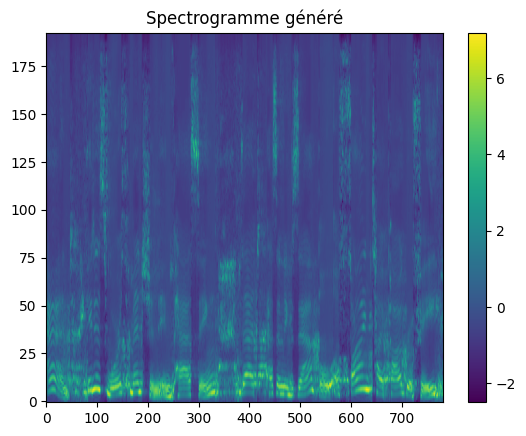

In [74]:
input_tensor = sample[0]  # ou sample[0]["input"] si c’est un dictionnaire
plt.imshow(input_tensor.numpy().T, aspect='auto', origin='lower')
plt.title("Spectrogramme généré")
plt.colorbar()
plt.show()


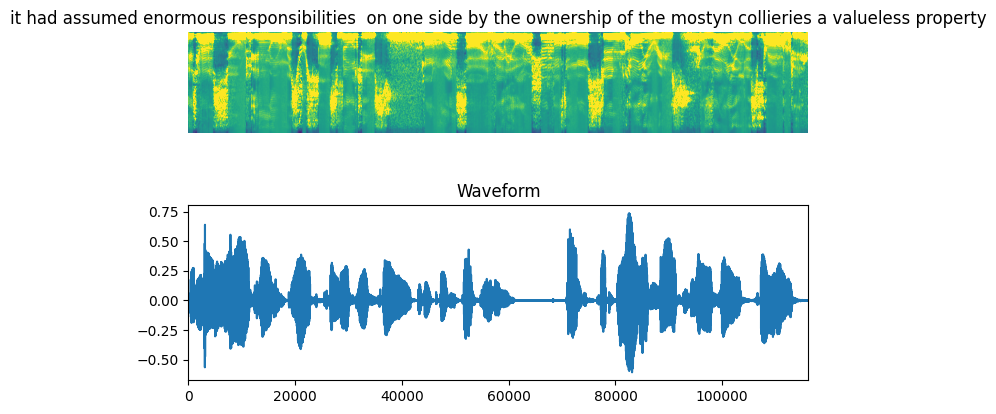

In [120]:


# Afficher un spectrogramme et le signal audio
fig = plt.figure(figsize=(8, 5))

for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])

    label = batch[1][0]
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")

    # Affichage du spectrogramme
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")

    # Chargement et affichage du signal audio
    file_path = "/kaggle/input/ljspeech-dataset/LJSpeech-1.1/wavs/LJ001-0011.wav"
    file = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()

    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Waveform")
    ax.set_xlim(0, len(audio))

    display.display(display.Audio(np.transpose(audio),rate=16000))  # Assure-toi que ton sample rate est bien 16000

plt.show()


In [35]:
import tensorflow as tf
from tensorflow import keras

def CTCLoss(y_true, y_pred):
    # Calcul de la taille du batch
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")

    # Longueur d'entrée (nombre de pas de temps en sortie du modèle)
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    # Longueur des étiquettes (labels)
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    # Calcul de la loss CTC
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


# **deepspeech**

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
   

    # Entrée du modèle : (None, input_dim)
    input_spectrogram = layers.Input(shape=(None, input_dim), name="input")

    # Ajout d'une dimension pour appliquer la 2D CNN
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)

    # Convolution 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1"
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)

    # Convolution 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2"
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)

    # Passage de 4D à 3D pour les couches RNN
    shape = x.shape
    x = layers.Reshape((-1, shape[-2] * shape[-1]))(x)

    # Couches RNN bidirectionnelles
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}"
        )
        x = layers.Bidirectional(
            recurrent,
            merge_mode="concat",
            name=f"bidirectional_{i}"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)

    # Couche Dense + activation
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)

    # Couche de sortie : classification avec softmax
    output = layers.Dense(units=output_dim + 1, activation="softmax", name="output")(x)

    # Définition du modèle
    model = keras.Model(inputs=input_spectrogram, outputs=output, name="DeepSpeech2")

    # Compilation avec l'optimiseur Adam et la loss CTC
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss=CTCLoss)

    return model
    
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)

model.summary(line_length=110)


Model: "DeepSpeech2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                             │ (None, None, 193)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ expand_dim (Reshape)                           │ (None, None, 193, 1)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1 (Conv2D)                                │ (None, None, 97, 32)                │              14,432 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_bn (BatchNormalization)                 │ (None, None, 97, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_relu (ReLU)                             │ (None, None, 97, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2 (Conv2D)                                │ (None, None, 49, 32)                │             236,544 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_bn (BatchNormalization)                 │ (None, None, 49, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_relu (ReLU)                             │ (None, None, 49, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ reshape (Reshape)                              │ (None, None, 1568)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_1 (Bidirectional)                │ (None, None, 1024)                  │           6,395,904 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout (Dropout)                              │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_2 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_1 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_3 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_2 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_4 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_3 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├───

 Total params: 26,628,480 (101.58 MB)

 Trainable params: 26,628,352 (101.58 MB)

 Non-trainable params: 128 (512.00 B)

In [142]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


In [143]:
from tensorflow import keras
import numpy as np
import tensorflow as tf

class CallbackEval(keras.callbacks.Callback):
    """Affiche un batch de prédictions après chaque epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        predictions = []
        targets = []

        for batch in self.dataset:
            X, y = batch
            batch_predictions = self.model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)  # Ta fonction de décodage
            predictions.extend(batch_predictions)

            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)

        # Calcul du WER (à définir, ici juste un placeholder)
        wer_score = wer(targets, predictions)  # Assure-toi que ta fonction wer est définie

        print("\n" + "*" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("*" * 100)

        # Affiche quelques exemples aléatoires
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target: {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)


In [30]:
# Définir le dataset de validation
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset
    .map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

NameError: name 'batch_size' is not defined

In [45]:
predictions = []
targets = []

for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    
    for label in y:
        label_text = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label_text)

wer_score = wer(targets, predictions)

print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)

for i in np.random.randint(0, len(predictions), 5):
    print(f"Target: {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)


1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━

In [ ]:
epochs = 50

# Callback pour valider sur l'ensemble de validation
validation_callback = CallbackEval(validation_dataset)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)


In [ ]:
model.save('mon_modele.keras')


# **ResulTat dans le notebook 2**

In [ ]:
for batch in test_dataset:
    input_values, labels = batch
    preds = decode_batch(input_values)
    label_ids = labels.numpy()
    label_strs = processor.batch_decode(label_ids, group_tokens=False)
    all_preds.extend(preds)
    all_labels.extend(label_strs)

wer_score = jiwer.wer(all_labels, all_preds)
print(f"WER sur test : {wer_score:.4f}")


In [79]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))
print("Nom du périphérique utilisé:", tf.device("/GPU:0" if len(tf.config.list_physical_devices('GPU')) > 0 else "/CPU:0"))

TensorFlow version: 2.18.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Nom du périphérique utilisé: <tensorflow.python.eager.context._EagerDeviceContext object at 0x7c68c73e6c80>


In [76]:
import tensorflow as tf

print("GPU disponible :", tf.config.list_physical_devices('GPU'))


GPU disponible : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [87]:
!pip install tensorflow tensorflow_hub librosa soundfile


In [88]:
import pandas as pd
import os

data_path = "/kaggle/input/ljspeech-dataset/LJSpeech-1.1"
wavs_path = os.path.join(data_path, "wavs")
metadata_path = os.path.join(data_path, "metadata.csv")

# Chargement du fichier metadata
df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
df.columns = ["file_name", "transcription", "normalized_transcription"]

# Création du chemin complet vers les fichiers audio
df["path"] = df["file_name"].apply(lambda x: os.path.join(wavs_path, f"{x}.wav"))
df = df[["path", "normalized_transcription"]]
df = df.rename(columns={"normalized_transcription": "text"})



In [89]:
import librosa
import numpy as np
import tensorflow as tf

def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=16000)
    return audio


In [90]:
import tensorflow_hub as hub

# Chargement du modèle pré-entraîné
pretrained_model = hub.KerasLayer("https://tfhub.dev/vasudevgupta7/wav2vec2/1", trainable=True)


In [6]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from gensim.models import Word2Vec
from tqdm import tqdm

# Check for TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.cluster_spec().as_dict()['worker'])
    
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
    
print(f"Number of accelerators: {strategy.num_replicas_in_sync}")

# Data loading and preparation
data_path = "/kaggle/input/ljspeech-dataset/LJSpeech-1.1"
wavs_path = os.path.join(data_path, "wavs")
metadata_path = os.path.join(data_path, "metadata.csv")

# Load metadata
df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
df.columns = ["file_name", "transcription", "normalized_transcription"]
df["path"] = df["file_name"].apply(lambda x: os.path.join(wavs_path, f"{x}.wav"))
df = df[["path", "normalized_transcription"]]
df = df.rename(columns={"normalized_transcription": "text"})

# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['clean_text'] = df['text'].apply(clean_text)

# Create a vocabulary from the dataset
def create_vocabulary(texts):
    vocab = set()
    for text in texts:
        words = text.split()
        vocab.update(words)
    return sorted(list(vocab))

# Audio feature extraction
def extract_features(file_path, max_pad_len=862):
    """
    Extract MFCC features from audio file
    """
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        # Pad or truncate to max_pad_len
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]
        return mfccs
    except Exception as e:
        print(f"Error extracting features for {file_path}: {e}")
        return None

# Split the data into training, validation, and testing sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Testing set: {len(test_df)} samples")

# Create vocabulary from training set
vocabulary = create_vocabulary(train_df['clean_text'].tolist())
print(f"Vocabulary size: {len(vocabulary)}")

# Word2Vec model training
class SentenceIterator:
    def __init__(self, df):
        self.df = df
    
    def __iter__(self):
        for text in self.df['clean_text'].values:
            yield text.split()

# Train Word2Vec on training data
sentence_iterator = SentenceIterator(train_df)
word2vec_model = Word2Vec(
    sentences=sentence_iterator,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sg=1  # Skip-gram model
)

# Create embedding matrix
word_to_index = {word: i+1 for i, word in enumerate(vocabulary)}  # 0 is reserved for padding
embedding_dim = 100
embedding_matrix = np.zeros((len(vocabulary) + 1, embedding_dim))

for word, i in word_to_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
    else:
        # Random initialization for words not in Word2Vec model
        embedding_matrix[i] = np.random.uniform(-0.25, 0.25, embedding_dim)

# Text processing for model input
def text_to_sequence(text, word_to_index, max_len=50):
    """Convert text to a sequence of word indices"""
    words = text.split()
    seq = [word_to_index.get(word, 0) for word in words[:max_len]]
    # Pad sequence to max_len
    if len(seq) < max_len:
        seq += [0] * (max_len - len(seq))
    return np.array(seq)

# Process batch of features
def load_features_batch(file_paths, max_pad_len=862):
    features = []
    for path in file_paths:
        feature = extract_features(path, max_pad_len)
        if feature is not None:
            features.append(feature)
    return np.array(features)

# Using a data generator for memory efficiency
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, word_to_index, batch_size=32, max_text_len=50, max_audio_len=862, shuffle=True):
        self.df = df
        self.word_to_index = word_to_index
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.max_audio_len = max_audio_len
        self.shuffle = shuffle
        self.indexes = np.arange(len(df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]
        
        # Extract audio features
        X = load_features_batch(batch_df['path'].tolist(), self.max_audio_len)
        X = X.reshape(-1, X.shape[1], X.shape[2], 1)  # Add channel dimension
        
        # Process text
        y = np.array([text_to_sequence(text, self.word_to_index, self.max_text_len) 
                     for text in batch_df['clean_text'].tolist()])
        
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Create generators
batch_size = 32
train_generator = DataGenerator(train_df, word_to_index, batch_size=batch_size)
val_generator = DataGenerator(val_df, word_to_index, batch_size=batch_size, shuffle=False)
test_generator = DataGenerator(test_df, word_to_index, batch_size=batch_size, shuffle=False)

# Build the Speech to Text model using TPU strategy
with strategy.scope():
    # Audio input branch
    audio_input = Input(shape=(40, 862, 1), name='audio_input')
    
    # CNN layers for feature extraction
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(audio_input)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Reshape for RNN
    x = tf.keras.layers.Reshape((-1, x.shape[-1] * x.shape[-2]))(x)
    
    # Bidirectional LSTM layers
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(256, return_sequences=False))(x)
    x = Dropout(0.3)(x)
    
    # Dense layers for text prediction
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    # Output layer with embedding
    outputs = Dense(50, activation='linear')(x)  # Output sequence of length 50
    
    # Create model
    model = Model(inputs=audio_input, outputs=outputs)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['accuracy']
    )

# Display model summary
model.summary()

# Create callbacks
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

Number of accelerators: 1
Training set: 9170 samples
Validation set: 1965 samples
Testing set: 1965 samples
Vocabulary size: 12559


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ audio_input (InputLayer)        │ (None, 40, 862, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 40, 862, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 431, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 431, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 215, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 10, 215, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 107, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 5, 13696)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 5, 512)         │    28,575,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_200 (Dropout)           │ (None, 5, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 512)            │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_201 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_202 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 50)             │        25,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,531,634 (116.47 MB)

 Trainable params: 30,531,634 (116.47 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint, early_stopping]
)

/usr/local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


NotFoundError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/local/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/local/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 765, in start

  File "/usr/local/lib/python3.10/site-packages/anyio/_core/_eventloop.py", line 74, in run

  File "/usr/local/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", line 2310, in run

  File "/usr/local/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", line 217, in run

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 636, in run_until_complete

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/local/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 435, in process_shell

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 512, in process_shell_message

  File "/usr/local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 361, in execute_request

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 766, in execute_request

  File "/usr/local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 457, in do_execute

  File "/usr/local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 606, in run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/tmp/ipykernel_10/1753300014.py", line 1, in <module>

  File "/usr/local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

could not find registered transfer manager for platform Host -- check target linkage
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_19015]

In [16]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from gensim.models import Word2Vec
from tqdm import tqdm

# Check if TPU is available and set up strategy appropriately
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("Running on TPU:", resolver.cluster_spec().as_dict()["worker"])
except:
    # Fall back to GPU or CPU
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        strategy = tf.distribute.MirroredStrategy()
        print("Running on GPU")
    else:
        strategy = tf.distribute.get_strategy()
        print("Running on CPU")
    
print(f"Number of accelerators: {strategy.num_replicas_in_sync}")

# Data loading and preparation
data_path = "/kaggle/input/ljspeech-dataset/LJSpeech-1.1"
wavs_path = os.path.join(data_path, "wavs")
metadata_path = os.path.join(data_path, "metadata.csv")

# Load metadata
df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
df.columns = ["file_name", "transcription", "normalized_transcription"]
df["path"] = df["file_name"].apply(lambda x: os.path.join(wavs_path, f"{x}.wav"))
df = df[["path", "normalized_transcription"]]
df = df.rename(columns={"normalized_transcription": "text"})

# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['clean_text'] = df['text'].apply(clean_text)

# Create a vocabulary from the dataset
def create_vocabulary(texts):
    vocab = set()
    for text in texts:
        words = text.split()
        vocab.update(words)
    return sorted(list(vocab))

# Audio feature extraction
def extract_features(file_path, max_pad_len=862):
    """
    Extract MFCC features from audio file
    """
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        # Pad or truncate to max_pad_len
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]
        return mfccs
    except Exception as e:
        print(f"Error extracting features for {file_path}: {e}")
        return None

# Split the data into training, validation, and testing sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Testing set: {len(test_df)} samples")

# Create vocabulary from training set
vocabulary = create_vocabulary(train_df['clean_text'].tolist())
print(f"Vocabulary size: {len(vocabulary)}")

# Word2Vec model training
class SentenceIterator:
    def __init__(self, df):
        self.df = df
    
    def __iter__(self):
        for text in self.df['clean_text'].values:
            yield text.split()

# Train Word2Vec on training data
sentence_iterator = SentenceIterator(train_df)
word2vec_model = Word2Vec(
    sentences=sentence_iterator,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sg=1  # Skip-gram model
)

# Create embedding matrix
word_to_index = {word: i+1 for i, word in enumerate(vocabulary)}  # 0 is reserved for padding
embedding_dim = 100
embedding_matrix = np.zeros((len(vocabulary) + 1, embedding_dim))

for word, i in word_to_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
    else:
        # Random initialization for words not in Word2Vec model
        embedding_matrix[i] = np.random.uniform(-0.25, 0.25, embedding_dim)

# Text processing for model input
def text_to_sequence(text, word_to_index, max_len=50):
    """Convert text to a sequence of word indices"""
    words = text.split()
    seq = [word_to_index.get(word, 0) for word in words[:max_len]]
    # Pad sequence to max_len
    if len(seq) < max_len:
        seq += [0] * (max_len - len(seq))
    return np.array(seq)

# Process batch of features
def load_features_batch(file_paths, max_pad_len=862):
    features = []
    for path in file_paths:
        feature = extract_features(path, max_pad_len)
        if feature is not None:
            features.append(feature)
    return np.array(features)

# Using a data generator for memory efficiency
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, word_to_index, batch_size=32, max_text_len=50, max_audio_len=862, shuffle=True):
        self.df = df
        self.word_to_index = word_to_index
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.max_audio_len = max_audio_len
        self.shuffle = shuffle
        self.indexes = np.arange(len(df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
        
        # Pre-extract all features to avoid file I/O during training
        print("Pre-extracting features...")
        self.features = []
        self.texts = []
        for i in tqdm(range(len(df))):
            path = df['path'].iloc[i]
            feature = extract_features(path, self.max_audio_len)
            if feature is not None:
                self.features.append(feature)
                self.texts.append(df['clean_text'].iloc[i])
        
        print(f"Loaded {len(self.features)} valid samples")
    
    def __len__(self):
        return int(np.ceil(len(self.features) / self.batch_size))
    
    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.features))
        
        # Get batch features
        batch_features = np.array(self.features[start_idx:end_idx])
        batch_features = batch_features.reshape(-1, batch_features.shape[1], batch_features.shape[2], 1)
        
        # Process text
        batch_texts = [text_to_sequence(text, self.word_to_index, self.max_text_len) 
                      for text in self.texts[start_idx:end_idx]]
        batch_texts = np.array(batch_texts)
        
        return batch_features, batch_texts
    
    def on_epoch_end(self):
        # Shuffle only indices to preserve pre-loaded data
        if self.shuffle:
            indices = np.arange(len(self.features))
            np.random.shuffle(indices)
            self.features = [self.features[i] for i in indices]
            self.texts = [self.texts[i] for i in indices]

# Create generators - use smaller batch size for TPU
batch_size = 16  # Reduced from 32 to avoid memory issues
train_generator = DataGenerator(train_df, word_to_index, batch_size=batch_size)
val_generator = DataGenerator(val_df, word_to_index, batch_size=batch_size, shuffle=False)
test_generator = DataGenerator(test_df, word_to_index, batch_size=batch_size, shuffle=False)

# Build the Speech to Text model using TPU strategy
with strategy.scope():
    # Audio input branch - explicit shape specification
    audio_input = Input(shape=(40, 862, 1), name='audio_input')
    
    # CNN layers for feature extraction
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(audio_input)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Reshape for RNN - explicit shape calculation
    reshaped_x = tf.keras.layers.Reshape((107, 128 * 5))(x)  # 862 -> 431 -> 215 -> 107 (after pooling), width=5
    
    # Bidirectional LSTM layers
    x = Bidirectional(LSTM(128, return_sequences=True))(reshaped_x)  # Reduced from 256
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(128, return_sequences=False))(x)  # Reduced from 256
    x = Dropout(0.3)(x)
    
    # Dense layers for text prediction
    x = Dense(256, activation='relu')(x)  # Reduced from 512
    x = Dropout(0.3)(x)
    
    # Output layer with embedding
    outputs = Dense(50, activation='linear')(x)  # Output sequence of length 50
    
    # Create model
    model = Model(inputs=audio_input, outputs=outputs)
    
    # Compile model with sparse categorical crossentropy for word prediction
    model.compile(
        optimizer=Adam(learning_rate=0.0005),  # Reduced learning rate
        loss='mse',
        metrics=['accuracy']
    )

# Display model summary
model.summary()

# Create callbacks
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Train model


   


Running on CPU
Number of accelerators: 1
Training set: 9170 samples
Validation set: 1965 samples
Testing set: 1965 samples
Vocabulary size: 12559
Pre-extracting features...


100%|██████████| 9170/9170 [01:58<00:00, 77.10it/s]


Loaded 9170 valid samples
Pre-extracting features...


100%|██████████| 1965/1965 [00:26<00:00, 75.36it/s]


Loaded 1965 valid samples
Pre-extracting features...


100%|██████████| 1965/1965 [00:25<00:00, 77.34it/s]


Loaded 1965 valid samples


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ audio_input (InputLayer)        │ (None, 40, 862, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 40, 862, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 20, 431, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 20, 431, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 10, 215, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 10, 215, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 107, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 107, 640)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 107, 256)       │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_206 (Dropout)           │ (None, 107, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_207 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_208 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,353,010 (5.16 MB)

 Trainable params: 1,353,010 (5.16 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
!pip install transformers datasets torchaudio librosa jiwer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 29.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.9/333.9 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.6/206.6 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.8/219.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.3/287.3 kB 25.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalli

In [2]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import librosa
import re
import string
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Data paths
data_path = "/kaggle/input/ljspeech-dataset/LJSpeech-1.1"
wavs_path = os.path.join(data_path, "wavs")
metadata_path = os.path.join(data_path, "metadata.csv")

# Load metadata file
df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
df.columns = ["file_name", "transcription", "normalized_transcription"]
df["path"] = df["file_name"].apply(lambda x: os.path.join(wavs_path, f"{x}.wav"))
df = df[["path", "normalized_transcription"]]
df = df.rename(columns={"normalized_transcription": "text"})

# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    # Remove extra spaces
    text = re.sub(' +', ' ', text).strip()
    return text

# Apply text preprocessing
df['processed_text'] = df['text'].apply(preprocess_text)

# Split the dataset
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

# Extract all words for Word2Vec training
def extract_sentences(dataframe):
    return [text.split() for text in dataframe['processed_text']]

# Get sentences for Word2Vec training
all_sentences = extract_sentences(train_df)

# Train Word2Vec model
print("Training Word2Vec model...")
word2vec_model = Word2Vec(sentences=all_sentences,
                         vector_size=100,
                         window=5,
                         min_count=1,
                         workers=4,
                         sg=1)  # Using skip-gram

print(f"Word2Vec model contains {len(word2vec_model.wv.key_to_index)} words")

# Save the Word2Vec model
word2vec_model.save("word2vec_ljspeech.model")

# Audio feature extraction
def extract_features(file_path, max_length=1000):
    """
    Extract MFCC features from audio file
    """
    try:
        audio, sr = librosa.load(file_path, sr=None)
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        # Transpose to have time as first dimension
        mfccs = mfccs.T
        # Pad or truncate to fixed length
        if mfccs.shape[0] > max_length:
            mfccs = mfccs[:max_length, :]
        else:
            pad_width = ((0, max_length - mfccs.shape[0]), (0, 0))
            mfccs = np.pad(mfccs, pad_width, mode='constant')
        return mfccs
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

# Create vocabulary and mappings
def create_vocabulary(texts):
    """
    Create word-to-index and index-to-word mappings
    """
    all_words = []
    for text in texts:
        all_words.extend(text.split())
    
    unique_words = sorted(list(set(all_words)))
    word_to_idx = {word: idx + 1 for idx, word in enumerate(unique_words)}  # 0 is reserved for padding
    idx_to_word = {idx + 1: word for idx, word in enumerate(unique_words)}
    idx_to_word[0] = '<PAD>'
    
    return word_to_idx, idx_to_word

# Create vocabulary from training data
word_to_idx, idx_to_word = create_vocabulary(train_df['processed_text'])
vocab_size = len(word_to_idx) + 1  # +1 for padding token

print(f"Vocabulary size: {vocab_size}")

# Convert text to indices
def text_to_indices(text, word_to_idx):
    return [word_to_idx.get(word, 0) for word in text.split()]

# Create dataset class
class SpeechDataset(Dataset):
    def __init__(self, dataframe, word_to_idx, word2vec_model):
        self.dataframe = dataframe
        self.word_to_idx = word_to_idx
        self.word2vec_model = word2vec_model
        
        # Pre-extract features to save time
        self.features = []
        self.indices = []
        self.seq_lengths = []
        
        print("Extracting audio features...")
        for i, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
            # Extract audio features
            mfcc = extract_features(row['path'])
            if mfcc is not None:
                self.features.append(torch.FloatTensor(mfcc))
                
                # Convert text to indices
                indices = text_to_indices(row['processed_text'], word_to_idx)
                self.indices.append(torch.LongTensor(indices))
                self.seq_lengths.append(len(indices))
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.indices[idx], self.seq_lengths[idx]

# Create datasets
train_dataset = SpeechDataset(train_df.head(50), word_to_idx, word2vec_model)  # Using a small subset for demonstration
val_dataset = SpeechDataset(val_df.head(20), word_to_idx, word2vec_model)
test_dataset = SpeechDataset(test_df.head(20), word_to_idx, word2vec_model)

# Collate function for handling variable length sequences
def collate_fn(batch):
    # Sort batch by sequence length (descending)
    batch = sorted(batch, key=lambda x: x[2], reverse=True)
    
    # Separate features, indices, and sequence lengths
    features = [item[0] for item in batch]
    indices = [item[1] for item in batch]
    seq_lengths = [item[2] for item in batch]
    
    # Pad sequences
    features_padded = pad_sequence(features, batch_first=True)
    indices_padded = pad_sequence(indices, batch_first=True)
    
    return features_padded, indices_padded, torch.LongTensor(seq_lengths)

# Create data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

# Speech to Text model
class SpeechToTextModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim, vocab_size, word2vec_model, word_to_idx):
        super(SpeechToTextModel, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Bidirectional LSTM for audio processing
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        
        # Initialize embedding with Word2Vec weights
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.initialize_embeddings(word2vec_model, word_to_idx, embedding_dim)
        
        # Output layer
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)  # * 2 for bidirectional
        
    def initialize_embeddings(self, word2vec_model, word_to_idx, embedding_dim):
        # Initialize embedding weights with Word2Vec vectors
        embedding_weights = torch.zeros(len(word_to_idx) + 1, embedding_dim)  # +1 for padding token
        
        for word, idx in word_to_idx.items():
            if word in word2vec_model.wv:
                embedding_weights[idx] = torch.FloatTensor(word2vec_model.wv[word])
        
        self.embedding.weight = nn.Parameter(embedding_weights)
    
    def forward(self, x, lengths):
        # x shape: (batch_size, seq_len, input_dim)
        
        # Pack padded sequence to handle variable length inputs
        packed_x = pack_padded_sequence(x, lengths, batch_first=True)
        
        # Pass through LSTM
        packed_output, (hidden, cell) = self.lstm(packed_x)
        
        # Unpack the sequence
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        # Get the output from the last non-padded element
        batch_size = output.size(0)
        
        # Use the last time step of the sequence
        output = self.fc(output)
        
        return output

# Initialize model
input_dim = 13  # MFCC features
hidden_dim = 128
embedding_dim = 100  # Same as Word2Vec
model = SpeechToTextModel(input_dim, hidden_dim, embedding_dim, vocab_size, word2vec_model, word_to_idx)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding index
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for features, targets, lengths in tqdm(train_loader):
        features = features.to(device)
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(features, lengths)
        
        # Reshape for CrossEntropyLoss
        # outputs: [batch_size, seq_len, vocab_size] -> [batch_size * seq_len, vocab_size]
        batch_size, seq_len, vocab_size = outputs.size()
        outputs = outputs.view(-1, vocab_size)
        
        # targets: [batch_size, seq_len] -> [batch_size * seq_len]
        targets = targets.view(-1)
        
        # Calculate loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

# Evaluation function
def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for features, targets, lengths in val_loader:
            features = features.to(device)
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(features, lengths)
            
            # Reshape for CrossEntropyLoss
            batch_size, seq_len, vocab_size = outputs.size()
            outputs = outputs.view(-1, vocab_size)
            targets = targets.view(-1)
            
            # Calculate loss
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    
    return total_loss / len(val_loader)

# Decode predictions
def decode_predictions(predictions, idx_to_word):
    decoded = []
    for pred in predictions:
        word_indices = torch.argmax(pred, dim=1).cpu().numpy()
        words = [idx_to_word.get(idx, '<UNK>') for idx in word_indices if idx > 0]  # Skip padding
        decoded.append(' '.join(words))
    return decoded

Training set: 9170 samples
Validation set: 1965 samples
Test set: 1965 samples
Training Word2Vec model...
Word2Vec model contains 12561 words
Vocabulary size: 12562
Extracting audio features...


100%|██████████| 50/50 [00:01<00:00, 29.20it/s]


Extracting audio features...


100%|██████████| 20/20 [00:00<00:00, 80.97it/s]


Extracting audio features...


100%|██████████| 20/20 [00:00<00:00, 81.50it/s]
/tmp/ipykernel_2202/472854247.py:202: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  embedding_weights[idx] = torch.FloatTensor(word2vec_model.wv[word])


In [3]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = model.to(device)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Evaluate
    val_loss = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    
    print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('loss_plot.png')
plt.close()



Using device: cpu
Epoch 1/10


100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


Training Loss: 9.3064, Validation Loss: 9.0554
Epoch 2/10


100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


Training Loss: 8.2729, Validation Loss: 7.9608
Epoch 3/10


100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Training Loss: 6.3446, Validation Loss: 7.8568
Epoch 4/10


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


Training Loss: 5.6530, Validation Loss: 8.3720
Epoch 5/10


100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Training Loss: 5.5579, Validation Loss: 8.7609
Epoch 6/10


100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


Training Loss: 5.4809, Validation Loss: 8.9733
Epoch 7/10


100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Training Loss: 5.4252, Validation Loss: 9.1065
Epoch 8/10


100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


Training Loss: 5.4369, Validation Loss: 9.1555
Epoch 9/10


100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


Training Loss: 5.3630, Validation Loss: 9.1521
Epoch 10/10


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Training Loss: 5.3636, Validation Loss: 9.1695


In [1]:
a=1

In [ ]:
a

In [2]:
from datasets import load_dataset
from datasets import concatenate_datasets, DatasetDict

In [3]:
!pip install matplotlib-venn

In [4]:
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/main/liba/libarchive/libarchive-dev_3.6.0-1ubuntu1.3_amd64.deb  404  Not Found [IP: 185.125.190.82 80]
E: Unable to fetch some archives, maybe run apt-get update or try with --fix-missing?


ModuleNotFoundError: No module named 'libarchive'

In [ ]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

In [5]:
!pip install cartopy
import cartopy

In [6]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu

In [7]:
!pip install --upgrade datasets fsspec


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.12.0
    Uninstalling fsspec-2024.12.0:
      Successfully uninstalled fsspec-2024.12.0
  Attempting uninstall: datasets
    Found existing installation: datasets 3.5.0
    Uninstalling datasets-3.5.0:
      Successfully uninstalled datasets-3.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2025.3.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.7

In [18]:
# Installation des dépendances si besoin (pour Kaggle ou Colab)


from datasets import DatasetDict
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, TrainingArguments, Trainer
from datasets import load_dataset, Audio
import torch
import numpy as np


In [19]:
from datasets import load_dataset, concatenate_datasets, DatasetDict

# 1. Charger le dataset depuis HuggingFace
raw_dataset = load_dataset("UBC-NLP/Casablanca", "Morocco", split={"validation": "validation", "test": "test"})

# 2. Fusionner validation + test, et split en train/val
combined = concatenate_datasets([raw_dataset["validation"], raw_dataset["test"]])
train_testvalid = combined.train_test_split(test_size=0.2, seed=42)
train_dataset = train_testvalid["train"]
val_dataset = train_testvalid["test"]
test_dataset = raw_dataset["test"]

# 3. Créer le DatasetDict final
final_dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})


In [20]:
import re
# 4. Charger et caster l'audio
final_dataset = final_dataset.cast_column("audio", Audio(sampling_rate=16000))

# 5. Normaliser les transcriptions
def normalize_text(batch):
    text = batch["transcription"]
    text = re.sub(r"[^\u0600-\u06FF\s]", "", text)  # Garder que les caractères arabes
    batch["transcription"] = text.strip()
    return batch

final_dataset = final_dataset.map(normalize_text)




In [21]:
from transformers import Wav2Vec2Processor
from datasets import load_dataset, concatenate_datasets, DatasetDict

# Charger le processor arabe
processor = Wav2Vec2Processor.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-arabic")

def prepare_dataset(batch):
    audio = batch["audio"]
    batch["input_values"] = processor(audio["array"], sampling_rate=16000).input_values[0]
    batch["labels"] = processor.tokenizer(batch["transcription"]).input_ids
    return batch

# Appliquer la fonction de prétraitement
final_dataset = final_dataset.map(prepare_dataset, remove_columns=final_dataset["train"].column_names)


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [22]:
import numpy as np
import evaluate


In [23]:
from dataclasses import dataclass
from typing import List, Dict, Union
import torch

@dataclass
class DataCollatorCTCWithPadding:
    processor: any
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(input_features, padding=self.padding, return_tensors="pt")

        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(label_features, padding=self.padding, return_tensors="pt")

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels

        return batch

# Ensuite :
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)


In [ ]:
!pip install --upgrade torch_xla


In [31]:
model = Wav2Vec2ForCTC.from_pretrained(
    "jonatasgrosman/wav2vec2-large-xlsr-53-arabic",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id
)

# 9. Metrics
wer = evaluate.load("wer")

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)
    pred_str = processor.batch_decode(pred_ids)
    label_ids = pred.label_ids
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, group_tokens=False)
    return {"wer": wer.compute(predictions=pred_str, references=label_str)}

# 10. Arguments d'entraînement
training_args = TrainingArguments(
    output_dir="./wav2vec2-darija",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_steps=500,
    save_steps=500,
    learning_rate=3e-4,
    num_train_epochs=50,
    warmup_steps=500,
    save_total_limit=2,
    fp16=True,
    gradient_accumulation_steps=2,         # utile si tu veux batch_size effectif plus grand
    dataloader_num_workers=4,    
    gradient_checkpointing=True,
    push_to_hub=False,
    logging_dir="./logs"
)





/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [34]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_dataset["train"],
    eval_dataset=final_dataset["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    processing_class=processor     # ✅ seule cette ligne suffit pour Wav2Vec2
)


In [35]:

trainer.train()

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [39]:
from transformers import Wav2Vec2Processor

# Charger le processor d'origine
processor = Wav2Vec2Processor.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-arabic")

# Sauvegarder à côté de ton checkpoint
processor.save_pretrained("/kaggle/working/wav2vec2-darija-processor")


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


[]

In [41]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained("/kaggle/working/wav2vec2-darija-processor")
model = Wav2Vec2ForCTC.from_pretrained("/kaggle/input/model-darija/wav2vec2-darija/checkpoint-4180")  # Remplace par ton bon checkpoint


In [43]:
!pip install evaluate


In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

predictions = []
references = []

model.eval()

for sample in final_dataset["validation"]:
    input_values = torch.tensor(sample["input_values"]).unsqueeze(0).to(device)
    
    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription_pred = processor.batch_decode(predicted_ids)[0].lower()

    predictions.append(transcription_pred)
    references.append(sample["input_values"].lower())

from jiwer import wer
error = wer(references, predictions)
print(f"Word Error Rate: {error}")


AttributeError: 'list' object has no attribute 'lower'

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

predictions = []
references = []

model.eval()

for sample in final_dataset["validation"]:
    input_values = torch.tensor(sample["input_values"]).unsqueeze(0).to(device)

    with torch.no_grad():
      # Exemple d'utilisation
audio_file = "chemin/vers/votre/fichier_audio.wav"
transcription = transcribe_audio(audio_file)
print(f"Transcription: {transcription}")  logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription_pred = processor.batch_decode(predicted_ids)[0].lower()

    reference_text = processor.batch_decode([sample["labels"]], group_tokens=False)[0].lower()

    predictions.append(transcription_pred)
    references.append(reference_text)

from jiwer import wer
error = wer(references, predictions)
print(f"Word Error Rate: {error}")


Word Error Rate: 0.6555962907051973


In [50]:
import torch
from datasets import load_dataset
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from jiwer import wer     

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.


Traitement des échantillons audio du dataset UBC-NLP/Casablanca (Maroc)...


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Échantillon 1:
Transcription:  فرست كما ما كنتم هندي بقصة معنا في الدار كون شديدت بكش حالة هذه من هامشة انجيلا اللي ما قدش كان عرف نقرا حتى ولكنك يشرح لي كل شيء


KeyError: 'text'

In [87]:
import torch
import librosa
import numpy as np
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained("/kaggle/working/wav2vec2-darija-processor")
model = Wav2Vec2ForCTC.from_pretrained("/kaggle/input/model-darija/wav2vec2-darija/checkpoint-4180")

def transcribe_audio(audio_path):
    # Charger et resampler audio à 16 kHz
    speech, sample_rate = librosa.load(audio_path, sr=16000)
    print(f"Sample rate après resampling: {sample_rate}, samples: {len(speech)}, duration (s): {len(speech)/sample_rate:.2f}")
    
    # Padding si audio trop court (ici 1 sec = 16000 samples)
    min_length = 16000
    if len(speech) < min_length:
        pad_length = min_length - len(speech)
        speech = np.pad(speech, (0, pad_length), 'constant', constant_values=0)
        print(f"Audio paded to {len(speech)} samples.")

    input_values = processor(speech, sampling_rate=sample_rate, return_tensors="pt").input_values

    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.decode(predicted_ids[0])
    return transcription

audio_file = "/kaggle/input/testpredct/audio.wav"
transcription = transcribe_audio(audio_file)
print(f"Transcription: {transcription}")


Sample rate après resampling: 16000, samples: 51039, duration (s): 3.19
Transcription: غا هو خاصك تضور ضويرة بالقهوة تبدل الكراسا و الطبالي


In [17]:
import torch
import librosa
import numpy as np
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained("/kaggle/input/processor-darija/kaggle/working/wav2vec2-darija-processor")
model = Wav2Vec2ForCTC.from_pretrained("/kaggle/input/model-darija/wav2vec2-darija/checkpoint-4180")

def transcribe_audio(audio_path):
    # Charger et resampler audio à 16 kHz
    speech, sample_rate = librosa.load(audio_path, sr=16000)
    print(f"Sample rate après resampling: {sample_rate}, samples: {len(speech)}, duration (s): {len(speech)/sample_rate:.2f}")
    
    # Padding si audio trop court (ici 1 sec = 16000 samples)
    min_length = 16000
    if len(speech) < min_length:
        pad_length = min_length - len(speech)
        speech = np.pad(speech, (0, pad_length), 'constant', constant_values=0)
        print(f"Audio paded to {len(speech)} samples.")

    input_values = processor(speech, sampling_rate=sample_rate, return_tensors="pt").input_values

    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.decode(predicted_ids[0])
    return transcription

audio_file = "/kaggle/input/testpredct/audio.wav"
transcription = transcribe_audio(audio_file)
print(f"Transcription: {transcription}")


Sample rate après resampling: 16000, samples: 51039, duration (s): 3.19
Transcription: غا هو خاصك تضور ضويرة بالقهوة تبدل الكراسا و الطبالي


In [81]:
import shutil

source_folder = "/kaggle/working/wav2vec2-darija"
zip_path = "/kaggle/working/output/wav2vec2-darija-archive"

shutil.make_archive(zip_path, 'zip', source_folder)

print(f"Archive ZIP créée à l'emplacement {zip_path}.zip")


Archive ZIP créée à l'emplacement /kaggle/working/output/wav2vec2-darija-archive.zip


In [72]:
!pip install evaluate

In [77]:
import torch
import evaluate
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor



wer_metric = evaluate.load("wer")

def evaluate_model_on_features(model, processor, dataset):
    predictions = []
    references = []

    for batch in dataset:
        input_values = torch.tensor(batch["input_values"]).unsqueeze(0)  # batch size 1
        with torch.no_grad():
            logits = model(input_values).logits

        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.batch_decode(predicted_ids)[0].lower()
        predictions.append(transcription)

        # Les labels sont souvent des ids, on doit décoder en texte :
        label_ids = batch["labels"]
        # Remplacer les -100 par 0 pour décoder (optionnel selon encodage)
        label_ids = [id if id != -100 else processor.tokenizer.pad_token_id for id in label_ids]
        reference = processor.tokenizer.decode(label_ids).lower()
        references.append(reference)

    wer = wer_metric.compute(predictions=predictions, references=references)
    return wer

# Exemple avec final_dataset['validation'] qui contient input_values et labels
wer_score = evaluate_model_on_features(model, processor, final_dataset['validation'])
print(f"WER = {wer_score:.2%}")


WER = 66.38%


In [82]:
!zip -r wav2vec2-darija-processor .zip /kaggle/working/

	zip warning: name not matched: .zip
  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/wav2vec2-darija/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/wav2vec2-darija-processor/ (stored 0%)
  adding: kaggle/working/wav2vec2-darija-processor/special_tokens_map.json (deflated 45%)
  adding: kaggle/working/wav2vec2-darija-processor/preprocessor_config.json (deflated 39%)
  adding: kaggle/working/wav2vec2-darija-processor/vocab.json (deflated 61%)
  adding: kaggle/working/wav2vec2-darija-processor/tokenizer_config.json (deflated 71%)
  adding: kaggle/working/logs/ (stored 0%)
  adding: kaggle/working/logs/events.out.tfevents.1747562273.557f83d9e9b7.31.3 (deflated 65%)
  adding: kaggle/working/logs/events.out.tfevents.1747560921.557f83d9e9b7.31.2 (deflated 64%)
  adding: kaggle/working/logs/events.out.tfevents.1747562443.557f83d9e9b7.31.4 (deflated 64%)
  adding: kaggle/working/logs/events.out.tfevents.1747562823.557f83d9e9b7.31.5 

In [ ]:
trainer.evaluate()


In [112]:
import tensorflow as tf
import keras



model = keras.models.load_model('/kaggle/input/english-model/mon_modele.keras', custom_objects=custom_objects)


In [111]:
import tensorflow as tf
import numpy as np

# 1. Prétraitement (exemple très simplifié)
def preprocess_audio(file_path):
    file = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    spectrogram = tf.signal.stft(audio, frame_length=512, frame_step=256)
    spectrogram = tf.abs(spectrogram)
    mean = tf.math.reduce_mean(spectrogram)
    std = tf.math.reduce_std(spectrogram)
    spectrogram = (spectrogram - mean) / std
    return spectrogram.numpy()

# 2. Charger et prétraiter
spectrogram = preprocess_audio('/kaggle/input/ljspeech-dataset/LJSpeech-1.1/wavs/LJ001-0005.wav')
input_data = np.expand_dims(spectrogram, axis=0)  # shape (1, time_steps, input_dim)

# 3. Prédiction
predictions = model.predict(input_data)

# 4. Décodage greedy + suppression répétitions + blank token
blank_index = model.output_shape[-1] - 1  # normalement output_dim + 1 - 1

pred_indices = np.argmax(predictions[0], axis=-1)

decoded_chars = []
previous_char = None
for idx in pred_indices:
    if idx != blank_index and idx != previous_char:
        char = num_to_char(tf.constant([idx])).numpy()[0].decode('utf-8')
        decoded_chars.append(char)
    previous_char = idx

transcription = "".join(decoded_chars)
print("Transcription prédite :", transcription)


ValueError: as_list() is not defined on an unknown TensorShape.

In [31]:
char_map_str = " abcdefghijklmnopqrstuvwxyz' "
char_map = {i: c for i, c in enumerate(char_map_str)}

def num_to_char(indices):
    return [char_map.get(i, '') for i in indices]

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for res in results.numpy():
        text = ''.join(num_to_char(res))
        output_text.append(text)
    return output_text


In [101]:
def preprocess_audio(filepath):
    y, sr = librosa.load(filepath, sr=16000)  # charger audio à 16kHz
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80, hop_length=160, n_fft=400)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    # Normalisation entre 0 et 1
    mel_spec_db -= mel_spec_db.min()
    mel_spec_db /= mel_spec_db.max()
    # Transpose pour que le temps soit la 1ère dimension
    mel_spec_db = mel_spec_db.T  
    # Ajouter batch_size=1 et channel=1
    mel_spec_db = np.expand_dims(mel_spec_db, axis=0)
    mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)
    return mel_spec_db


In [103]:
print("Input data shape :", input_data.shape)
print("Model input shape :", model.input_shape)
print("Input data dtype :", input_data.dtype)


Input data shape : (1, 812, 80, 1)
Model input shape : (None, None, 193)
Input data dtype : float32


In [105]:
import numpy as np
import librosa
import tensorflow as tf

def preprocess_audio(audio_path, n_mels=193, sr=16000, n_fft=512, hop_length=256):
    # Charger le fichier audio
    audio, _ = librosa.load(audio_path, sr=sr)
    
    # Calculer le spectrogramme de Mel
    mel_spec = librosa.feature.melspectrogram(
        y=audio, 
        sr=sr, 
        n_fft=n_fft, 
        hop_length=hop_length, 
        n_mels=n_mels
    )
    
    # Convertir en dB
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Transposer pour avoir (time_steps, n_mels)
    mel_spec_db = mel_spec_db.T
    
    # Ajouter la dimension batch (1, time_steps, n_mels)
    input_data = np.expand_dims(mel_spec_db, axis=0).astype(np.float32)
    
    return input_data

# Exemple d’utilisation
audio_path = "/kaggle/input/ljspeech-dataset/LJSpeech-1.1/wavs/LJ001-0003.wav"
input_data = preprocess_audio(audio_path)

print("Shape input_data:", input_data.shape)  # Doit afficher (1, time_steps, 193)


# Faire la prédiction
predictions = model.predict(input_data)


Shape input_data: (1, 605, 193)


ValueError: as_list() is not defined on an unknown TensorShape.

In [106]:
input_data = preprocess_audio(audio_path)  # (1, time_steps, 193)
input_data = normalize_spectrogram(input_data[0])  # normalize (time_steps, 193)
input_data = np.expand_dims(input_data, axis=0)    # (1, time_steps, 193)

print("input_data shape after normalization:", input_data.shape)
print("model input shape:", model.input_shape)

# Si le modèle attend un canal, ajoute-le
if len(model.input_shape) == 4 and input_data.ndim == 3:
    input_data = np.expand_dims(input_data, axis=-1)  # (1, time_steps, 193, 1)

predictions = model.predict(input_data)


NameError: name 'normalize_spectrogram' is not defined

In [134]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import librosa

# --- 1. Fonction pour extraire le spectrogramme compatible (193 features) ---

def preprocess_audio(file_path, sample_rate=16000, n_mels=193):
    # Charger l'audio
    audio, sr = librosa.load(file_path, sr=sample_rate)
    
    # Calculer le spectrogramme Mel
    spectrogram = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_mels=n_mels,
        fmax=sr//2
    )
    
    # Convertir en échelle log (log-mel spectrogram)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    
    # Transposer pour avoir shape (time_steps, features)
    log_spectrogram = log_spectrogram.T
    
    return log_spectrogram

# --- 2. Normalisation ---

def normalize_spectrogram(spectrogram):
    mean = np.mean(spectrogram)
    std = np.std(spectrogram)
    return (spectrogram - mean) / (std + 1e-10)

# --- 3. Chargement modèle ---


# --- 4. Préparer la donnée d'entrée ---

audio_path = "/kaggle/input/ljspeech-dataset/LJSpeech-1.1/wavs/LJ001-0016.wav"  # <-- à changer

spectrogram = preprocess_audio(audio_path)
spectrogram = normalize_spectrogram(spectrogram)

# Ajouter la dimension batch (1, time_steps, 193)
input_data = np.expand_dims(spectrogram, axis=0).astype(np.float32)

print("Input data shape:", input_data.shape)  # doit être (1, temps, 193)
print("Input data dtype:", input_data.dtype)  # doit être float32

# --- 5. Faire la prédiction ---

predictions = model.predict(input_data)

# --- 6. Décoder la prédiction (exemple simple) ---

# Ici, tu dois adapter la fonction de décodage selon ton mapping num_to_char

def decode_batch_predictions(pred):
    # Supposons que ton modèle prédit des logits sur un vocabulaire
    # tu peux faire argmax et supprimer les tokens vides (-1 ou index blank)
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    decoded = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    decoded = tf.sparse.to_dense(decoded, default_value=-1).numpy()
    
    # Convertir les indices en caractères (à adapter à ton vocabulaire)
    # num_to_char = ["a", "b", ..., " "]
    result = []
    for seq in decoded:
        text = ''.join([num_to_char[i] for i in seq if i != -1])
        result.append(text)
    return result

# Exemple d'utilisation
# num_to_char doit être défini selon ton modèle
# decoded_text = decode_batch_predictions(predictions)
# print("Texte prédit :", decoded_text[0])


Input data shape: (1, 165, 193)
Input data dtype: float32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


In [111]:
print(model.input_shape)


(None, None, 193)


In [113]:
import tensorflow as tf
import keras



model = keras.models.load_model('/kaggle/input/english-model/mon_modele.keras', custom_objects=custom_objects)


In [42]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

In [122]:
model.summary()


Model: "DeepSpeech2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, None, 193)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ expand_dim (Reshape)                 │ (None, None, 193, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, None, 97, 32)        │          14,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1_bn (BatchNormalization)       │ (None, None, 97, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1_relu (ReLU)                   │ (None, None, 97, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, None, 49, 32)        │         236,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2_bn (BatchNormalization)       │ (None, None, 49, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2_relu (ReLU)                   │ (None, None, 49, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, None, 1568)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, None, 1024)          │       6,395,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 1024)          │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1_relu (ReLU)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 79,885,186 (304.74 MB)

 Trainable params: 26,628,352 (101.58 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 53,256,706 (203.16 MB)

In [123]:
print("Input shape attendu :", model.input_shape)


Input shape attendu : (None, None, 193)


In [128]:
import numpy as np

# Exemple d'entrée : batch=1, longueur=100 frames, 193 features
dummy_input = np.random.rand(1, 100, 193).astype(np.float32)


In [118]:
print(model.input_shape)


(None, None, 193)


In [130]:
print(model.input_shape)
print(model.output_shape)


(None, None, 193)
(None, None, 32)


In [131]:
import numpy as np

# batch_size = 1, time_steps = 120 (arbitraire), features = 193
dummy_input = np.random.rand(1, 120, 193).astype(np.float32)

# Tester sans prédiction (par exemple pour debug)
print("Dummy input shape:", dummy_input.shape)


Dummy input shape: (1, 120, 193)


In [134]:
model.summary()  # Affiche la structure du modèle
model.evaluate(dummy_input, dummy_target)  # Si tu as une cible fictive


Model: "DeepSpeech2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, None, 193)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ expand_dim (Reshape)                 │ (None, None, 193, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, None, 97, 32)        │          14,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1_bn (BatchNormalization)       │ (None, None, 97, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1_relu (ReLU)                   │ (None, None, 97, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, None, 49, 32)        │         236,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2_bn (BatchNormalization)       │ (None, None, 49, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2_relu (ReLU)                   │ (None, None, 49, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, None, 1568)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, None, 1024)          │       6,395,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 1024)          │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1_relu (ReLU)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 79,885,186 (304.74 MB)

 Trainable params: 26,628,352 (101.58 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 53,256,706 (203.16 MB)

NameError: name 'dummy_target' is not defined

In [135]:
import numpy as np

# Entrée factice : batch=1, 120 pas de temps, 193 features
dummy_input = np.random.rand(1, 120, 193).astype(np.float32)

# Cible factice : batch=1, 120 pas de temps, 32 classes (one-hot ou logits)
dummy_target = np.random.rand(1, 120, 32).astype(np.float32)

# Vérification du modèle
model.summary()

# Test rapide : évalue le modèle sur des données aléatoires
loss = model.evaluate(dummy_input, dummy_target)
print("Loss factice:", loss)


Model: "DeepSpeech2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, None, 193)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ expand_dim (Reshape)                 │ (None, None, 193, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, None, 97, 32)        │          14,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1_bn (BatchNormalization)       │ (None, None, 97, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1_relu (ReLU)                   │ (None, None, 97, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, None, 49, 32)        │         236,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2_bn (BatchNormalization)       │ (None, None, 49, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2_relu (ReLU)                   │ (None, None, 49, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, None, 1568)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, None, 1024)          │       6,395,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 1024)          │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1_relu (ReLU)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 79,885,186 (304.74 MB)

 Trainable params: 26,628,352 (101.58 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 53,256,706 (203.16 MB)

TypeError: Missing required positional argument

2.18.0


In [140]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

# Forcer TensorFlow à utiliser le CPU pour éviter l'erreur "No DNN in stream executor"
tf.config.set_visible_devices([], 'GPU')

# Définir d'abord la fonction CTCLoss nécessaire pour charger le modèle
def CTCLoss(y_true, y_pred):
    # Calcul de la taille du batch
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    
    # Longueur d'entrée (nombre de pas de temps en sortie du modèle)
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    
    # Longueur des étiquettes (labels)
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    
    # Calcul de la loss CTC
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

try:
    # Essayer de charger le modèle avec la configuration par défaut
    print("Tentative de chargement du modèle...")
    model = keras.models.load_model("", 
                                   custom_objects={'CTCLoss': CTCLoss})
    print("Modèle chargé avec succès!")
except Exception as e:
    print(f"Erreur lors du chargement du modèle: {e}")
    print("Tentative de chargement avec compilation désactivée...")
    try:
        # Essayer de charger sans compilation
        model = keras.models.load_model("/kaggle/input/english-model/mon_modele.keras", 
                                      custom_objects={'CTCLoss': CTCLoss},
                                      compile=False)
        print("Modèle chargé avec succès (sans compilation)!")
    except Exception as e:
        print(f"Échec du chargement du modèle sans compilation: {e}")
        
        # Reconstruire le modèle à partir de zéro si nécessaire
        print("Tentative de recréation du modèle...")
        # Ici, vous devriez ajouter le code pour reconstruire le modèle
        # selon la même architecture que celle utilisée pour l'entraînement
        # et charger les poids manuellement

# Définir les mêmes paramètres que ceux utilisés pour l'entraînement
frame_length = 256
frame_step = 160
fft_length = 384

# Recréer le vocabulaire
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    oov_token="",
    invert=True
)

# Fonction pour prétraiter un fichier audio
def preprocess_audio(audio_file_path):
    # Lire le fichier audio
    file = tf.io.read_file(audio_file_path)
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)
    
    # Calcul du spectrogramme
    spectrogram = tf.signal.stft(
        audio,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=fft_length
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    
    # Normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    
    # Ajouter une dimension de batch
    spectrogram = tf.expand_dims(spectrogram, 0)
    
    return spectrogram

# Fonction de décodage des prédictions avec gestion d'erreur
def decode_predictions(pred):
    try:
        input_len = np.ones(pred.shape[0]) * pred.shape[1]
        # Utiliser une recherche gloutonienne
        results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
        
        # Convertir les indices en texte
        result = tf.strings.reduce_join(num_to_char(results[0])).numpy().decode("utf-8")
        return result
    except Exception as e:
        print(f"Erreur pendant le décodage: {e}")
        return "Erreur de décodage"

# Fonction pour prédire la transcription d'un fichier audio
def predict_transcription(audio_file_path):
    try:
        # Prétraiter l'audio
        print("Prétraitement de l'audio...")
        spectrogram = preprocess_audio(audio_file_path)
        
        # Exécuter la prédiction avec TensorFlow en mode d'exécution souple
        print("Lancement de la prédiction...")
        tf.config.run_functions_eagerly(True)  # Forcer le mode d'exécution souple
        prediction = model.predict(spectrogram, verbose=1)
        
        # Décoder la prédiction
        print("Décodage de la prédiction...")
        transcription = decode_predictions(prediction)
        
        return transcription
    except Exception as e:
        print(f"Erreur pendant la prédiction: {e}")
        return "Erreur lors de la transcription"

# Exemple d'utilisation simplifiée
print("Préparation pour la prédiction...")
# Chemin vers votre fichier audio à transcrire
audio_file_path = "/kaggle/input/english-model/mon_modele.keras"
try:
    # Obtenir la transcription
    print(f"Transcription du fichier: {audio_file_path}")
    transcription = predict_transcription(audio_file_path)
    
    print("\nTranscription prédite:")
    print(transcription)
except Exception as e:
    print(f"Erreur lors de l'exécution: {e}")

# Version simplifiée pour tester rapidement avec un seul fichier
def quick_test(audio_path):
    """Fonction simplifiée pour tester rapidement le modèle sur un fichier audio"""
    try:
        spectrogram = preprocess_audio(audio_path)
        prediction = model.predict(spectrogram, verbose=1)
        transcription = decode_predictions(prediction)
        print(f"Fichier: {audio_path}")
        print(f"Transcription: {transcription}")
        return transcription
    except Exception as e:
        print(f"Erreur: {e}")
        return None

# Exemple d'utilisation de quick_test
# quick_test("/chemin/vers/votre/fichier_audio.wav")

RuntimeError: Visible devices cannot be modified after being initialized

---------------------------------------------------------------------------
**pour le modele engalis **

In [ ]:
import numpy as np
import numpy as np
import tensorflow as tf
from tensorflow import keras


In [ ]:
# Définir le dataset de validation
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset
    .map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [11]:
import tensorflow as tf
from tensorflow import keras

def CTCLoss(y_true, y_pred):
    # Calcul de la taille du batch
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")

    # Longueur d'entrée (nombre de pas de temps en sortie du modèle)
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    # Longueur des étiquettes (labels)
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    # Calcul de la loss CTC
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


In [12]:
import tensorflow as tf
from tensorflow import keras
model = tf.keras.models.load_model(
    "/kaggle/input/english-model/mon_modele.keras",
    custom_objects={"CTCLoss": CTCLoss}
)

In [13]:
frame_length = 256
frame_step = 160
fft_length = 384



wav_file = "/kaggle/input/ljspeech-dataset/LJSpeech-1.1/wavs/LJ001-0016.wav"
def encode_single_sample(wav_file, label):
    file = tf.io.read_file(wav_file)
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)

    # Calcul du spectrogramme
    spectrogram = tf.signal.stft(
        audio,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=fft_length
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)

    # Normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)  # 1e-10 au lieu de "le.10"

    # Encodage du texte
    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)

    return spectrogram, label


In [1]:
from tensorflow import keras

characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")


2025-05-19 18:43:57.030314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747680237.343432      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747680237.424297      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-19 18:44:14.499233: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    oov_token="",
    invert=True
)


In [3]:
print(
    f"The vocabulary : {char_to_num.get_vocabulary()}\n"
    f"Size = {char_to_num.vocabulary_size()}"
)


The vocabulary : ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' ']
Size = 31


In [51]:
import numpy as np
file_path = "/kaggle/input/ljspeech-dataset/LJSpeech-1.1/wavs/LJ001-0030.wav"
sample = encode_single_sample(file_path, "")  # retourne probablement (input_tensor, label_tensor)

X = tf.expand_dims(sample[0], axis=0)  # input audio
prediction = model.predict(X)
text = decode_batch_predictions(prediction)[0]
print("Prediction:", text)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Prediction: a very few years saw the birth of roman character not only in italy but in germany an rans


In [14]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

In [15]:
import numpy as np
import tensorflow as tf 

file_path = "/kaggle/input/ljspeech-dataset/LJSpeech-1.1/wavs/LJ001-0016.wav"
sample = encode_single_sample(file_path, "")  # retourne probablement (input_tensor, label_tensor)

X = tf.expand_dims(sample[0], axis=0)  # input audio
prediction = model.predict(X)
text = decode_batch_predictions(prediction)[0]
print("Prediction:", text)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Prediction: the middle ages brought calligraphy to perfection and it was natural therefore


**---------------------------------------------------------------------------- pour le teste de darija**

In [ ]:
import torch
import librosa
import numpy as np
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained("/kaggle/input/processor-darija/kaggle/working/wav2vec2-darija-processor")
model = Wav2Vec2ForCTC.from_pretrained("/kaggle/input/model-darija/wav2vec2-darija/checkpoint-4180")

def transcribe_audio(audio_path):
    # Charger et resampler audio à 16 kHz
    speech, sample_rate = librosa.load(audio_path, sr=16000)
    print(f"Sample rate après resampling: {sample_rate}, samples: {len(speech)}, duration (s): {len(speech)/sample_rate:.2f}")
    
    # Padding si audio trop court (ici 1 sec = 16000 samples)
    min_length = 16000
    if len(speech) < min_length:
        pad_length = min_length - len(speech)
        speech = np.pad(speech, (0, pad_length), 'constant', constant_values=0)
        print(f"Audio paded to {len(speech)} samples.")

    input_values = processor(speech, sampling_rate=sample_rate, return_tensors="pt").input_values

    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.decode(predicted_ids[0])
    return transcription

audio_file = "/kaggle/input/testpredct/audio.wav"
transcription = transcribe_audio(audio_file)
print(f"Transcription: {transcription}")


In [5]:
!pip install transformers datasets torchaudio jiwer --quiet


In [7]:
!pip install transformers datasets torchaudio jiwer --quiet


In [8]:
!pip install --upgrade datasets


In [6]:
! pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1


In [9]:
!pip install soundfile


In [11]:

from datasets import load_dataset, concatenate_datasets, DatasetDict

# Charger directement splits train, validation et test (version publique Common Voice)
from datasets import load_dataset

dataset = load_dataset("mozilla-foundation/common_voice_11_0", "ar", split={
    "train": "train[:10000]",
    "validation": "validation[:1000]",
    "test": "test[:1000]"
})


DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 1000
    })
})

In [2]:

from datasets import load_dataset, concatenate_datasets, DatasetDict

# Charger directement splits train, validation et test (version publique Common Voice)
from datasets import load_dataset

dataset = load_dataset("mozilla-foundation/common_voice_11_0", "ar", split={
    "train": "train[:10000]",
    "validation": "validation[:1000]",
    "test": "test[:1000]"
})


README.md:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

common_voice_11_0.py:   0%|          | 0.00/8.13k [00:00<?, ?B/s]

languages.py:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

release_stats.py:   0%|          | 0.00/60.9k [00:00<?, ?B/s]

The repository for mozilla-foundation/common_voice_11_0 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mozilla-foundation/common_voice_11_0.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


n_shards.json:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


ar_train_0.tar:   0%|          | 0.00/712M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


ar_dev_0.tar:   0%|          | 0.00/300M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


ar_test_0.tar:   0%|          | 0.00/312M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


ar_other_0.tar:   0%|          | 0.00/978M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


ar_invalidated_0.tar:   0%|          | 0.00/449M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train.tsv:   0%|          | 0.00/6.90M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


dev.tsv:   0%|          | 0.00/2.52M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


test.tsv:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


other.tsv:   0%|          | 0.00/8.44M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


invalidated.tsv:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 28043it [00:00, 158810.84it/s]


Generating validation split: 0 examples [00:00, ? examples/s]


Reading metadata...: 10438it [00:00, 161587.32it/s]


Generating test split: 0 examples [00:00, ? examples/s]


Reading metadata...: 10440it [00:00, 170162.26it/s]


Generating other split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 7456it [00:00, 60746.87it/s]
Reading metadata...: 35514it [00:00, 112174.41it/s]


Generating invalidated split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 14959it [00:00, 141642.01it/s]


In [13]:
import re
from datasets import load_dataset, concatenate_datasets, DatasetDict

def normalize_arabic(text):
    text = re.sub(r"[^\u0621-\u064A ]+", "", text)  # Supprime tout sauf lettres arabes
    return text.strip()

dataset = dataset.map(lambda x: {"sentence": normalize_arabic(x["sentence"])})


Map: 100%|██████████| 1000/1000 [00:00<00:00, 8855.17 examples/s]


In [14]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

model_id = "jonatasgrosman/wav2vec2-large-xlsr-53-arabic"
processor = Wav2Vec2Processor.from_pretrained(model_id)
model = Wav2Vec2ForCTC.from_pretrained(model_id)


/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:251: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(
E0000 00:00:1747769172.537122      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230
/usr/local/lib/python3.10/site-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=

In [5]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

model_id = "jonatasgrosman/wav2vec2-large-xlsr-53-arabic"
processor = Wav2Vec2Processor.from_pretrained(model_id)
model = Wav2Vec2ForCTC.from_pretrained(model_id)


2025-05-20 14:28:14.178775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747751294.363605      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747751294.424891      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

In [ ]:
!huggingface-cli login


In [16]:
def prepare_batch(batch):
    audio = batch["audio"]
    inputs = processor(audio["array"], sampling_rate=16000, return_tensors="pt", padding=True)
    with processor.as_target_processor():
        labels = processor(batch["sentence"]).input_ids
    batch["input_values"] = inputs.input_values[0]
    batch["labels"] = labels
    return batch

dataset = dataset.map(prepare_batch, remove_columns=dataset["train"].column_names)


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]


ImportError: To support decoding audio files, please install 'librosa' and 'soundfile'.

In [17]:
!pip install librosa soundfile


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 93.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [librosa]m6/7 [librosa]]


In [18]:
def prepare_batch(batch):
    audio = batch["audio"]
    inputs = processor(audio["array"], sampling_rate=16000, return_tensors="pt", padding=True)
    with processor.as_target_processor():
        labels = processor(batch["sentence"]).input_ids
    batch["input_values"] = inputs.input_values[0]
    batch["labels"] = labels
    return batch

dataset = dataset.map(prepare_batch, remove_columns=dataset["train"].column_names)


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]/usr/local/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 1000/1000 [00:18<00:00, 54.93 examples/s]


In [21]:
!pip install --upgrade soundfile librosa audioread


In [18]:
!pip install librosa 


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 59.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [librosa]m5/7 [numba]te]


In [19]:
from dataclasses import dataclass
from typing import List, Dict, Union
import torch

@dataclass
class DataCollatorCTCWithPadding:
    processor: any
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(input_features, padding=self.padding, return_tensors="pt")

        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(label_features, padding=self.padding, return_tensors="pt")

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels

        return batch

# Ensuite :
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)


In [9]:
import torch_xla.core.xla_model as xm
device = xm.xla_device()
model.to(device)
training_args = TrainingArguments(
    output_dir="./wav2vec2-arabic-testA",
    per_device_train_batch_size=2,
    num_train_epochs=1,
    logging_steps=1,
    save_strategy="no",
    report_to="none",  # évite les bugs W&B
)

small_train_dataset = dataset["train"].select(range(10))
small_eval_dataset = dataset["validation"].select(range(5))

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    tokenizer=processor.feature_extractor,
    data_collator=data_collator,
)

trainer.train()


NameError: name 'TrainingArguments' is not defined

In [20]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir="./wav2vec2-arabic-testA",
    per_device_train_batch_size=4,
    save_strategy="epoch",
    learning_rate=3e-4,
    num_train_epochs=10,
    logging_steps=10,
    fp16=True,
    report_to="none",  # Évite les blocages W&B sur Kaggle
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=processor.feature_extractor,
    data_collator=data_collator,
)




E0000 00:00:1747769768.067262      10 common_lib.cc:621] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:232
/tmp/ipykernel_10/1330345508.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()


In [23]:
pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [24]:
import torch
import evaluate  # <-- à la place de datasets.load_metric

# 1. Faire les prédictions sur la validation
predictions_output = trainer.predict(dataset["validation"])

# 2. Convertir logits en ids
pred_ids = torch.argmax(torch.tensor(predictions_output.predictions), dim=-1)

# 3. Décoder les ids en texte
pred_texts = processor.batch_decode(pred_ids)

# 4. Afficher quelques prédictions vs références
for i in range(5):
    print(f"Prediction: {pred_texts[i]}")
    print(f"Reference : {dataset['validation'][i]['sentence']}")
    print("---")

# 5. Calculer le WER avec la nouvelle lib
wer_metric = evaluate.load("wer")
references = [x["sentence"] for x in dataset["validation"]]
wer = wer_metric.compute(predictions=pred_texts, references=references)
print(f"WER: {wer:.3f}")


Prediction: أعمهنأهوتخخوكف


KeyError: 'sentence'

In [19]:
import torch
from datasets import load_metric

# 1. Faire les prédictions sur la validation
predictions_output = trainer.predict(dataset["validation"])

# 2. Convertir logits en ids
pred_ids = torch.argmax(torch.tensor(predictions_output.predictions), dim=-1)

# 3. Décoder les ids en texte
pred_texts = processor.batch_decode(pred_ids)

# 4. Afficher quelques prédictions vs références
for i in range(5):
    print(f"Prediction: {pred_texts[i]}")
    print(f"Reference : {dataset['validation'][i]['sentence']}")
    print("---")

# 5. Calculer le WER
wer_metric = load_metric("wer")
references = [x["sentence"] for x in dataset["validation"]]
wer = wer_metric.compute(predictions=pred_texts, references=references)
print(f"WER: {wer:.3f}")


ImportError: cannot import name 'load_metric' from 'datasets' (/usr/local/lib/python3.11/dist-packages/datasets/__init__.py)

In [21]:
model.save_pretrained("./mon_modele_wav2vec2_arabe")
processor.save_pretrained("./mon_modele_wav2vec2_arabe")


[]

In [22]:
!zip -r mon_modele_wav2vec2_arabe.zip ./mon_modele_wav2vec2_arabe


  adding: mon_modele_wav2vec2_arabe/ (stored 0%)
  adding: mon_modele_wav2vec2_arabe/preprocessor_config.json (deflated 39%)
  adding: mon_modele_wav2vec2_arabe/special_tokens_map.json (deflated 45%)
  adding: mon_modele_wav2vec2_arabe/vocab.json (deflated 61%)
  adding: mon_modele_wav2vec2_arabe/tokenizer_config.json (deflated 71%)
  adding: mon_modele_wav2vec2_arabe/model.safetensors (deflated 7%)
  adding: mon_modele_wav2vec2_arabe/config.json (deflated 67%)


In [ ]:
trainer.train()



/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
